In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

import sys
sys.path.append('..')
import utils.word_transition_network as wtn_module
from utils.rover import RoverVotingScheme
from utils.word_transition_network import *

from collections import Counter
import collections

from irover_application.experiments.extract_features_skip_empty import Processor

%load_ext autoreload
%aimport irover_application.experiments.extract_features_skip_empty
%autoreload 1

In [3]:
import utils.wtn_calc as calc
import utils.metrics as utils_metrics
import yt.wrapper as yt
yt.config.set_proxy("hahn")

In [4]:
data_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
data_table = list(data_table)
data_table[0].keys()

dict_keys(['yang_assignments_repeat_1', 'mds_key', 'linguists_sugested_text', 'toloka_text', '_other', 'check_in_yang_results', 'toloka_assignments_repeat_5_with_chorus_and_pitch', 'toloka_assignments_repeat_9_selected_workers_with_chorus_and_pitch', 'date', 'number_of_speakers', 'toloka_assignments_repeat_4_with_bend', 'text', 'raw_text_linguists', 'linguists_comment', 'toloka_assignments_repeat_3_with_pitch', 'toloka_number_of_speakers', 'toloka_assignments_repeat_6_with_chorus', 'toloka_assignments_repeat_1', 'toloka_assignments_repeat_7_with_chorus_and_pitch', 'toloka_assignments_repeat_8_selected_workers_with_chorus_and_pitch', 'speech', 'linguists_worker_id', 'toloka_speech', 'mark', 'toloka_assignments_repeat_11_selected_workers_with_pitch', 'toloka_assignments', 'toloka_assignments_repeat_10', 'toloka_assignments_repeat_2_with_pitch', 'audio', 'url'])

In [5]:
train_rows = [row for row in data_table if row["mark"] == "TRAIN"]
test_rows = [row for row in data_table if row["mark"] == "TEST"]
for row in test_rows:
    if 'text' in row:
        del row['text']

In [6]:
AggregationResult = collections.namedtuple('AggregationResult', 'text confidence cost')

Context = collections.namedtuple('Context', 'max_num_answers for_fitting platform')
context = Context(10, True, 'toloka')
context

Context(max_num_answers=10, for_fitting=True, platform='toloka')

In [7]:
def convert_to_array(features):
    X = list()
    Y = list()
    for task_id, item0 in features.items():
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    Y.append(1 if y else -1)
    return np.array(X), np.array(Y)

In [36]:
import hashlib

In [8]:
def reproducible_hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def aggregate_prod(raw_data):
    """
       aggregation from prod
    """
    cost = 2
    while cost < 5:
        cost += 1
        answers = [(x["text"], x["speech"]) for x in raw_data[:cost]]
        answers = Counter(answers)
        if answers.most_common(1)[0][1] >= 3:
            break

    texts = Counter()
    speechs = Counter()
    for text, speech in [(x["text"], x["speech"]) for x in raw_data[:cost]]:
        if speech != "BAD" and text:
            text = text.lower().replace('ё', 'е')
        else:
            text = ""
        speechs.update([speech])
        texts.update([text])

    text, text_rate = max(texts.items(),
                          key=lambda x: (
                              x[1],
                              x[0] != "",
                              -x[0].count('?'),
                              reproducible_hash(x[0])  # for reproducible behavior
                          ))
    if text_rate >= 2:  # and text != "":
        conf = text_rate * 1.0 / sum(texts.values())
    else:
        text = None
        conf = 0
    return AggregationResult(text, conf, cost)

In [10]:
valid_table = yt.read_table(
    "//home/voice/edvls/tickets/VA-442_ideal_testsets/assistant_ideal_annotations_2019-02-16__2019-02-25"
)
valid_table = list(valid_table)
valid_rows = [row for row in valid_table if row["mark"] == "TEST"]

In [11]:
def preaggregate_with_clf(features, clf):
    matching = dict()
    X = list()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        for cost, item1 in item0.items():
            for position, item2 in item1.items():
                for word, item3 in item2.items():
                    x, y = item3
                    X.append(np.array(x))
                    matching[(task_id, cost, position, word)] = len(X) - 1
    probabilites = clf.predict_proba(X)[:, 1]
    results = dict()
    for task_id, item0 in features.items():
        task_id = '/'.join(task_id.split('/')[-2:])
        results[task_id] = dict()
        for cost, item1 in sorted(item0.items()):
            results[task_id][cost] = list()
            for position, item2 in sorted(item1.items()):
                words = list(item2.keys())
                probs = np.array([probabilites[matching[(task_id, cost, position, word)]] for word in words])
                pos = np.argmax(probs)
                score = probs[pos]
                word = words[pos]
                results[task_id][cost].append((word, score))
    return results

In [12]:
def aggregate_rover_with_clf_(rows, features, field_name, clf, treshhold=0.51, min_cost=3, max_cost=10, 
                              cluster_references=None, preaggregated=None):
    """
       aggregation from prod
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost: 
                continue
            text = " ".join(value for value, score in item1 if value != "")
            score = sum(score for value, score in item1) / len(item1)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                if score < treshhold:
                    conf = 0
                    text = None
                else:
                    conf = score
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [13]:
import matplotlib.pyplot as plt

In [16]:
train_proc = Processor(train_rows, context)
test_proc = Processor(test_rows, context)

for row in train_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},
            'text': row['text']}
    train_proc.rows.append(value)

for row in test_rows:
    value = {'raw_assesments': row['toloka_assignments_repeat_11_selected_workers_with_pitch'],
            'inputValues': {'url': row['url']},}
    test_proc.rows.append(value)

In [17]:
train_features = train_proc.extract_features()

extracting prefeatures...



extracting final features...


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
test_features = test_proc.extract_features()

extracting prefeatures...


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
X_train, Y_train = convert_to_array(train_features)

In [21]:
clf_q = CatBoostClassifier(iterations=19000, depth=7, thread_count=30, random_seed=42)
clf_q.fit(X_train, Y_train)
with open("log_assistant.txt", "a") as log:
    log.write("fix empty model is fitted\n")

Learning rate set to 0.005758
0:	learn: 0.6865536	total: 126ms	remaining: 39m 50s
1:	learn: 0.6795278	total: 203ms	remaining: 32m 9s
2:	learn: 0.6728757	total: 284ms	remaining: 29m 58s
3:	learn: 0.6661428	total: 362ms	remaining: 28m 40s
4:	learn: 0.6601374	total: 442ms	remaining: 27m 59s
5:	learn: 0.6539633	total: 521ms	remaining: 27m 28s
6:	learn: 0.6481327	total: 599ms	remaining: 27m 4s
7:	learn: 0.6423339	total: 674ms	remaining: 26m 39s
8:	learn: 0.6364013	total: 752ms	remaining: 26m 26s
9:	learn: 0.6306720	total: 832ms	remaining: 26m 19s
10:	learn: 0.6250126	total: 911ms	remaining: 26m 13s
11:	learn: 0.6195604	total: 994ms	remaining: 26m 12s
12:	learn: 0.6139855	total: 1.07s	remaining: 26m 4s
13:	learn: 0.6086197	total: 1.15s	remaining: 26m 2s
14:	learn: 0.6032998	total: 1.23s	remaining: 25m 55s
15:	learn: 0.5979669	total: 1.31s	remaining: 25m 52s
16:	learn: 0.5926823	total: 1.39s	remaining: 25m 50s
17:	learn: 0.5874477	total: 1.47s	remaining: 25m 46s
18:	learn: 0.5822196	total: 1.

156:	learn: 0.3113879	total: 12.2s	remaining: 24m 24s
157:	learn: 0.3108061	total: 12.3s	remaining: 24m 23s
158:	learn: 0.3102683	total: 12.3s	remaining: 24m 22s
159:	learn: 0.3096794	total: 12.4s	remaining: 24m 21s
160:	learn: 0.3091258	total: 12.5s	remaining: 24m 20s
161:	learn: 0.3085825	total: 12.6s	remaining: 24m 20s
162:	learn: 0.3080832	total: 12.6s	remaining: 24m 19s
163:	learn: 0.3075593	total: 12.7s	remaining: 24m 18s
164:	learn: 0.3070310	total: 12.8s	remaining: 24m 18s
165:	learn: 0.3065252	total: 12.8s	remaining: 24m 17s
166:	learn: 0.3060272	total: 12.9s	remaining: 24m 16s
167:	learn: 0.3054915	total: 13s	remaining: 24m 15s
168:	learn: 0.3049924	total: 13.1s	remaining: 24m 15s
169:	learn: 0.3045305	total: 13.1s	remaining: 24m 14s
170:	learn: 0.3040597	total: 13.2s	remaining: 24m 14s
171:	learn: 0.3036281	total: 13.3s	remaining: 24m 14s
172:	learn: 0.3031361	total: 13.4s	remaining: 24m 13s
173:	learn: 0.3026915	total: 13.4s	remaining: 24m 13s
174:	learn: 0.3022354	total: 1

312:	learn: 0.2684992	total: 23.9s	remaining: 23m 44s
313:	learn: 0.2683798	total: 23.9s	remaining: 23m 44s
314:	learn: 0.2682662	total: 24s	remaining: 23m 43s
315:	learn: 0.2681498	total: 24.1s	remaining: 23m 43s
316:	learn: 0.2680108	total: 24.1s	remaining: 23m 43s
317:	learn: 0.2678931	total: 24.2s	remaining: 23m 42s
318:	learn: 0.2677698	total: 24.3s	remaining: 23m 42s
319:	learn: 0.2676613	total: 24.4s	remaining: 23m 41s
320:	learn: 0.2675484	total: 24.4s	remaining: 23m 40s
321:	learn: 0.2674305	total: 24.5s	remaining: 23m 40s
322:	learn: 0.2673349	total: 24.6s	remaining: 23m 39s
323:	learn: 0.2672207	total: 24.6s	remaining: 23m 39s
324:	learn: 0.2670819	total: 24.7s	remaining: 23m 39s
325:	learn: 0.2669663	total: 24.8s	remaining: 23m 38s
326:	learn: 0.2668553	total: 24.8s	remaining: 23m 38s
327:	learn: 0.2667310	total: 24.9s	remaining: 23m 37s
328:	learn: 0.2666209	total: 25s	remaining: 23m 37s
329:	learn: 0.2665178	total: 25s	remaining: 23m 36s
330:	learn: 0.2663920	total: 25.1s

467:	learn: 0.2560779	total: 35.6s	remaining: 23m 31s
468:	learn: 0.2560100	total: 35.7s	remaining: 23m 31s
469:	learn: 0.2559482	total: 35.8s	remaining: 23m 31s
470:	learn: 0.2558921	total: 35.9s	remaining: 23m 31s
471:	learn: 0.2558269	total: 35.9s	remaining: 23m 31s
472:	learn: 0.2557787	total: 36s	remaining: 23m 30s
473:	learn: 0.2557169	total: 36.1s	remaining: 23m 30s
474:	learn: 0.2556641	total: 36.2s	remaining: 23m 30s
475:	learn: 0.2556285	total: 36.2s	remaining: 23m 30s
476:	learn: 0.2555776	total: 36.3s	remaining: 23m 30s
477:	learn: 0.2555360	total: 36.4s	remaining: 23m 30s
478:	learn: 0.2554833	total: 36.5s	remaining: 23m 30s
479:	learn: 0.2554097	total: 36.6s	remaining: 23m 30s
480:	learn: 0.2553522	total: 36.6s	remaining: 23m 30s
481:	learn: 0.2552996	total: 36.7s	remaining: 23m 30s
482:	learn: 0.2552495	total: 36.8s	remaining: 23m 30s
483:	learn: 0.2551973	total: 36.9s	remaining: 23m 30s
484:	learn: 0.2551414	total: 37s	remaining: 23m 31s
485:	learn: 0.2550903	total: 37s

620:	learn: 0.2501090	total: 47s	remaining: 23m 11s
621:	learn: 0.2500788	total: 47.1s	remaining: 23m 11s
622:	learn: 0.2500533	total: 47.2s	remaining: 23m 11s
623:	learn: 0.2500215	total: 47.2s	remaining: 23m 11s
624:	learn: 0.2499935	total: 47.3s	remaining: 23m 11s
625:	learn: 0.2499705	total: 47.4s	remaining: 23m 10s
626:	learn: 0.2499426	total: 47.5s	remaining: 23m 10s
627:	learn: 0.2499110	total: 47.5s	remaining: 23m 10s
628:	learn: 0.2498857	total: 47.6s	remaining: 23m 10s
629:	learn: 0.2498587	total: 47.7s	remaining: 23m 10s
630:	learn: 0.2498301	total: 47.7s	remaining: 23m 9s
631:	learn: 0.2497990	total: 47.8s	remaining: 23m 9s
632:	learn: 0.2497722	total: 47.9s	remaining: 23m 9s
633:	learn: 0.2497447	total: 48s	remaining: 23m 9s
634:	learn: 0.2497092	total: 48s	remaining: 23m 9s
635:	learn: 0.2496847	total: 48.1s	remaining: 23m 9s
636:	learn: 0.2496593	total: 48.2s	remaining: 23m 8s
637:	learn: 0.2496353	total: 48.3s	remaining: 23m 8s
638:	learn: 0.2496107	total: 48.3s	remaini

776:	learn: 0.2462115	total: 58.4s	remaining: 22m 50s
777:	learn: 0.2461951	total: 58.5s	remaining: 22m 49s
778:	learn: 0.2461791	total: 58.6s	remaining: 22m 49s
779:	learn: 0.2461633	total: 58.6s	remaining: 22m 49s
780:	learn: 0.2461393	total: 58.7s	remaining: 22m 49s
781:	learn: 0.2461114	total: 58.8s	remaining: 22m 49s
782:	learn: 0.2460911	total: 58.8s	remaining: 22m 49s
783:	learn: 0.2460699	total: 58.9s	remaining: 22m 48s
784:	learn: 0.2460515	total: 59s	remaining: 22m 48s
785:	learn: 0.2460342	total: 59.1s	remaining: 22m 48s
786:	learn: 0.2460144	total: 59.1s	remaining: 22m 48s
787:	learn: 0.2459941	total: 59.2s	remaining: 22m 48s
788:	learn: 0.2459734	total: 59.3s	remaining: 22m 48s
789:	learn: 0.2459516	total: 59.4s	remaining: 22m 48s
790:	learn: 0.2459204	total: 59.4s	remaining: 22m 47s
791:	learn: 0.2459000	total: 59.5s	remaining: 22m 47s
792:	learn: 0.2458820	total: 59.6s	remaining: 22m 47s
793:	learn: 0.2458630	total: 59.6s	remaining: 22m 47s
794:	learn: 0.2458487	total: 5

931:	learn: 0.2434776	total: 1m 9s	remaining: 22m 29s
932:	learn: 0.2434705	total: 1m 9s	remaining: 22m 29s
933:	learn: 0.2434557	total: 1m 9s	remaining: 22m 29s
934:	learn: 0.2434405	total: 1m 9s	remaining: 22m 28s
935:	learn: 0.2434308	total: 1m 9s	remaining: 22m 28s
936:	learn: 0.2434098	total: 1m 9s	remaining: 22m 28s
937:	learn: 0.2433896	total: 1m 10s	remaining: 22m 28s
938:	learn: 0.2433770	total: 1m 10s	remaining: 22m 28s
939:	learn: 0.2433591	total: 1m 10s	remaining: 22m 28s
940:	learn: 0.2433463	total: 1m 10s	remaining: 22m 27s
941:	learn: 0.2433347	total: 1m 10s	remaining: 22m 27s
942:	learn: 0.2433254	total: 1m 10s	remaining: 22m 27s
943:	learn: 0.2433142	total: 1m 10s	remaining: 22m 27s
944:	learn: 0.2432986	total: 1m 10s	remaining: 22m 27s
945:	learn: 0.2432814	total: 1m 10s	remaining: 22m 27s
946:	learn: 0.2432672	total: 1m 10s	remaining: 22m 28s
947:	learn: 0.2432503	total: 1m 10s	remaining: 22m 28s
948:	learn: 0.2432347	total: 1m 10s	remaining: 22m 28s
949:	learn: 0.24

1080:	learn: 0.2413555	total: 1m 20s	remaining: 22m 13s
1081:	learn: 0.2413408	total: 1m 20s	remaining: 22m 13s
1082:	learn: 0.2413207	total: 1m 20s	remaining: 22m 13s
1083:	learn: 0.2413138	total: 1m 20s	remaining: 22m 13s
1084:	learn: 0.2413013	total: 1m 20s	remaining: 22m 13s
1085:	learn: 0.2412840	total: 1m 20s	remaining: 22m 13s
1086:	learn: 0.2412622	total: 1m 20s	remaining: 22m 12s
1087:	learn: 0.2412515	total: 1m 20s	remaining: 22m 12s
1088:	learn: 0.2412416	total: 1m 21s	remaining: 22m 12s
1089:	learn: 0.2412243	total: 1m 21s	remaining: 22m 12s
1090:	learn: 0.2412157	total: 1m 21s	remaining: 22m 11s
1091:	learn: 0.2411997	total: 1m 21s	remaining: 22m 11s
1092:	learn: 0.2411849	total: 1m 21s	remaining: 22m 11s
1093:	learn: 0.2411724	total: 1m 21s	remaining: 22m 11s
1094:	learn: 0.2411485	total: 1m 21s	remaining: 22m 11s
1095:	learn: 0.2411351	total: 1m 21s	remaining: 22m 11s
1096:	learn: 0.2411273	total: 1m 21s	remaining: 22m 10s
1097:	learn: 0.2411184	total: 1m 21s	remaining: 

1230:	learn: 0.2396016	total: 1m 30s	remaining: 21m 48s
1231:	learn: 0.2395937	total: 1m 30s	remaining: 21m 48s
1232:	learn: 0.2395861	total: 1m 30s	remaining: 21m 48s
1233:	learn: 0.2395763	total: 1m 30s	remaining: 21m 48s
1234:	learn: 0.2395674	total: 1m 30s	remaining: 21m 48s
1235:	learn: 0.2395541	total: 1m 31s	remaining: 21m 48s
1236:	learn: 0.2395494	total: 1m 31s	remaining: 21m 47s
1237:	learn: 0.2395420	total: 1m 31s	remaining: 21m 47s
1238:	learn: 0.2395291	total: 1m 31s	remaining: 21m 47s
1239:	learn: 0.2395238	total: 1m 31s	remaining: 21m 47s
1240:	learn: 0.2395112	total: 1m 31s	remaining: 21m 47s
1241:	learn: 0.2394984	total: 1m 31s	remaining: 21m 47s
1242:	learn: 0.2394893	total: 1m 31s	remaining: 21m 46s
1243:	learn: 0.2394842	total: 1m 31s	remaining: 21m 46s
1244:	learn: 0.2394752	total: 1m 31s	remaining: 21m 46s
1245:	learn: 0.2394619	total: 1m 31s	remaining: 21m 46s
1246:	learn: 0.2394548	total: 1m 31s	remaining: 21m 46s
1247:	learn: 0.2394404	total: 1m 31s	remaining: 

1377:	learn: 0.2380490	total: 1m 40s	remaining: 21m 30s
1378:	learn: 0.2380403	total: 1m 41s	remaining: 21m 30s
1379:	learn: 0.2380328	total: 1m 41s	remaining: 21m 30s
1380:	learn: 0.2380254	total: 1m 41s	remaining: 21m 30s
1381:	learn: 0.2380123	total: 1m 41s	remaining: 21m 30s
1382:	learn: 0.2380075	total: 1m 41s	remaining: 21m 30s
1383:	learn: 0.2379994	total: 1m 41s	remaining: 21m 30s
1384:	learn: 0.2379903	total: 1m 41s	remaining: 21m 30s
1385:	learn: 0.2379821	total: 1m 41s	remaining: 21m 29s
1386:	learn: 0.2379665	total: 1m 41s	remaining: 21m 29s
1387:	learn: 0.2379550	total: 1m 41s	remaining: 21m 29s
1388:	learn: 0.2379511	total: 1m 41s	remaining: 21m 29s
1389:	learn: 0.2379454	total: 1m 41s	remaining: 21m 29s
1390:	learn: 0.2379350	total: 1m 41s	remaining: 21m 29s
1391:	learn: 0.2379315	total: 1m 41s	remaining: 21m 29s
1392:	learn: 0.2379246	total: 1m 41s	remaining: 21m 28s
1393:	learn: 0.2379171	total: 1m 42s	remaining: 21m 28s
1394:	learn: 0.2379089	total: 1m 42s	remaining: 

1524:	learn: 0.2366595	total: 1m 51s	remaining: 21m 14s
1525:	learn: 0.2366444	total: 1m 51s	remaining: 21m 14s
1526:	learn: 0.2366384	total: 1m 51s	remaining: 21m 14s
1527:	learn: 0.2366302	total: 1m 51s	remaining: 21m 14s
1528:	learn: 0.2366115	total: 1m 51s	remaining: 21m 13s
1529:	learn: 0.2366012	total: 1m 51s	remaining: 21m 13s
1530:	learn: 0.2365923	total: 1m 51s	remaining: 21m 13s
1531:	learn: 0.2365868	total: 1m 51s	remaining: 21m 13s
1532:	learn: 0.2365758	total: 1m 51s	remaining: 21m 13s
1533:	learn: 0.2365641	total: 1m 51s	remaining: 21m 13s
1534:	learn: 0.2365589	total: 1m 51s	remaining: 21m 13s
1535:	learn: 0.2365524	total: 1m 51s	remaining: 21m 13s
1536:	learn: 0.2365429	total: 1m 52s	remaining: 21m 13s
1537:	learn: 0.2365275	total: 1m 52s	remaining: 21m 13s
1538:	learn: 0.2365164	total: 1m 52s	remaining: 21m 13s
1539:	learn: 0.2365116	total: 1m 52s	remaining: 21m 12s
1540:	learn: 0.2365025	total: 1m 52s	remaining: 21m 12s
1541:	learn: 0.2364921	total: 1m 52s	remaining: 

1676:	learn: 0.2352817	total: 2m 2s	remaining: 21m 3s
1677:	learn: 0.2352771	total: 2m 2s	remaining: 21m 3s
1678:	learn: 0.2352687	total: 2m 2s	remaining: 21m 3s
1679:	learn: 0.2352603	total: 2m 2s	remaining: 21m 3s
1680:	learn: 0.2352514	total: 2m 2s	remaining: 21m 3s
1681:	learn: 0.2352422	total: 2m 2s	remaining: 21m 3s
1682:	learn: 0.2352297	total: 2m 2s	remaining: 21m 3s
1683:	learn: 0.2352206	total: 2m 2s	remaining: 21m 3s
1684:	learn: 0.2352133	total: 2m 2s	remaining: 21m 2s
1685:	learn: 0.2352065	total: 2m 2s	remaining: 21m 2s
1686:	learn: 0.2352020	total: 2m 3s	remaining: 21m 2s
1687:	learn: 0.2351952	total: 2m 3s	remaining: 21m 2s
1688:	learn: 0.2351891	total: 2m 3s	remaining: 21m 2s
1689:	learn: 0.2351832	total: 2m 3s	remaining: 21m 2s
1690:	learn: 0.2351696	total: 2m 3s	remaining: 21m 2s
1691:	learn: 0.2351615	total: 2m 3s	remaining: 21m 2s
1692:	learn: 0.2351510	total: 2m 3s	remaining: 21m 2s
1693:	learn: 0.2351381	total: 2m 3s	remaining: 21m 2s
1694:	learn: 0.2351309	total

1826:	learn: 0.2341087	total: 2m 13s	remaining: 20m 52s
1827:	learn: 0.2340989	total: 2m 13s	remaining: 20m 52s
1828:	learn: 0.2340882	total: 2m 13s	remaining: 20m 52s
1829:	learn: 0.2340829	total: 2m 13s	remaining: 20m 52s
1830:	learn: 0.2340722	total: 2m 13s	remaining: 20m 52s
1831:	learn: 0.2340615	total: 2m 13s	remaining: 20m 52s
1832:	learn: 0.2340523	total: 2m 13s	remaining: 20m 52s
1833:	learn: 0.2340427	total: 2m 13s	remaining: 20m 52s
1834:	learn: 0.2340349	total: 2m 13s	remaining: 20m 52s
1835:	learn: 0.2340243	total: 2m 13s	remaining: 20m 51s
1836:	learn: 0.2340158	total: 2m 13s	remaining: 20m 51s
1837:	learn: 0.2340099	total: 2m 14s	remaining: 20m 51s
1838:	learn: 0.2340028	total: 2m 14s	remaining: 20m 51s
1839:	learn: 0.2339935	total: 2m 14s	remaining: 20m 51s
1840:	learn: 0.2339768	total: 2m 14s	remaining: 20m 51s
1841:	learn: 0.2339673	total: 2m 14s	remaining: 20m 51s
1842:	learn: 0.2339601	total: 2m 14s	remaining: 20m 51s
1843:	learn: 0.2339464	total: 2m 14s	remaining: 

1974:	learn: 0.2328637	total: 2m 23s	remaining: 20m 36s
1975:	learn: 0.2328538	total: 2m 23s	remaining: 20m 36s
1976:	learn: 0.2328485	total: 2m 23s	remaining: 20m 36s
1977:	learn: 0.2328406	total: 2m 23s	remaining: 20m 36s
1978:	learn: 0.2328376	total: 2m 23s	remaining: 20m 36s
1979:	learn: 0.2328298	total: 2m 23s	remaining: 20m 36s
1980:	learn: 0.2328151	total: 2m 23s	remaining: 20m 36s
1981:	learn: 0.2328104	total: 2m 23s	remaining: 20m 36s
1982:	learn: 0.2328001	total: 2m 24s	remaining: 20m 36s
1983:	learn: 0.2327901	total: 2m 24s	remaining: 20m 36s
1984:	learn: 0.2327824	total: 2m 24s	remaining: 20m 35s
1985:	learn: 0.2327738	total: 2m 24s	remaining: 20m 35s
1986:	learn: 0.2327602	total: 2m 24s	remaining: 20m 35s
1987:	learn: 0.2327502	total: 2m 24s	remaining: 20m 35s
1988:	learn: 0.2327461	total: 2m 24s	remaining: 20m 35s
1989:	learn: 0.2327331	total: 2m 24s	remaining: 20m 35s
1990:	learn: 0.2327204	total: 2m 24s	remaining: 20m 35s
1991:	learn: 0.2327152	total: 2m 24s	remaining: 

2123:	learn: 0.2315849	total: 2m 34s	remaining: 20m 23s
2124:	learn: 0.2315748	total: 2m 34s	remaining: 20m 23s
2125:	learn: 0.2315621	total: 2m 34s	remaining: 20m 23s
2126:	learn: 0.2315536	total: 2m 34s	remaining: 20m 23s
2127:	learn: 0.2315443	total: 2m 34s	remaining: 20m 23s
2128:	learn: 0.2315403	total: 2m 34s	remaining: 20m 23s
2129:	learn: 0.2315215	total: 2m 34s	remaining: 20m 23s
2130:	learn: 0.2315145	total: 2m 34s	remaining: 20m 23s
2131:	learn: 0.2315053	total: 2m 34s	remaining: 20m 23s
2132:	learn: 0.2314973	total: 2m 34s	remaining: 20m 23s
2133:	learn: 0.2314914	total: 2m 34s	remaining: 20m 23s
2134:	learn: 0.2314798	total: 2m 34s	remaining: 20m 22s
2135:	learn: 0.2314759	total: 2m 34s	remaining: 20m 22s
2136:	learn: 0.2314703	total: 2m 34s	remaining: 20m 22s
2137:	learn: 0.2314638	total: 2m 35s	remaining: 20m 22s
2138:	learn: 0.2314530	total: 2m 35s	remaining: 20m 22s
2139:	learn: 0.2314506	total: 2m 35s	remaining: 20m 22s
2140:	learn: 0.2314435	total: 2m 35s	remaining: 

2270:	learn: 0.2303151	total: 2m 44s	remaining: 20m 11s
2271:	learn: 0.2303082	total: 2m 44s	remaining: 20m 11s
2272:	learn: 0.2303006	total: 2m 44s	remaining: 20m 11s
2273:	learn: 0.2302955	total: 2m 44s	remaining: 20m 11s
2274:	learn: 0.2302854	total: 2m 44s	remaining: 20m 11s
2275:	learn: 0.2302754	total: 2m 44s	remaining: 20m 11s
2276:	learn: 0.2302685	total: 2m 44s	remaining: 20m 11s
2277:	learn: 0.2302518	total: 2m 44s	remaining: 20m 11s
2278:	learn: 0.2302470	total: 2m 45s	remaining: 20m 10s
2279:	learn: 0.2302349	total: 2m 45s	remaining: 20m 10s
2280:	learn: 0.2302306	total: 2m 45s	remaining: 20m 10s
2281:	learn: 0.2302259	total: 2m 45s	remaining: 20m 10s
2282:	learn: 0.2302185	total: 2m 45s	remaining: 20m 10s
2283:	learn: 0.2302117	total: 2m 45s	remaining: 20m 10s
2284:	learn: 0.2302067	total: 2m 45s	remaining: 20m 10s
2285:	learn: 0.2301941	total: 2m 45s	remaining: 20m 10s
2286:	learn: 0.2301861	total: 2m 45s	remaining: 20m 10s
2287:	learn: 0.2301796	total: 2m 45s	remaining: 

2420:	learn: 0.2290210	total: 2m 54s	remaining: 19m 56s
2421:	learn: 0.2290085	total: 2m 54s	remaining: 19m 56s
2422:	learn: 0.2290038	total: 2m 54s	remaining: 19m 55s
2423:	learn: 0.2289960	total: 2m 54s	remaining: 19m 55s
2424:	learn: 0.2289918	total: 2m 54s	remaining: 19m 55s
2425:	learn: 0.2289834	total: 2m 55s	remaining: 19m 55s
2426:	learn: 0.2289808	total: 2m 55s	remaining: 19m 55s
2427:	learn: 0.2289707	total: 2m 55s	remaining: 19m 55s
2428:	learn: 0.2289673	total: 2m 55s	remaining: 19m 55s
2429:	learn: 0.2289577	total: 2m 55s	remaining: 19m 55s
2430:	learn: 0.2289505	total: 2m 55s	remaining: 19m 54s
2431:	learn: 0.2289437	total: 2m 55s	remaining: 19m 54s
2432:	learn: 0.2289395	total: 2m 55s	remaining: 19m 54s
2433:	learn: 0.2289310	total: 2m 55s	remaining: 19m 54s
2434:	learn: 0.2289267	total: 2m 55s	remaining: 19m 54s
2435:	learn: 0.2289195	total: 2m 55s	remaining: 19m 54s
2436:	learn: 0.2289089	total: 2m 55s	remaining: 19m 54s
2437:	learn: 0.2289035	total: 2m 55s	remaining: 

2571:	learn: 0.2277820	total: 3m 5s	remaining: 19m 43s
2572:	learn: 0.2277776	total: 3m 5s	remaining: 19m 43s
2573:	learn: 0.2277719	total: 3m 5s	remaining: 19m 43s
2574:	learn: 0.2277606	total: 3m 5s	remaining: 19m 43s
2575:	learn: 0.2277472	total: 3m 5s	remaining: 19m 42s
2576:	learn: 0.2277410	total: 3m 5s	remaining: 19m 42s
2577:	learn: 0.2277343	total: 3m 5s	remaining: 19m 42s
2578:	learn: 0.2277279	total: 3m 5s	remaining: 19m 42s
2579:	learn: 0.2277225	total: 3m 5s	remaining: 19m 42s
2580:	learn: 0.2277173	total: 3m 5s	remaining: 19m 42s
2581:	learn: 0.2277100	total: 3m 5s	remaining: 19m 42s
2582:	learn: 0.2277041	total: 3m 6s	remaining: 19m 42s
2583:	learn: 0.2276937	total: 3m 6s	remaining: 19m 42s
2584:	learn: 0.2276857	total: 3m 6s	remaining: 19m 41s
2585:	learn: 0.2276759	total: 3m 6s	remaining: 19m 41s
2586:	learn: 0.2276696	total: 3m 6s	remaining: 19m 41s
2587:	learn: 0.2276652	total: 3m 6s	remaining: 19m 41s
2588:	learn: 0.2276595	total: 3m 6s	remaining: 19m 41s
2589:	lear

2720:	learn: 0.2266037	total: 3m 15s	remaining: 19m 32s
2721:	learn: 0.2265921	total: 3m 15s	remaining: 19m 32s
2722:	learn: 0.2265830	total: 3m 16s	remaining: 19m 32s
2723:	learn: 0.2265728	total: 3m 16s	remaining: 19m 31s
2724:	learn: 0.2265639	total: 3m 16s	remaining: 19m 31s
2725:	learn: 0.2265572	total: 3m 16s	remaining: 19m 31s
2726:	learn: 0.2265504	total: 3m 16s	remaining: 19m 31s
2727:	learn: 0.2265452	total: 3m 16s	remaining: 19m 31s
2728:	learn: 0.2265361	total: 3m 16s	remaining: 19m 31s
2729:	learn: 0.2265270	total: 3m 16s	remaining: 19m 31s
2730:	learn: 0.2265188	total: 3m 16s	remaining: 19m 31s
2731:	learn: 0.2265067	total: 3m 16s	remaining: 19m 31s
2732:	learn: 0.2264971	total: 3m 16s	remaining: 19m 31s
2733:	learn: 0.2264891	total: 3m 16s	remaining: 19m 31s
2734:	learn: 0.2264840	total: 3m 16s	remaining: 19m 30s
2735:	learn: 0.2264788	total: 3m 16s	remaining: 19m 30s
2736:	learn: 0.2264717	total: 3m 17s	remaining: 19m 30s
2737:	learn: 0.2264624	total: 3m 17s	remaining: 

2869:	learn: 0.2254460	total: 3m 26s	remaining: 19m 20s
2870:	learn: 0.2254426	total: 3m 26s	remaining: 19m 20s
2871:	learn: 0.2254336	total: 3m 26s	remaining: 19m 20s
2872:	learn: 0.2254255	total: 3m 26s	remaining: 19m 20s
2873:	learn: 0.2254201	total: 3m 26s	remaining: 19m 20s
2874:	learn: 0.2254141	total: 3m 26s	remaining: 19m 19s
2875:	learn: 0.2253976	total: 3m 26s	remaining: 19m 19s
2876:	learn: 0.2253908	total: 3m 26s	remaining: 19m 19s
2877:	learn: 0.2253774	total: 3m 27s	remaining: 19m 19s
2878:	learn: 0.2253734	total: 3m 27s	remaining: 19m 19s
2879:	learn: 0.2253678	total: 3m 27s	remaining: 19m 19s
2880:	learn: 0.2253638	total: 3m 27s	remaining: 19m 19s
2881:	learn: 0.2253566	total: 3m 27s	remaining: 19m 19s
2882:	learn: 0.2253454	total: 3m 27s	remaining: 19m 19s
2883:	learn: 0.2253378	total: 3m 27s	remaining: 19m 19s
2884:	learn: 0.2253259	total: 3m 27s	remaining: 19m 19s
2885:	learn: 0.2253216	total: 3m 27s	remaining: 19m 18s
2886:	learn: 0.2253118	total: 3m 27s	remaining: 

3017:	learn: 0.2243328	total: 3m 37s	remaining: 19m 10s
3018:	learn: 0.2243257	total: 3m 37s	remaining: 19m 10s
3019:	learn: 0.2243133	total: 3m 37s	remaining: 19m 10s
3020:	learn: 0.2243045	total: 3m 37s	remaining: 19m 10s
3021:	learn: 0.2242953	total: 3m 37s	remaining: 19m 10s
3022:	learn: 0.2242915	total: 3m 37s	remaining: 19m 10s
3023:	learn: 0.2242850	total: 3m 37s	remaining: 19m 10s
3024:	learn: 0.2242816	total: 3m 37s	remaining: 19m 9s
3025:	learn: 0.2242763	total: 3m 37s	remaining: 19m 9s
3026:	learn: 0.2242655	total: 3m 37s	remaining: 19m 9s
3027:	learn: 0.2242487	total: 3m 37s	remaining: 19m 9s
3028:	learn: 0.2242410	total: 3m 38s	remaining: 19m 9s
3029:	learn: 0.2242308	total: 3m 38s	remaining: 19m 9s
3030:	learn: 0.2242187	total: 3m 38s	remaining: 19m 9s
3031:	learn: 0.2242126	total: 3m 38s	remaining: 19m 9s
3032:	learn: 0.2242046	total: 3m 38s	remaining: 19m 9s
3033:	learn: 0.2242011	total: 3m 38s	remaining: 19m 9s
3034:	learn: 0.2241957	total: 3m 38s	remaining: 19m 9s
303

3167:	learn: 0.2232045	total: 3m 48s	remaining: 18m 59s
3168:	learn: 0.2231952	total: 3m 48s	remaining: 18m 59s
3169:	learn: 0.2231851	total: 3m 48s	remaining: 18m 59s
3170:	learn: 0.2231786	total: 3m 48s	remaining: 18m 59s
3171:	learn: 0.2231740	total: 3m 48s	remaining: 18m 59s
3172:	learn: 0.2231703	total: 3m 48s	remaining: 18m 59s
3173:	learn: 0.2231664	total: 3m 48s	remaining: 18m 59s
3174:	learn: 0.2231591	total: 3m 48s	remaining: 18m 58s
3175:	learn: 0.2231505	total: 3m 48s	remaining: 18m 58s
3176:	learn: 0.2231414	total: 3m 48s	remaining: 18m 58s
3177:	learn: 0.2231344	total: 3m 48s	remaining: 18m 58s
3178:	learn: 0.2231264	total: 3m 48s	remaining: 18m 58s
3179:	learn: 0.2231228	total: 3m 48s	remaining: 18m 58s
3180:	learn: 0.2231172	total: 3m 48s	remaining: 18m 58s
3181:	learn: 0.2231030	total: 3m 49s	remaining: 18m 58s
3182:	learn: 0.2230982	total: 3m 49s	remaining: 18m 58s
3183:	learn: 0.2230916	total: 3m 49s	remaining: 18m 58s
3184:	learn: 0.2230847	total: 3m 49s	remaining: 

3316:	learn: 0.2221804	total: 3m 58s	remaining: 18m 47s
3317:	learn: 0.2221735	total: 3m 58s	remaining: 18m 47s
3318:	learn: 0.2221677	total: 3m 58s	remaining: 18m 47s
3319:	learn: 0.2221611	total: 3m 58s	remaining: 18m 47s
3320:	learn: 0.2221586	total: 3m 58s	remaining: 18m 47s
3321:	learn: 0.2221542	total: 3m 58s	remaining: 18m 47s
3322:	learn: 0.2221487	total: 3m 58s	remaining: 18m 47s
3323:	learn: 0.2221408	total: 3m 59s	remaining: 18m 47s
3324:	learn: 0.2221354	total: 3m 59s	remaining: 18m 47s
3325:	learn: 0.2221274	total: 3m 59s	remaining: 18m 47s
3326:	learn: 0.2221143	total: 3m 59s	remaining: 18m 47s
3327:	learn: 0.2221097	total: 3m 59s	remaining: 18m 46s
3328:	learn: 0.2221013	total: 3m 59s	remaining: 18m 46s
3329:	learn: 0.2220941	total: 3m 59s	remaining: 18m 46s
3330:	learn: 0.2220852	total: 3m 59s	remaining: 18m 46s
3331:	learn: 0.2220789	total: 3m 59s	remaining: 18m 46s
3332:	learn: 0.2220698	total: 3m 59s	remaining: 18m 46s
3333:	learn: 0.2220622	total: 3m 59s	remaining: 

3468:	learn: 0.2211106	total: 4m 9s	remaining: 18m 37s
3469:	learn: 0.2211042	total: 4m 9s	remaining: 18m 37s
3470:	learn: 0.2210959	total: 4m 9s	remaining: 18m 37s
3471:	learn: 0.2210900	total: 4m 9s	remaining: 18m 37s
3472:	learn: 0.2210816	total: 4m 9s	remaining: 18m 37s
3473:	learn: 0.2210726	total: 4m 10s	remaining: 18m 37s
3474:	learn: 0.2210684	total: 4m 10s	remaining: 18m 37s
3475:	learn: 0.2210658	total: 4m 10s	remaining: 18m 37s
3476:	learn: 0.2210613	total: 4m 10s	remaining: 18m 37s
3477:	learn: 0.2210567	total: 4m 10s	remaining: 18m 37s
3478:	learn: 0.2210482	total: 4m 10s	remaining: 18m 37s
3479:	learn: 0.2210380	total: 4m 10s	remaining: 18m 37s
3480:	learn: 0.2210339	total: 4m 10s	remaining: 18m 36s
3481:	learn: 0.2210235	total: 4m 10s	remaining: 18m 36s
3482:	learn: 0.2210140	total: 4m 10s	remaining: 18m 36s
3483:	learn: 0.2209998	total: 4m 10s	remaining: 18m 36s
3484:	learn: 0.2209953	total: 4m 10s	remaining: 18m 36s
3485:	learn: 0.2209900	total: 4m 10s	remaining: 18m 3

3615:	learn: 0.2201125	total: 4m 20s	remaining: 18m 26s
3616:	learn: 0.2201078	total: 4m 20s	remaining: 18m 26s
3617:	learn: 0.2200967	total: 4m 20s	remaining: 18m 26s
3618:	learn: 0.2200881	total: 4m 20s	remaining: 18m 26s
3619:	learn: 0.2200849	total: 4m 20s	remaining: 18m 26s
3620:	learn: 0.2200823	total: 4m 20s	remaining: 18m 26s
3621:	learn: 0.2200727	total: 4m 20s	remaining: 18m 26s
3622:	learn: 0.2200689	total: 4m 20s	remaining: 18m 26s
3623:	learn: 0.2200635	total: 4m 20s	remaining: 18m 26s
3624:	learn: 0.2200576	total: 4m 20s	remaining: 18m 26s
3625:	learn: 0.2200485	total: 4m 20s	remaining: 18m 26s
3626:	learn: 0.2200450	total: 4m 20s	remaining: 18m 26s
3627:	learn: 0.2200411	total: 4m 21s	remaining: 18m 25s
3628:	learn: 0.2200340	total: 4m 21s	remaining: 18m 25s
3629:	learn: 0.2200239	total: 4m 21s	remaining: 18m 25s
3630:	learn: 0.2200205	total: 4m 21s	remaining: 18m 25s
3631:	learn: 0.2200152	total: 4m 21s	remaining: 18m 25s
3632:	learn: 0.2200095	total: 4m 21s	remaining: 

3763:	learn: 0.2191552	total: 4m 30s	remaining: 18m 16s
3764:	learn: 0.2191499	total: 4m 30s	remaining: 18m 16s
3765:	learn: 0.2191458	total: 4m 30s	remaining: 18m 16s
3766:	learn: 0.2191337	total: 4m 31s	remaining: 18m 15s
3767:	learn: 0.2191283	total: 4m 31s	remaining: 18m 15s
3768:	learn: 0.2191250	total: 4m 31s	remaining: 18m 15s
3769:	learn: 0.2191223	total: 4m 31s	remaining: 18m 15s
3770:	learn: 0.2191188	total: 4m 31s	remaining: 18m 15s
3771:	learn: 0.2191118	total: 4m 31s	remaining: 18m 15s
3772:	learn: 0.2191075	total: 4m 31s	remaining: 18m 15s
3773:	learn: 0.2191009	total: 4m 31s	remaining: 18m 15s
3774:	learn: 0.2190982	total: 4m 31s	remaining: 18m 15s
3775:	learn: 0.2190898	total: 4m 31s	remaining: 18m 15s
3776:	learn: 0.2190756	total: 4m 31s	remaining: 18m 15s
3777:	learn: 0.2190698	total: 4m 31s	remaining: 18m 15s
3778:	learn: 0.2190577	total: 4m 31s	remaining: 18m 15s
3779:	learn: 0.2190518	total: 4m 31s	remaining: 18m 14s
3780:	learn: 0.2190459	total: 4m 32s	remaining: 

3913:	learn: 0.2181850	total: 4m 41s	remaining: 18m 5s
3914:	learn: 0.2181765	total: 4m 41s	remaining: 18m 5s
3915:	learn: 0.2181705	total: 4m 41s	remaining: 18m 5s
3916:	learn: 0.2181622	total: 4m 41s	remaining: 18m 5s
3917:	learn: 0.2181509	total: 4m 41s	remaining: 18m 5s
3918:	learn: 0.2181427	total: 4m 41s	remaining: 18m 5s
3919:	learn: 0.2181349	total: 4m 42s	remaining: 18m 5s
3920:	learn: 0.2181287	total: 4m 42s	remaining: 18m 5s
3921:	learn: 0.2181229	total: 4m 42s	remaining: 18m 4s
3922:	learn: 0.2181182	total: 4m 42s	remaining: 18m 4s
3923:	learn: 0.2181080	total: 4m 42s	remaining: 18m 4s
3924:	learn: 0.2181010	total: 4m 42s	remaining: 18m 4s
3925:	learn: 0.2180954	total: 4m 42s	remaining: 18m 4s
3926:	learn: 0.2180900	total: 4m 42s	remaining: 18m 4s
3927:	learn: 0.2180773	total: 4m 42s	remaining: 18m 4s
3928:	learn: 0.2180720	total: 4m 42s	remaining: 18m 4s
3929:	learn: 0.2180663	total: 4m 42s	remaining: 18m 4s
3930:	learn: 0.2180628	total: 4m 42s	remaining: 18m 4s
3931:	lear

4063:	learn: 0.2172474	total: 4m 52s	remaining: 17m 55s
4064:	learn: 0.2172371	total: 4m 52s	remaining: 17m 55s
4065:	learn: 0.2172249	total: 4m 52s	remaining: 17m 54s
4066:	learn: 0.2172159	total: 4m 52s	remaining: 17m 54s
4067:	learn: 0.2172119	total: 4m 52s	remaining: 17m 54s
4068:	learn: 0.2172086	total: 4m 52s	remaining: 17m 54s
4069:	learn: 0.2171988	total: 4m 53s	remaining: 17m 54s
4070:	learn: 0.2171955	total: 4m 53s	remaining: 17m 54s
4071:	learn: 0.2171902	total: 4m 53s	remaining: 17m 54s
4072:	learn: 0.2171839	total: 4m 53s	remaining: 17m 54s
4073:	learn: 0.2171790	total: 4m 53s	remaining: 17m 54s
4074:	learn: 0.2171730	total: 4m 53s	remaining: 17m 54s
4075:	learn: 0.2171662	total: 4m 53s	remaining: 17m 54s
4076:	learn: 0.2171601	total: 4m 53s	remaining: 17m 54s
4077:	learn: 0.2171569	total: 4m 53s	remaining: 17m 54s
4078:	learn: 0.2171534	total: 4m 53s	remaining: 17m 54s
4079:	learn: 0.2171488	total: 4m 53s	remaining: 17m 54s
4080:	learn: 0.2171443	total: 4m 53s	remaining: 

4212:	learn: 0.2163798	total: 5m 3s	remaining: 17m 43s
4213:	learn: 0.2163743	total: 5m 3s	remaining: 17m 43s
4214:	learn: 0.2163660	total: 5m 3s	remaining: 17m 43s
4215:	learn: 0.2163606	total: 5m 3s	remaining: 17m 43s
4216:	learn: 0.2163545	total: 5m 3s	remaining: 17m 43s
4217:	learn: 0.2163489	total: 5m 3s	remaining: 17m 43s
4218:	learn: 0.2163430	total: 5m 3s	remaining: 17m 43s
4219:	learn: 0.2163398	total: 5m 3s	remaining: 17m 43s
4220:	learn: 0.2163297	total: 5m 3s	remaining: 17m 43s
4221:	learn: 0.2163248	total: 5m 3s	remaining: 17m 43s
4222:	learn: 0.2163194	total: 5m 3s	remaining: 17m 43s
4223:	learn: 0.2163126	total: 5m 3s	remaining: 17m 43s
4224:	learn: 0.2163048	total: 5m 4s	remaining: 17m 43s
4225:	learn: 0.2163015	total: 5m 4s	remaining: 17m 43s
4226:	learn: 0.2162954	total: 5m 4s	remaining: 17m 43s
4227:	learn: 0.2162911	total: 5m 4s	remaining: 17m 43s
4228:	learn: 0.2162832	total: 5m 4s	remaining: 17m 43s
4229:	learn: 0.2162741	total: 5m 4s	remaining: 17m 43s
4230:	lear

4360:	learn: 0.2155046	total: 5m 14s	remaining: 17m 34s
4361:	learn: 0.2155002	total: 5m 14s	remaining: 17m 34s
4362:	learn: 0.2154960	total: 5m 14s	remaining: 17m 34s
4363:	learn: 0.2154918	total: 5m 14s	remaining: 17m 33s
4364:	learn: 0.2154881	total: 5m 14s	remaining: 17m 33s
4365:	learn: 0.2154819	total: 5m 14s	remaining: 17m 33s
4366:	learn: 0.2154794	total: 5m 14s	remaining: 17m 33s
4367:	learn: 0.2154752	total: 5m 14s	remaining: 17m 33s
4368:	learn: 0.2154687	total: 5m 14s	remaining: 17m 33s
4369:	learn: 0.2154621	total: 5m 14s	remaining: 17m 33s
4370:	learn: 0.2154578	total: 5m 14s	remaining: 17m 33s
4371:	learn: 0.2154547	total: 5m 14s	remaining: 17m 33s
4372:	learn: 0.2154499	total: 5m 14s	remaining: 17m 33s
4373:	learn: 0.2154442	total: 5m 14s	remaining: 17m 33s
4374:	learn: 0.2154364	total: 5m 15s	remaining: 17m 33s
4375:	learn: 0.2154274	total: 5m 15s	remaining: 17m 33s
4376:	learn: 0.2154216	total: 5m 15s	remaining: 17m 33s
4377:	learn: 0.2154153	total: 5m 15s	remaining: 

4507:	learn: 0.2146731	total: 5m 24s	remaining: 17m 24s
4508:	learn: 0.2146693	total: 5m 25s	remaining: 17m 24s
4509:	learn: 0.2146645	total: 5m 25s	remaining: 17m 24s
4510:	learn: 0.2146617	total: 5m 25s	remaining: 17m 24s
4511:	learn: 0.2146579	total: 5m 25s	remaining: 17m 24s
4512:	learn: 0.2146524	total: 5m 25s	remaining: 17m 24s
4513:	learn: 0.2146483	total: 5m 25s	remaining: 17m 24s
4514:	learn: 0.2146440	total: 5m 25s	remaining: 17m 24s
4515:	learn: 0.2146381	total: 5m 25s	remaining: 17m 24s
4516:	learn: 0.2146349	total: 5m 25s	remaining: 17m 24s
4517:	learn: 0.2146272	total: 5m 25s	remaining: 17m 24s
4518:	learn: 0.2146183	total: 5m 25s	remaining: 17m 23s
4519:	learn: 0.2146130	total: 5m 25s	remaining: 17m 23s
4520:	learn: 0.2146080	total: 5m 25s	remaining: 17m 23s
4521:	learn: 0.2146053	total: 5m 25s	remaining: 17m 23s
4522:	learn: 0.2145998	total: 5m 26s	remaining: 17m 23s
4523:	learn: 0.2145968	total: 5m 26s	remaining: 17m 23s
4524:	learn: 0.2145947	total: 5m 26s	remaining: 

4656:	learn: 0.2138268	total: 5m 35s	remaining: 17m 13s
4657:	learn: 0.2138229	total: 5m 35s	remaining: 17m 13s
4658:	learn: 0.2138198	total: 5m 35s	remaining: 17m 13s
4659:	learn: 0.2138162	total: 5m 35s	remaining: 17m 13s
4660:	learn: 0.2138067	total: 5m 35s	remaining: 17m 13s
4661:	learn: 0.2138001	total: 5m 35s	remaining: 17m 13s
4662:	learn: 0.2137978	total: 5m 36s	remaining: 17m 13s
4663:	learn: 0.2137882	total: 5m 36s	remaining: 17m 13s
4664:	learn: 0.2137804	total: 5m 36s	remaining: 17m 13s
4665:	learn: 0.2137762	total: 5m 36s	remaining: 17m 12s
4666:	learn: 0.2137727	total: 5m 36s	remaining: 17m 12s
4667:	learn: 0.2137658	total: 5m 36s	remaining: 17m 12s
4668:	learn: 0.2137612	total: 5m 36s	remaining: 17m 12s
4669:	learn: 0.2137581	total: 5m 36s	remaining: 17m 12s
4670:	learn: 0.2137524	total: 5m 36s	remaining: 17m 12s
4671:	learn: 0.2137454	total: 5m 36s	remaining: 17m 12s
4672:	learn: 0.2137389	total: 5m 36s	remaining: 17m 12s
4673:	learn: 0.2137340	total: 5m 36s	remaining: 

4805:	learn: 0.2130175	total: 5m 46s	remaining: 17m 2s
4806:	learn: 0.2130125	total: 5m 46s	remaining: 17m 2s
4807:	learn: 0.2130086	total: 5m 46s	remaining: 17m 1s
4808:	learn: 0.2130044	total: 5m 46s	remaining: 17m 1s
4809:	learn: 0.2129988	total: 5m 46s	remaining: 17m 1s
4810:	learn: 0.2129957	total: 5m 46s	remaining: 17m 1s
4811:	learn: 0.2129879	total: 5m 46s	remaining: 17m 1s
4812:	learn: 0.2129816	total: 5m 46s	remaining: 17m 1s
4813:	learn: 0.2129702	total: 5m 46s	remaining: 17m 1s
4814:	learn: 0.2129643	total: 5m 46s	remaining: 17m 1s
4815:	learn: 0.2129587	total: 5m 46s	remaining: 17m 1s
4816:	learn: 0.2129535	total: 5m 46s	remaining: 17m 1s
4817:	learn: 0.2129477	total: 5m 46s	remaining: 17m 1s
4818:	learn: 0.2129388	total: 5m 47s	remaining: 17m 1s
4819:	learn: 0.2129319	total: 5m 47s	remaining: 17m 1s
4820:	learn: 0.2129287	total: 5m 47s	remaining: 17m 1s
4821:	learn: 0.2129211	total: 5m 47s	remaining: 17m
4822:	learn: 0.2129168	total: 5m 47s	remaining: 17m
4823:	learn: 0.2

4954:	learn: 0.2122232	total: 5m 56s	remaining: 16m 51s
4955:	learn: 0.2122167	total: 5m 57s	remaining: 16m 51s
4956:	learn: 0.2122094	total: 5m 57s	remaining: 16m 51s
4957:	learn: 0.2122061	total: 5m 57s	remaining: 16m 51s
4958:	learn: 0.2122018	total: 5m 57s	remaining: 16m 51s
4959:	learn: 0.2121977	total: 5m 57s	remaining: 16m 51s
4960:	learn: 0.2121894	total: 5m 57s	remaining: 16m 51s
4961:	learn: 0.2121822	total: 5m 57s	remaining: 16m 51s
4962:	learn: 0.2121788	total: 5m 57s	remaining: 16m 51s
4963:	learn: 0.2121734	total: 5m 57s	remaining: 16m 51s
4964:	learn: 0.2121682	total: 5m 57s	remaining: 16m 51s
4965:	learn: 0.2121615	total: 5m 57s	remaining: 16m 51s
4966:	learn: 0.2121549	total: 5m 57s	remaining: 16m 50s
4967:	learn: 0.2121515	total: 5m 57s	remaining: 16m 50s
4968:	learn: 0.2121391	total: 5m 57s	remaining: 16m 50s
4969:	learn: 0.2121358	total: 5m 58s	remaining: 16m 50s
4970:	learn: 0.2121261	total: 5m 58s	remaining: 16m 50s
4971:	learn: 0.2121229	total: 5m 58s	remaining: 

5103:	learn: 0.2114239	total: 6m 7s	remaining: 16m 40s
5104:	learn: 0.2114160	total: 6m 7s	remaining: 16m 40s
5105:	learn: 0.2114088	total: 6m 7s	remaining: 16m 40s
5106:	learn: 0.2114054	total: 6m 7s	remaining: 16m 40s
5107:	learn: 0.2113987	total: 6m 7s	remaining: 16m 40s
5108:	learn: 0.2113958	total: 6m 7s	remaining: 16m 40s
5109:	learn: 0.2113922	total: 6m 8s	remaining: 16m 40s
5110:	learn: 0.2113870	total: 6m 8s	remaining: 16m 40s
5111:	learn: 0.2113826	total: 6m 8s	remaining: 16m 40s
5112:	learn: 0.2113792	total: 6m 8s	remaining: 16m 40s
5113:	learn: 0.2113751	total: 6m 8s	remaining: 16m 40s
5114:	learn: 0.2113701	total: 6m 8s	remaining: 16m 40s
5115:	learn: 0.2113639	total: 6m 8s	remaining: 16m 40s
5116:	learn: 0.2113610	total: 6m 8s	remaining: 16m 39s
5117:	learn: 0.2113557	total: 6m 8s	remaining: 16m 39s
5118:	learn: 0.2113521	total: 6m 8s	remaining: 16m 39s
5119:	learn: 0.2113433	total: 6m 8s	remaining: 16m 39s
5120:	learn: 0.2113385	total: 6m 8s	remaining: 16m 39s
5121:	lear

5250:	learn: 0.2106408	total: 6m 18s	remaining: 16m 29s
5251:	learn: 0.2106349	total: 6m 18s	remaining: 16m 29s
5252:	learn: 0.2106302	total: 6m 18s	remaining: 16m 29s
5253:	learn: 0.2106247	total: 6m 18s	remaining: 16m 29s
5254:	learn: 0.2106215	total: 6m 18s	remaining: 16m 29s
5255:	learn: 0.2106167	total: 6m 18s	remaining: 16m 29s
5256:	learn: 0.2106126	total: 6m 18s	remaining: 16m 29s
5257:	learn: 0.2106060	total: 6m 18s	remaining: 16m 29s
5258:	learn: 0.2106014	total: 6m 18s	remaining: 16m 29s
5259:	learn: 0.2105992	total: 6m 18s	remaining: 16m 29s
5260:	learn: 0.2105932	total: 6m 18s	remaining: 16m 29s
5261:	learn: 0.2105887	total: 6m 18s	remaining: 16m 29s
5262:	learn: 0.2105844	total: 6m 18s	remaining: 16m 28s
5263:	learn: 0.2105814	total: 6m 18s	remaining: 16m 28s
5264:	learn: 0.2105734	total: 6m 19s	remaining: 16m 28s
5265:	learn: 0.2105714	total: 6m 19s	remaining: 16m 28s
5266:	learn: 0.2105664	total: 6m 19s	remaining: 16m 28s
5267:	learn: 0.2105605	total: 6m 19s	remaining: 

5399:	learn: 0.2098792	total: 6m 28s	remaining: 16m 19s
5400:	learn: 0.2098762	total: 6m 28s	remaining: 16m 19s
5401:	learn: 0.2098733	total: 6m 28s	remaining: 16m 19s
5402:	learn: 0.2098685	total: 6m 29s	remaining: 16m 18s
5403:	learn: 0.2098629	total: 6m 29s	remaining: 16m 18s
5404:	learn: 0.2098593	total: 6m 29s	remaining: 16m 18s
5405:	learn: 0.2098505	total: 6m 29s	remaining: 16m 18s
5406:	learn: 0.2098423	total: 6m 29s	remaining: 16m 18s
5407:	learn: 0.2098392	total: 6m 29s	remaining: 16m 18s
5408:	learn: 0.2098334	total: 6m 29s	remaining: 16m 18s
5409:	learn: 0.2098271	total: 6m 29s	remaining: 16m 18s
5410:	learn: 0.2098194	total: 6m 29s	remaining: 16m 18s
5411:	learn: 0.2098157	total: 6m 29s	remaining: 16m 18s
5412:	learn: 0.2098132	total: 6m 29s	remaining: 16m 18s
5413:	learn: 0.2098043	total: 6m 29s	remaining: 16m 18s
5414:	learn: 0.2097981	total: 6m 29s	remaining: 16m 18s
5415:	learn: 0.2097945	total: 6m 29s	remaining: 16m 18s
5416:	learn: 0.2097860	total: 6m 30s	remaining: 

5546:	learn: 0.2090892	total: 6m 39s	remaining: 16m 8s
5547:	learn: 0.2090830	total: 6m 39s	remaining: 16m 8s
5548:	learn: 0.2090765	total: 6m 39s	remaining: 16m 8s
5549:	learn: 0.2090736	total: 6m 39s	remaining: 16m 8s
5550:	learn: 0.2090685	total: 6m 39s	remaining: 16m 8s
5551:	learn: 0.2090637	total: 6m 39s	remaining: 16m 8s
5552:	learn: 0.2090581	total: 6m 39s	remaining: 16m 8s
5553:	learn: 0.2090538	total: 6m 39s	remaining: 16m 7s
5554:	learn: 0.2090489	total: 6m 39s	remaining: 16m 7s
5555:	learn: 0.2090450	total: 6m 39s	remaining: 16m 7s
5556:	learn: 0.2090390	total: 6m 40s	remaining: 16m 7s
5557:	learn: 0.2090375	total: 6m 40s	remaining: 16m 7s
5558:	learn: 0.2090339	total: 6m 40s	remaining: 16m 7s
5559:	learn: 0.2090296	total: 6m 40s	remaining: 16m 7s
5560:	learn: 0.2090249	total: 6m 40s	remaining: 16m 7s
5561:	learn: 0.2090189	total: 6m 40s	remaining: 16m 7s
5562:	learn: 0.2090138	total: 6m 40s	remaining: 16m 7s
5563:	learn: 0.2090118	total: 6m 40s	remaining: 16m 7s
5564:	lear

5696:	learn: 0.2083211	total: 6m 49s	remaining: 15m 56s
5697:	learn: 0.2083184	total: 6m 49s	remaining: 15m 56s
5698:	learn: 0.2083134	total: 6m 49s	remaining: 15m 56s
5699:	learn: 0.2083067	total: 6m 49s	remaining: 15m 56s
5700:	learn: 0.2083013	total: 6m 49s	remaining: 15m 56s
5701:	learn: 0.2082992	total: 6m 50s	remaining: 15m 56s
5702:	learn: 0.2082926	total: 6m 50s	remaining: 15m 56s
5703:	learn: 0.2082871	total: 6m 50s	remaining: 15m 56s
5704:	learn: 0.2082836	total: 6m 50s	remaining: 15m 56s
5705:	learn: 0.2082782	total: 6m 50s	remaining: 15m 55s
5706:	learn: 0.2082761	total: 6m 50s	remaining: 15m 55s
5707:	learn: 0.2082688	total: 6m 50s	remaining: 15m 55s
5708:	learn: 0.2082654	total: 6m 50s	remaining: 15m 55s
5709:	learn: 0.2082628	total: 6m 50s	remaining: 15m 55s
5710:	learn: 0.2082598	total: 6m 50s	remaining: 15m 55s
5711:	learn: 0.2082574	total: 6m 50s	remaining: 15m 55s
5712:	learn: 0.2082538	total: 6m 50s	remaining: 15m 55s
5713:	learn: 0.2082512	total: 6m 50s	remaining: 

5844:	learn: 0.2076130	total: 7m	remaining: 15m 45s
5845:	learn: 0.2076114	total: 7m	remaining: 15m 45s
5846:	learn: 0.2076059	total: 7m	remaining: 15m 45s
5847:	learn: 0.2076006	total: 7m	remaining: 15m 45s
5848:	learn: 0.2075968	total: 7m	remaining: 15m 45s
5849:	learn: 0.2075914	total: 7m	remaining: 15m 45s
5850:	learn: 0.2075858	total: 7m	remaining: 15m 45s
5851:	learn: 0.2075798	total: 7m	remaining: 15m 44s
5852:	learn: 0.2075776	total: 7m	remaining: 15m 44s
5853:	learn: 0.2075719	total: 7m	remaining: 15m 44s
5854:	learn: 0.2075664	total: 7m	remaining: 15m 44s
5855:	learn: 0.2075632	total: 7m	remaining: 15m 44s
5856:	learn: 0.2075598	total: 7m	remaining: 15m 44s
5857:	learn: 0.2075575	total: 7m	remaining: 15m 44s
5858:	learn: 0.2075555	total: 7m 1s	remaining: 15m 44s
5859:	learn: 0.2075495	total: 7m 1s	remaining: 15m 44s
5860:	learn: 0.2075459	total: 7m 1s	remaining: 15m 44s
5861:	learn: 0.2075400	total: 7m 1s	remaining: 15m 44s
5862:	learn: 0.2075351	total: 7m 1s	remaining: 15m 4

5995:	learn: 0.2068831	total: 7m 10s	remaining: 15m 33s
5996:	learn: 0.2068788	total: 7m 10s	remaining: 15m 33s
5997:	learn: 0.2068747	total: 7m 10s	remaining: 15m 33s
5998:	learn: 0.2068672	total: 7m 10s	remaining: 15m 33s
5999:	learn: 0.2068605	total: 7m 10s	remaining: 15m 33s
6000:	learn: 0.2068544	total: 7m 10s	remaining: 15m 33s
6001:	learn: 0.2068463	total: 7m 10s	remaining: 15m 33s
6002:	learn: 0.2068432	total: 7m 10s	remaining: 15m 32s
6003:	learn: 0.2068393	total: 7m 10s	remaining: 15m 32s
6004:	learn: 0.2068352	total: 7m 11s	remaining: 15m 32s
6005:	learn: 0.2068307	total: 7m 11s	remaining: 15m 32s
6006:	learn: 0.2068240	total: 7m 11s	remaining: 15m 32s
6007:	learn: 0.2068208	total: 7m 11s	remaining: 15m 32s
6008:	learn: 0.2068158	total: 7m 11s	remaining: 15m 32s
6009:	learn: 0.2068117	total: 7m 11s	remaining: 15m 32s
6010:	learn: 0.2068080	total: 7m 11s	remaining: 15m 32s
6011:	learn: 0.2068048	total: 7m 11s	remaining: 15m 32s
6012:	learn: 0.2067990	total: 7m 11s	remaining: 

6143:	learn: 0.2061327	total: 7m 21s	remaining: 15m 23s
6144:	learn: 0.2061265	total: 7m 21s	remaining: 15m 23s
6145:	learn: 0.2061225	total: 7m 21s	remaining: 15m 23s
6146:	learn: 0.2061199	total: 7m 21s	remaining: 15m 23s
6147:	learn: 0.2061133	total: 7m 21s	remaining: 15m 22s
6148:	learn: 0.2061081	total: 7m 21s	remaining: 15m 22s
6149:	learn: 0.2061047	total: 7m 21s	remaining: 15m 22s
6150:	learn: 0.2060993	total: 7m 21s	remaining: 15m 22s
6151:	learn: 0.2060920	total: 7m 21s	remaining: 15m 22s
6152:	learn: 0.2060830	total: 7m 21s	remaining: 15m 22s
6153:	learn: 0.2060773	total: 7m 21s	remaining: 15m 22s
6154:	learn: 0.2060743	total: 7m 22s	remaining: 15m 22s
6155:	learn: 0.2060698	total: 7m 22s	remaining: 15m 22s
6156:	learn: 0.2060670	total: 7m 22s	remaining: 15m 22s
6157:	learn: 0.2060636	total: 7m 22s	remaining: 15m 22s
6158:	learn: 0.2060588	total: 7m 22s	remaining: 15m 22s
6159:	learn: 0.2060519	total: 7m 22s	remaining: 15m 22s
6160:	learn: 0.2060471	total: 7m 22s	remaining: 

6290:	learn: 0.2053656	total: 7m 32s	remaining: 15m 13s
6291:	learn: 0.2053598	total: 7m 32s	remaining: 15m 13s
6292:	learn: 0.2053556	total: 7m 32s	remaining: 15m 12s
6293:	learn: 0.2053517	total: 7m 32s	remaining: 15m 12s
6294:	learn: 0.2053465	total: 7m 32s	remaining: 15m 12s
6295:	learn: 0.2053399	total: 7m 32s	remaining: 15m 12s
6296:	learn: 0.2053342	total: 7m 32s	remaining: 15m 12s
6297:	learn: 0.2053311	total: 7m 32s	remaining: 15m 12s
6298:	learn: 0.2053288	total: 7m 32s	remaining: 15m 12s
6299:	learn: 0.2053221	total: 7m 32s	remaining: 15m 12s
6300:	learn: 0.2053199	total: 7m 32s	remaining: 15m 12s
6301:	learn: 0.2053130	total: 7m 32s	remaining: 15m 12s
6302:	learn: 0.2053110	total: 7m 32s	remaining: 15m 12s
6303:	learn: 0.2053064	total: 7m 32s	remaining: 15m 12s
6304:	learn: 0.2053017	total: 7m 33s	remaining: 15m 12s
6305:	learn: 0.2052961	total: 7m 33s	remaining: 15m 12s
6306:	learn: 0.2052914	total: 7m 33s	remaining: 15m 11s
6307:	learn: 0.2052873	total: 7m 33s	remaining: 

6440:	learn: 0.2046536	total: 7m 42s	remaining: 15m 1s
6441:	learn: 0.2046507	total: 7m 42s	remaining: 15m 1s
6442:	learn: 0.2046471	total: 7m 42s	remaining: 15m 1s
6443:	learn: 0.2046431	total: 7m 42s	remaining: 15m 1s
6444:	learn: 0.2046388	total: 7m 42s	remaining: 15m 1s
6445:	learn: 0.2046351	total: 7m 42s	remaining: 15m 1s
6446:	learn: 0.2046286	total: 7m 42s	remaining: 15m 1s
6447:	learn: 0.2046246	total: 7m 42s	remaining: 15m 1s
6448:	learn: 0.2046201	total: 7m 42s	remaining: 15m 1s
6449:	learn: 0.2046157	total: 7m 43s	remaining: 15m 1s
6450:	learn: 0.2046119	total: 7m 43s	remaining: 15m
6451:	learn: 0.2046073	total: 7m 43s	remaining: 15m
6452:	learn: 0.2046021	total: 7m 43s	remaining: 15m
6453:	learn: 0.2045968	total: 7m 43s	remaining: 15m
6454:	learn: 0.2045915	total: 7m 43s	remaining: 15m
6455:	learn: 0.2045857	total: 7m 43s	remaining: 15m
6456:	learn: 0.2045826	total: 7m 43s	remaining: 15m
6457:	learn: 0.2045795	total: 7m 43s	remaining: 15m
6458:	learn: 0.2045764	total: 7m 4

6590:	learn: 0.2039838	total: 7m 52s	remaining: 14m 50s
6591:	learn: 0.2039786	total: 7m 52s	remaining: 14m 50s
6592:	learn: 0.2039740	total: 7m 53s	remaining: 14m 50s
6593:	learn: 0.2039702	total: 7m 53s	remaining: 14m 50s
6594:	learn: 0.2039682	total: 7m 53s	remaining: 14m 49s
6595:	learn: 0.2039662	total: 7m 53s	remaining: 14m 49s
6596:	learn: 0.2039627	total: 7m 53s	remaining: 14m 49s
6597:	learn: 0.2039539	total: 7m 53s	remaining: 14m 49s
6598:	learn: 0.2039503	total: 7m 53s	remaining: 14m 49s
6599:	learn: 0.2039432	total: 7m 53s	remaining: 14m 49s
6600:	learn: 0.2039385	total: 7m 53s	remaining: 14m 49s
6601:	learn: 0.2039299	total: 7m 53s	remaining: 14m 49s
6602:	learn: 0.2039234	total: 7m 53s	remaining: 14m 49s
6603:	learn: 0.2039151	total: 7m 53s	remaining: 14m 49s
6604:	learn: 0.2039071	total: 7m 53s	remaining: 14m 49s
6605:	learn: 0.2039023	total: 7m 54s	remaining: 14m 49s
6606:	learn: 0.2038959	total: 7m 54s	remaining: 14m 49s
6607:	learn: 0.2038889	total: 7m 54s	remaining: 

6739:	learn: 0.2032695	total: 8m 3s	remaining: 14m 39s
6740:	learn: 0.2032677	total: 8m 3s	remaining: 14m 39s
6741:	learn: 0.2032654	total: 8m 3s	remaining: 14m 39s
6742:	learn: 0.2032629	total: 8m 3s	remaining: 14m 39s
6743:	learn: 0.2032549	total: 8m 3s	remaining: 14m 39s
6744:	learn: 0.2032525	total: 8m 3s	remaining: 14m 39s
6745:	learn: 0.2032490	total: 8m 3s	remaining: 14m 39s
6746:	learn: 0.2032471	total: 8m 3s	remaining: 14m 38s
6747:	learn: 0.2032381	total: 8m 4s	remaining: 14m 38s
6748:	learn: 0.2032321	total: 8m 4s	remaining: 14m 38s
6749:	learn: 0.2032280	total: 8m 4s	remaining: 14m 38s
6750:	learn: 0.2032228	total: 8m 4s	remaining: 14m 38s
6751:	learn: 0.2032142	total: 8m 4s	remaining: 14m 38s
6752:	learn: 0.2032098	total: 8m 4s	remaining: 14m 38s
6753:	learn: 0.2032033	total: 8m 4s	remaining: 14m 38s
6754:	learn: 0.2032002	total: 8m 4s	remaining: 14m 38s
6755:	learn: 0.2031945	total: 8m 4s	remaining: 14m 38s
6756:	learn: 0.2031890	total: 8m 4s	remaining: 14m 38s
6757:	lear

6889:	learn: 0.2025521	total: 8m 14s	remaining: 14m 28s
6890:	learn: 0.2025492	total: 8m 14s	remaining: 14m 28s
6891:	learn: 0.2025443	total: 8m 14s	remaining: 14m 28s
6892:	learn: 0.2025413	total: 8m 14s	remaining: 14m 28s
6893:	learn: 0.2025385	total: 8m 14s	remaining: 14m 28s
6894:	learn: 0.2025369	total: 8m 14s	remaining: 14m 28s
6895:	learn: 0.2025336	total: 8m 14s	remaining: 14m 28s
6896:	learn: 0.2025305	total: 8m 14s	remaining: 14m 28s
6897:	learn: 0.2025287	total: 8m 15s	remaining: 14m 28s
6898:	learn: 0.2025267	total: 8m 15s	remaining: 14m 28s
6899:	learn: 0.2025237	total: 8m 15s	remaining: 14m 28s
6900:	learn: 0.2025146	total: 8m 15s	remaining: 14m 28s
6901:	learn: 0.2025105	total: 8m 15s	remaining: 14m 28s
6902:	learn: 0.2025066	total: 8m 15s	remaining: 14m 28s
6903:	learn: 0.2025003	total: 8m 15s	remaining: 14m 28s
6904:	learn: 0.2024970	total: 8m 15s	remaining: 14m 28s
6905:	learn: 0.2024934	total: 8m 15s	remaining: 14m 28s
6906:	learn: 0.2024902	total: 8m 15s	remaining: 

7038:	learn: 0.2019043	total: 8m 25s	remaining: 14m 18s
7039:	learn: 0.2019010	total: 8m 25s	remaining: 14m 18s
7040:	learn: 0.2018974	total: 8m 25s	remaining: 14m 18s
7041:	learn: 0.2018932	total: 8m 25s	remaining: 14m 18s
7042:	learn: 0.2018898	total: 8m 25s	remaining: 14m 18s
7043:	learn: 0.2018827	total: 8m 25s	remaining: 14m 18s
7044:	learn: 0.2018781	total: 8m 25s	remaining: 14m 18s
7045:	learn: 0.2018736	total: 8m 25s	remaining: 14m 18s
7046:	learn: 0.2018689	total: 8m 25s	remaining: 14m 18s
7047:	learn: 0.2018652	total: 8m 25s	remaining: 14m 18s
7048:	learn: 0.2018627	total: 8m 26s	remaining: 14m 17s
7049:	learn: 0.2018606	total: 8m 26s	remaining: 14m 17s
7050:	learn: 0.2018545	total: 8m 26s	remaining: 14m 17s
7051:	learn: 0.2018504	total: 8m 26s	remaining: 14m 17s
7052:	learn: 0.2018479	total: 8m 26s	remaining: 14m 17s
7053:	learn: 0.2018443	total: 8m 26s	remaining: 14m 17s
7054:	learn: 0.2018422	total: 8m 26s	remaining: 14m 17s
7055:	learn: 0.2018393	total: 8m 26s	remaining: 

7186:	learn: 0.2012648	total: 8m 35s	remaining: 14m 7s
7187:	learn: 0.2012593	total: 8m 35s	remaining: 14m 7s
7188:	learn: 0.2012560	total: 8m 35s	remaining: 14m 7s
7189:	learn: 0.2012525	total: 8m 35s	remaining: 14m 7s
7190:	learn: 0.2012503	total: 8m 35s	remaining: 14m 7s
7191:	learn: 0.2012446	total: 8m 35s	remaining: 14m 7s
7192:	learn: 0.2012410	total: 8m 35s	remaining: 14m 6s
7193:	learn: 0.2012385	total: 8m 36s	remaining: 14m 6s
7194:	learn: 0.2012309	total: 8m 36s	remaining: 14m 6s
7195:	learn: 0.2012263	total: 8m 36s	remaining: 14m 6s
7196:	learn: 0.2012210	total: 8m 36s	remaining: 14m 6s
7197:	learn: 0.2012157	total: 8m 36s	remaining: 14m 6s
7198:	learn: 0.2012074	total: 8m 36s	remaining: 14m 6s
7199:	learn: 0.2012031	total: 8m 36s	remaining: 14m 6s
7200:	learn: 0.2011973	total: 8m 36s	remaining: 14m 6s
7201:	learn: 0.2011916	total: 8m 36s	remaining: 14m 6s
7202:	learn: 0.2011878	total: 8m 36s	remaining: 14m 6s
7203:	learn: 0.2011840	total: 8m 36s	remaining: 14m 6s
7204:	lear

7337:	learn: 0.2006008	total: 8m 46s	remaining: 13m 56s
7338:	learn: 0.2005949	total: 8m 46s	remaining: 13m 56s
7339:	learn: 0.2005896	total: 8m 46s	remaining: 13m 56s
7340:	learn: 0.2005864	total: 8m 46s	remaining: 13m 56s
7341:	learn: 0.2005840	total: 8m 46s	remaining: 13m 55s
7342:	learn: 0.2005786	total: 8m 46s	remaining: 13m 55s
7343:	learn: 0.2005737	total: 8m 46s	remaining: 13m 55s
7344:	learn: 0.2005687	total: 8m 46s	remaining: 13m 55s
7345:	learn: 0.2005657	total: 8m 46s	remaining: 13m 55s
7346:	learn: 0.2005624	total: 8m 46s	remaining: 13m 55s
7347:	learn: 0.2005560	total: 8m 46s	remaining: 13m 55s
7348:	learn: 0.2005524	total: 8m 46s	remaining: 13m 55s
7349:	learn: 0.2005474	total: 8m 47s	remaining: 13m 55s
7350:	learn: 0.2005449	total: 8m 47s	remaining: 13m 55s
7351:	learn: 0.2005398	total: 8m 47s	remaining: 13m 55s
7352:	learn: 0.2005340	total: 8m 47s	remaining: 13m 55s
7353:	learn: 0.2005300	total: 8m 47s	remaining: 13m 55s
7354:	learn: 0.2005234	total: 8m 47s	remaining: 

7486:	learn: 0.1999635	total: 8m 57s	remaining: 13m 46s
7487:	learn: 0.1999587	total: 8m 57s	remaining: 13m 46s
7488:	learn: 0.1999556	total: 8m 57s	remaining: 13m 46s
7489:	learn: 0.1999503	total: 8m 57s	remaining: 13m 46s
7490:	learn: 0.1999467	total: 8m 57s	remaining: 13m 46s
7491:	learn: 0.1999439	total: 8m 57s	remaining: 13m 45s
7492:	learn: 0.1999384	total: 8m 57s	remaining: 13m 45s
7493:	learn: 0.1999341	total: 8m 57s	remaining: 13m 45s
7494:	learn: 0.1999308	total: 8m 57s	remaining: 13m 45s
7495:	learn: 0.1999293	total: 8m 57s	remaining: 13m 45s
7496:	learn: 0.1999209	total: 8m 58s	remaining: 13m 45s
7497:	learn: 0.1999133	total: 8m 58s	remaining: 13m 45s
7498:	learn: 0.1999099	total: 8m 58s	remaining: 13m 45s
7499:	learn: 0.1999077	total: 8m 58s	remaining: 13m 45s
7500:	learn: 0.1999059	total: 8m 58s	remaining: 13m 45s
7501:	learn: 0.1999014	total: 8m 58s	remaining: 13m 45s
7502:	learn: 0.1998972	total: 8m 58s	remaining: 13m 45s
7503:	learn: 0.1998940	total: 8m 58s	remaining: 

7636:	learn: 0.1992865	total: 9m 7s	remaining: 13m 35s
7637:	learn: 0.1992820	total: 9m 8s	remaining: 13m 35s
7638:	learn: 0.1992762	total: 9m 8s	remaining: 13m 35s
7639:	learn: 0.1992727	total: 9m 8s	remaining: 13m 35s
7640:	learn: 0.1992665	total: 9m 8s	remaining: 13m 35s
7641:	learn: 0.1992647	total: 9m 8s	remaining: 13m 34s
7642:	learn: 0.1992605	total: 9m 8s	remaining: 13m 34s
7643:	learn: 0.1992535	total: 9m 8s	remaining: 13m 34s
7644:	learn: 0.1992479	total: 9m 8s	remaining: 13m 34s
7645:	learn: 0.1992436	total: 9m 8s	remaining: 13m 34s
7646:	learn: 0.1992407	total: 9m 8s	remaining: 13m 34s
7647:	learn: 0.1992389	total: 9m 8s	remaining: 13m 34s
7648:	learn: 0.1992346	total: 9m 8s	remaining: 13m 34s
7649:	learn: 0.1992311	total: 9m 8s	remaining: 13m 34s
7650:	learn: 0.1992275	total: 9m 8s	remaining: 13m 34s
7651:	learn: 0.1992263	total: 9m 8s	remaining: 13m 34s
7652:	learn: 0.1992217	total: 9m 9s	remaining: 13m 34s
7653:	learn: 0.1992157	total: 9m 9s	remaining: 13m 34s
7654:	lear

7785:	learn: 0.1986756	total: 9m 18s	remaining: 13m 24s
7786:	learn: 0.1986712	total: 9m 18s	remaining: 13m 24s
7787:	learn: 0.1986675	total: 9m 18s	remaining: 13m 24s
7788:	learn: 0.1986610	total: 9m 18s	remaining: 13m 24s
7789:	learn: 0.1986562	total: 9m 18s	remaining: 13m 24s
7790:	learn: 0.1986535	total: 9m 18s	remaining: 13m 24s
7791:	learn: 0.1986485	total: 9m 19s	remaining: 13m 24s
7792:	learn: 0.1986450	total: 9m 19s	remaining: 13m 24s
7793:	learn: 0.1986425	total: 9m 19s	remaining: 13m 23s
7794:	learn: 0.1986381	total: 9m 19s	remaining: 13m 23s
7795:	learn: 0.1986324	total: 9m 19s	remaining: 13m 23s
7796:	learn: 0.1986260	total: 9m 19s	remaining: 13m 23s
7797:	learn: 0.1986232	total: 9m 19s	remaining: 13m 23s
7798:	learn: 0.1986194	total: 9m 19s	remaining: 13m 23s
7799:	learn: 0.1986127	total: 9m 19s	remaining: 13m 23s
7800:	learn: 0.1986084	total: 9m 19s	remaining: 13m 23s
7801:	learn: 0.1986034	total: 9m 19s	remaining: 13m 23s
7802:	learn: 0.1985986	total: 9m 19s	remaining: 

7932:	learn: 0.1980587	total: 9m 29s	remaining: 13m 14s
7933:	learn: 0.1980550	total: 9m 29s	remaining: 13m 14s
7934:	learn: 0.1980541	total: 9m 29s	remaining: 13m 13s
7935:	learn: 0.1980501	total: 9m 29s	remaining: 13m 13s
7936:	learn: 0.1980447	total: 9m 29s	remaining: 13m 13s
7937:	learn: 0.1980420	total: 9m 29s	remaining: 13m 13s
7938:	learn: 0.1980399	total: 9m 29s	remaining: 13m 13s
7939:	learn: 0.1980357	total: 9m 29s	remaining: 13m 13s
7940:	learn: 0.1980326	total: 9m 29s	remaining: 13m 13s
7941:	learn: 0.1980274	total: 9m 29s	remaining: 13m 13s
7942:	learn: 0.1980254	total: 9m 29s	remaining: 13m 13s
7943:	learn: 0.1980211	total: 9m 29s	remaining: 13m 13s
7944:	learn: 0.1980185	total: 9m 29s	remaining: 13m 13s
7945:	learn: 0.1980117	total: 9m 30s	remaining: 13m 13s
7946:	learn: 0.1980078	total: 9m 30s	remaining: 13m 12s
7947:	learn: 0.1980065	total: 9m 30s	remaining: 13m 12s
7948:	learn: 0.1980019	total: 9m 30s	remaining: 13m 12s
7949:	learn: 0.1979958	total: 9m 30s	remaining: 

8082:	learn: 0.1974254	total: 9m 39s	remaining: 13m 3s
8083:	learn: 0.1974216	total: 9m 39s	remaining: 13m 3s
8084:	learn: 0.1974124	total: 9m 39s	remaining: 13m 2s
8085:	learn: 0.1974075	total: 9m 40s	remaining: 13m 2s
8086:	learn: 0.1974042	total: 9m 40s	remaining: 13m 2s
8087:	learn: 0.1973978	total: 9m 40s	remaining: 13m 2s
8088:	learn: 0.1973954	total: 9m 40s	remaining: 13m 2s
8089:	learn: 0.1973914	total: 9m 40s	remaining: 13m 2s
8090:	learn: 0.1973870	total: 9m 40s	remaining: 13m 2s
8091:	learn: 0.1973806	total: 9m 40s	remaining: 13m 2s
8092:	learn: 0.1973725	total: 9m 40s	remaining: 13m 2s
8093:	learn: 0.1973713	total: 9m 40s	remaining: 13m 2s
8094:	learn: 0.1973635	total: 9m 40s	remaining: 13m 2s
8095:	learn: 0.1973583	total: 9m 40s	remaining: 13m 2s
8096:	learn: 0.1973559	total: 9m 40s	remaining: 13m 2s
8097:	learn: 0.1973517	total: 9m 40s	remaining: 13m 2s
8098:	learn: 0.1973486	total: 9m 40s	remaining: 13m 1s
8099:	learn: 0.1973468	total: 9m 41s	remaining: 13m 1s
8100:	lear

8232:	learn: 0.1968015	total: 9m 50s	remaining: 12m 52s
8233:	learn: 0.1967983	total: 9m 50s	remaining: 12m 52s
8234:	learn: 0.1967959	total: 9m 50s	remaining: 12m 52s
8235:	learn: 0.1967943	total: 9m 50s	remaining: 12m 51s
8236:	learn: 0.1967900	total: 9m 50s	remaining: 12m 51s
8237:	learn: 0.1967873	total: 9m 50s	remaining: 12m 51s
8238:	learn: 0.1967839	total: 9m 50s	remaining: 12m 51s
8239:	learn: 0.1967813	total: 9m 50s	remaining: 12m 51s
8240:	learn: 0.1967778	total: 9m 50s	remaining: 12m 51s
8241:	learn: 0.1967754	total: 9m 51s	remaining: 12m 51s
8242:	learn: 0.1967694	total: 9m 51s	remaining: 12m 51s
8243:	learn: 0.1967616	total: 9m 51s	remaining: 12m 51s
8244:	learn: 0.1967587	total: 9m 51s	remaining: 12m 51s
8245:	learn: 0.1967542	total: 9m 51s	remaining: 12m 51s
8246:	learn: 0.1967524	total: 9m 51s	remaining: 12m 51s
8247:	learn: 0.1967492	total: 9m 51s	remaining: 12m 51s
8248:	learn: 0.1967410	total: 9m 51s	remaining: 12m 50s
8249:	learn: 0.1967343	total: 9m 51s	remaining: 

8382:	learn: 0.1962123	total: 10m 1s	remaining: 12m 41s
8383:	learn: 0.1962098	total: 10m 1s	remaining: 12m 41s
8384:	learn: 0.1962076	total: 10m 1s	remaining: 12m 41s
8385:	learn: 0.1962025	total: 10m 1s	remaining: 12m 41s
8386:	learn: 0.1961988	total: 10m 1s	remaining: 12m 41s
8387:	learn: 0.1961945	total: 10m 1s	remaining: 12m 41s
8388:	learn: 0.1961929	total: 10m 1s	remaining: 12m 41s
8389:	learn: 0.1961890	total: 10m 1s	remaining: 12m 41s
8390:	learn: 0.1961870	total: 10m 1s	remaining: 12m 41s
8391:	learn: 0.1961801	total: 10m 1s	remaining: 12m 40s
8392:	learn: 0.1961750	total: 10m 2s	remaining: 12m 40s
8393:	learn: 0.1961723	total: 10m 2s	remaining: 12m 40s
8394:	learn: 0.1961688	total: 10m 2s	remaining: 12m 40s
8395:	learn: 0.1961649	total: 10m 2s	remaining: 12m 40s
8396:	learn: 0.1961567	total: 10m 2s	remaining: 12m 40s
8397:	learn: 0.1961535	total: 10m 2s	remaining: 12m 40s
8398:	learn: 0.1961502	total: 10m 2s	remaining: 12m 40s
8399:	learn: 0.1961449	total: 10m 2s	remaining: 

8529:	learn: 0.1956209	total: 10m 12s	remaining: 12m 31s
8530:	learn: 0.1956178	total: 10m 12s	remaining: 12m 31s
8531:	learn: 0.1956119	total: 10m 12s	remaining: 12m 31s
8532:	learn: 0.1956088	total: 10m 12s	remaining: 12m 31s
8533:	learn: 0.1956045	total: 10m 12s	remaining: 12m 31s
8534:	learn: 0.1955990	total: 10m 12s	remaining: 12m 31s
8535:	learn: 0.1955958	total: 10m 12s	remaining: 12m 31s
8536:	learn: 0.1955929	total: 10m 12s	remaining: 12m 30s
8537:	learn: 0.1955887	total: 10m 12s	remaining: 12m 30s
8538:	learn: 0.1955866	total: 10m 12s	remaining: 12m 30s
8539:	learn: 0.1955841	total: 10m 12s	remaining: 12m 30s
8540:	learn: 0.1955796	total: 10m 12s	remaining: 12m 30s
8541:	learn: 0.1955749	total: 10m 13s	remaining: 12m 30s
8542:	learn: 0.1955678	total: 10m 13s	remaining: 12m 30s
8543:	learn: 0.1955624	total: 10m 13s	remaining: 12m 30s
8544:	learn: 0.1955555	total: 10m 13s	remaining: 12m 30s
8545:	learn: 0.1955484	total: 10m 13s	remaining: 12m 30s
8546:	learn: 0.1955442	total: 1

8673:	learn: 0.1950811	total: 10m 22s	remaining: 12m 21s
8674:	learn: 0.1950771	total: 10m 22s	remaining: 12m 20s
8675:	learn: 0.1950723	total: 10m 22s	remaining: 12m 20s
8676:	learn: 0.1950700	total: 10m 22s	remaining: 12m 20s
8677:	learn: 0.1950656	total: 10m 22s	remaining: 12m 20s
8678:	learn: 0.1950637	total: 10m 22s	remaining: 12m 20s
8679:	learn: 0.1950604	total: 10m 22s	remaining: 12m 20s
8680:	learn: 0.1950550	total: 10m 22s	remaining: 12m 20s
8681:	learn: 0.1950508	total: 10m 23s	remaining: 12m 20s
8682:	learn: 0.1950467	total: 10m 23s	remaining: 12m 20s
8683:	learn: 0.1950452	total: 10m 23s	remaining: 12m 20s
8684:	learn: 0.1950424	total: 10m 23s	remaining: 12m 20s
8685:	learn: 0.1950380	total: 10m 23s	remaining: 12m 20s
8686:	learn: 0.1950353	total: 10m 23s	remaining: 12m 20s
8687:	learn: 0.1950305	total: 10m 23s	remaining: 12m 20s
8688:	learn: 0.1950247	total: 10m 23s	remaining: 12m 19s
8689:	learn: 0.1950227	total: 10m 23s	remaining: 12m 19s
8690:	learn: 0.1950154	total: 1

8819:	learn: 0.1944876	total: 10m 32s	remaining: 12m 10s
8820:	learn: 0.1944823	total: 10m 33s	remaining: 12m 10s
8821:	learn: 0.1944765	total: 10m 33s	remaining: 12m 10s
8822:	learn: 0.1944740	total: 10m 33s	remaining: 12m 10s
8823:	learn: 0.1944702	total: 10m 33s	remaining: 12m 10s
8824:	learn: 0.1944644	total: 10m 33s	remaining: 12m 10s
8825:	learn: 0.1944624	total: 10m 33s	remaining: 12m 10s
8826:	learn: 0.1944596	total: 10m 33s	remaining: 12m 10s
8827:	learn: 0.1944576	total: 10m 33s	remaining: 12m 9s
8828:	learn: 0.1944527	total: 10m 33s	remaining: 12m 9s
8829:	learn: 0.1944495	total: 10m 33s	remaining: 12m 9s
8830:	learn: 0.1944453	total: 10m 33s	remaining: 12m 9s
8831:	learn: 0.1944409	total: 10m 33s	remaining: 12m 9s
8832:	learn: 0.1944362	total: 10m 33s	remaining: 12m 9s
8833:	learn: 0.1944333	total: 10m 33s	remaining: 12m 9s
8834:	learn: 0.1944264	total: 10m 34s	remaining: 12m 9s
8835:	learn: 0.1944189	total: 10m 34s	remaining: 12m 9s
8836:	learn: 0.1944159	total: 10m 34s	re

8967:	learn: 0.1939309	total: 10m 43s	remaining: 11m 59s
8968:	learn: 0.1939284	total: 10m 43s	remaining: 11m 59s
8969:	learn: 0.1939256	total: 10m 43s	remaining: 11m 59s
8970:	learn: 0.1939236	total: 10m 43s	remaining: 11m 59s
8971:	learn: 0.1939222	total: 10m 43s	remaining: 11m 59s
8972:	learn: 0.1939194	total: 10m 43s	remaining: 11m 59s
8973:	learn: 0.1939152	total: 10m 43s	remaining: 11m 59s
8974:	learn: 0.1939101	total: 10m 43s	remaining: 11m 59s
8975:	learn: 0.1939037	total: 10m 44s	remaining: 11m 59s
8976:	learn: 0.1938993	total: 10m 44s	remaining: 11m 59s
8977:	learn: 0.1938952	total: 10m 44s	remaining: 11m 59s
8978:	learn: 0.1938897	total: 10m 44s	remaining: 11m 59s
8979:	learn: 0.1938830	total: 10m 44s	remaining: 11m 58s
8980:	learn: 0.1938809	total: 10m 44s	remaining: 11m 58s
8981:	learn: 0.1938773	total: 10m 44s	remaining: 11m 58s
8982:	learn: 0.1938702	total: 10m 44s	remaining: 11m 58s
8983:	learn: 0.1938669	total: 10m 44s	remaining: 11m 58s
8984:	learn: 0.1938612	total: 1

9111:	learn: 0.1933793	total: 10m 53s	remaining: 11m 49s
9112:	learn: 0.1933765	total: 10m 53s	remaining: 11m 49s
9113:	learn: 0.1933742	total: 10m 53s	remaining: 11m 49s
9114:	learn: 0.1933694	total: 10m 54s	remaining: 11m 49s
9115:	learn: 0.1933662	total: 10m 54s	remaining: 11m 49s
9116:	learn: 0.1933602	total: 10m 54s	remaining: 11m 49s
9117:	learn: 0.1933561	total: 10m 54s	remaining: 11m 49s
9118:	learn: 0.1933551	total: 10m 54s	remaining: 11m 48s
9119:	learn: 0.1933500	total: 10m 54s	remaining: 11m 48s
9120:	learn: 0.1933464	total: 10m 54s	remaining: 11m 48s
9121:	learn: 0.1933395	total: 10m 54s	remaining: 11m 48s
9122:	learn: 0.1933388	total: 10m 54s	remaining: 11m 48s
9123:	learn: 0.1933372	total: 10m 54s	remaining: 11m 48s
9124:	learn: 0.1933308	total: 10m 54s	remaining: 11m 48s
9125:	learn: 0.1933281	total: 10m 54s	remaining: 11m 48s
9126:	learn: 0.1933247	total: 10m 54s	remaining: 11m 48s
9127:	learn: 0.1933185	total: 10m 55s	remaining: 11m 48s
9128:	learn: 0.1933144	total: 1

9259:	learn: 0.1927943	total: 11m 4s	remaining: 11m 39s
9260:	learn: 0.1927910	total: 11m 4s	remaining: 11m 39s
9261:	learn: 0.1927879	total: 11m 4s	remaining: 11m 39s
9262:	learn: 0.1927833	total: 11m 5s	remaining: 11m 39s
9263:	learn: 0.1927768	total: 11m 5s	remaining: 11m 39s
9264:	learn: 0.1927741	total: 11m 5s	remaining: 11m 38s
9265:	learn: 0.1927703	total: 11m 5s	remaining: 11m 38s
9266:	learn: 0.1927676	total: 11m 5s	remaining: 11m 38s
9267:	learn: 0.1927606	total: 11m 5s	remaining: 11m 38s
9268:	learn: 0.1927588	total: 11m 5s	remaining: 11m 38s
9269:	learn: 0.1927550	total: 11m 5s	remaining: 11m 38s
9270:	learn: 0.1927529	total: 11m 5s	remaining: 11m 38s
9271:	learn: 0.1927496	total: 11m 5s	remaining: 11m 38s
9272:	learn: 0.1927417	total: 11m 5s	remaining: 11m 38s
9273:	learn: 0.1927381	total: 11m 5s	remaining: 11m 38s
9274:	learn: 0.1927368	total: 11m 5s	remaining: 11m 38s
9275:	learn: 0.1927319	total: 11m 6s	remaining: 11m 38s
9276:	learn: 0.1927255	total: 11m 6s	remaining: 

9406:	learn: 0.1922216	total: 11m 15s	remaining: 11m 28s
9407:	learn: 0.1922166	total: 11m 15s	remaining: 11m 28s
9408:	learn: 0.1922142	total: 11m 15s	remaining: 11m 28s
9409:	learn: 0.1922082	total: 11m 15s	remaining: 11m 28s
9410:	learn: 0.1922060	total: 11m 15s	remaining: 11m 28s
9411:	learn: 0.1922019	total: 11m 15s	remaining: 11m 28s
9412:	learn: 0.1921971	total: 11m 15s	remaining: 11m 28s
9413:	learn: 0.1921945	total: 11m 15s	remaining: 11m 28s
9414:	learn: 0.1921907	total: 11m 15s	remaining: 11m 28s
9415:	learn: 0.1921859	total: 11m 16s	remaining: 11m 28s
9416:	learn: 0.1921823	total: 11m 16s	remaining: 11m 28s
9417:	learn: 0.1921771	total: 11m 16s	remaining: 11m 27s
9418:	learn: 0.1921733	total: 11m 16s	remaining: 11m 27s
9419:	learn: 0.1921716	total: 11m 16s	remaining: 11m 27s
9420:	learn: 0.1921703	total: 11m 16s	remaining: 11m 27s
9421:	learn: 0.1921643	total: 11m 16s	remaining: 11m 27s
9422:	learn: 0.1921604	total: 11m 16s	remaining: 11m 27s
9423:	learn: 0.1921554	total: 1

9550:	learn: 0.1916895	total: 11m 25s	remaining: 11m 18s
9551:	learn: 0.1916842	total: 11m 25s	remaining: 11m 18s
9552:	learn: 0.1916814	total: 11m 26s	remaining: 11m 18s
9553:	learn: 0.1916753	total: 11m 26s	remaining: 11m 18s
9554:	learn: 0.1916720	total: 11m 26s	remaining: 11m 18s
9555:	learn: 0.1916694	total: 11m 26s	remaining: 11m 18s
9556:	learn: 0.1916654	total: 11m 26s	remaining: 11m 18s
9557:	learn: 0.1916616	total: 11m 26s	remaining: 11m 18s
9558:	learn: 0.1916563	total: 11m 26s	remaining: 11m 18s
9559:	learn: 0.1916534	total: 11m 26s	remaining: 11m 18s
9560:	learn: 0.1916465	total: 11m 27s	remaining: 11m 18s
9561:	learn: 0.1916439	total: 11m 27s	remaining: 11m 18s
9562:	learn: 0.1916387	total: 11m 27s	remaining: 11m 18s
9563:	learn: 0.1916350	total: 11m 27s	remaining: 11m 18s
9564:	learn: 0.1916303	total: 11m 27s	remaining: 11m 18s
9565:	learn: 0.1916275	total: 11m 27s	remaining: 11m 18s
9566:	learn: 0.1916240	total: 11m 27s	remaining: 11m 17s
9567:	learn: 0.1916209	total: 1

9696:	learn: 0.1911068	total: 11m 39s	remaining: 11m 11s
9697:	learn: 0.1911036	total: 11m 39s	remaining: 11m 11s
9698:	learn: 0.1911008	total: 11m 40s	remaining: 11m 11s
9699:	learn: 0.1910953	total: 11m 40s	remaining: 11m 11s
9700:	learn: 0.1910930	total: 11m 40s	remaining: 11m 11s
9701:	learn: 0.1910893	total: 11m 40s	remaining: 11m 11s
9702:	learn: 0.1910854	total: 11m 40s	remaining: 11m 11s
9703:	learn: 0.1910817	total: 11m 40s	remaining: 11m 10s
9704:	learn: 0.1910764	total: 11m 40s	remaining: 11m 10s
9705:	learn: 0.1910744	total: 11m 40s	remaining: 11m 10s
9706:	learn: 0.1910704	total: 11m 40s	remaining: 11m 10s
9707:	learn: 0.1910666	total: 11m 40s	remaining: 11m 10s
9708:	learn: 0.1910626	total: 11m 40s	remaining: 11m 10s
9709:	learn: 0.1910578	total: 11m 40s	remaining: 11m 10s
9710:	learn: 0.1910553	total: 11m 40s	remaining: 11m 10s
9711:	learn: 0.1910506	total: 11m 41s	remaining: 11m 10s
9712:	learn: 0.1910452	total: 11m 41s	remaining: 11m 10s
9713:	learn: 0.1910414	total: 1

9843:	learn: 0.1905118	total: 11m 50s	remaining: 11m
9844:	learn: 0.1905094	total: 11m 50s	remaining: 11m
9845:	learn: 0.1905060	total: 11m 50s	remaining: 11m
9846:	learn: 0.1904977	total: 11m 50s	remaining: 11m
9847:	learn: 0.1904930	total: 11m 50s	remaining: 11m
9848:	learn: 0.1904908	total: 11m 50s	remaining: 11m
9849:	learn: 0.1904885	total: 11m 50s	remaining: 11m
9850:	learn: 0.1904844	total: 11m 50s	remaining: 11m
9851:	learn: 0.1904837	total: 11m 50s	remaining: 11m
9852:	learn: 0.1904813	total: 11m 51s	remaining: 11m
9853:	learn: 0.1904771	total: 11m 51s	remaining: 11m
9854:	learn: 0.1904727	total: 11m 51s	remaining: 10m 59s
9855:	learn: 0.1904703	total: 11m 51s	remaining: 10m 59s
9856:	learn: 0.1904664	total: 11m 51s	remaining: 10m 59s
9857:	learn: 0.1904635	total: 11m 51s	remaining: 10m 59s
9858:	learn: 0.1904588	total: 11m 51s	remaining: 10m 59s
9859:	learn: 0.1904559	total: 11m 51s	remaining: 10m 59s
9860:	learn: 0.1904541	total: 11m 51s	remaining: 10m 59s
9861:	learn: 0.190

9989:	learn: 0.1899816	total: 12m 1s	remaining: 10m 50s
9990:	learn: 0.1899746	total: 12m 1s	remaining: 10m 50s
9991:	learn: 0.1899674	total: 12m 1s	remaining: 10m 50s
9992:	learn: 0.1899616	total: 12m 1s	remaining: 10m 50s
9993:	learn: 0.1899597	total: 12m 1s	remaining: 10m 50s
9994:	learn: 0.1899545	total: 12m 1s	remaining: 10m 49s
9995:	learn: 0.1899521	total: 12m 1s	remaining: 10m 49s
9996:	learn: 0.1899480	total: 12m 1s	remaining: 10m 49s
9997:	learn: 0.1899440	total: 12m 1s	remaining: 10m 49s
9998:	learn: 0.1899405	total: 12m 1s	remaining: 10m 49s
9999:	learn: 0.1899340	total: 12m 1s	remaining: 10m 49s
10000:	learn: 0.1899302	total: 12m 1s	remaining: 10m 49s
10001:	learn: 0.1899261	total: 12m 1s	remaining: 10m 49s
10002:	learn: 0.1899234	total: 12m 1s	remaining: 10m 49s
10003:	learn: 0.1899189	total: 12m 2s	remaining: 10m 49s
10004:	learn: 0.1899151	total: 12m 2s	remaining: 10m 49s
10005:	learn: 0.1899123	total: 12m 2s	remaining: 10m 49s
10006:	learn: 0.1899091	total: 12m 2s	rema

10133:	learn: 0.1894512	total: 12m 11s	remaining: 10m 39s
10134:	learn: 0.1894463	total: 12m 11s	remaining: 10m 39s
10135:	learn: 0.1894399	total: 12m 11s	remaining: 10m 39s
10136:	learn: 0.1894371	total: 12m 11s	remaining: 10m 39s
10137:	learn: 0.1894324	total: 12m 11s	remaining: 10m 39s
10138:	learn: 0.1894294	total: 12m 11s	remaining: 10m 39s
10139:	learn: 0.1894262	total: 12m 11s	remaining: 10m 39s
10140:	learn: 0.1894234	total: 12m 11s	remaining: 10m 39s
10141:	learn: 0.1894223	total: 12m 11s	remaining: 10m 39s
10142:	learn: 0.1894157	total: 12m 12s	remaining: 10m 39s
10143:	learn: 0.1894137	total: 12m 12s	remaining: 10m 39s
10144:	learn: 0.1894097	total: 12m 12s	remaining: 10m 39s
10145:	learn: 0.1894077	total: 12m 12s	remaining: 10m 38s
10146:	learn: 0.1894028	total: 12m 12s	remaining: 10m 38s
10147:	learn: 0.1894007	total: 12m 12s	remaining: 10m 38s
10148:	learn: 0.1893950	total: 12m 12s	remaining: 10m 38s
10149:	learn: 0.1893934	total: 12m 12s	remaining: 10m 38s
10150:	learn: 

10276:	learn: 0.1889414	total: 12m 21s	remaining: 10m 29s
10277:	learn: 0.1889383	total: 12m 21s	remaining: 10m 29s
10278:	learn: 0.1889344	total: 12m 21s	remaining: 10m 29s
10279:	learn: 0.1889312	total: 12m 21s	remaining: 10m 29s
10280:	learn: 0.1889255	total: 12m 21s	remaining: 10m 29s
10281:	learn: 0.1889215	total: 12m 21s	remaining: 10m 29s
10282:	learn: 0.1889198	total: 12m 22s	remaining: 10m 29s
10283:	learn: 0.1889190	total: 12m 22s	remaining: 10m 28s
10284:	learn: 0.1889168	total: 12m 22s	remaining: 10m 28s
10285:	learn: 0.1889145	total: 12m 22s	remaining: 10m 28s
10286:	learn: 0.1889125	total: 12m 22s	remaining: 10m 28s
10287:	learn: 0.1889054	total: 12m 22s	remaining: 10m 28s
10288:	learn: 0.1889030	total: 12m 22s	remaining: 10m 28s
10289:	learn: 0.1888974	total: 12m 22s	remaining: 10m 28s
10290:	learn: 0.1888903	total: 12m 22s	remaining: 10m 28s
10291:	learn: 0.1888868	total: 12m 22s	remaining: 10m 28s
10292:	learn: 0.1888833	total: 12m 22s	remaining: 10m 28s
10293:	learn: 

10418:	learn: 0.1884528	total: 12m 32s	remaining: 10m 19s
10419:	learn: 0.1884503	total: 12m 32s	remaining: 10m 19s
10420:	learn: 0.1884488	total: 12m 32s	remaining: 10m 19s
10421:	learn: 0.1884429	total: 12m 32s	remaining: 10m 19s
10422:	learn: 0.1884409	total: 12m 32s	remaining: 10m 19s
10423:	learn: 0.1884340	total: 12m 32s	remaining: 10m 19s
10424:	learn: 0.1884303	total: 12m 32s	remaining: 10m 18s
10425:	learn: 0.1884266	total: 12m 32s	remaining: 10m 18s
10426:	learn: 0.1884240	total: 12m 32s	remaining: 10m 18s
10427:	learn: 0.1884216	total: 12m 32s	remaining: 10m 18s
10428:	learn: 0.1884204	total: 12m 32s	remaining: 10m 18s
10429:	learn: 0.1884179	total: 12m 32s	remaining: 10m 18s
10430:	learn: 0.1884157	total: 12m 32s	remaining: 10m 18s
10431:	learn: 0.1884099	total: 12m 32s	remaining: 10m 18s
10432:	learn: 0.1884079	total: 12m 33s	remaining: 10m 18s
10433:	learn: 0.1884046	total: 12m 33s	remaining: 10m 18s
10434:	learn: 0.1884025	total: 12m 33s	remaining: 10m 18s
10435:	learn: 

10562:	learn: 0.1879386	total: 12m 42s	remaining: 10m 9s
10563:	learn: 0.1879355	total: 12m 42s	remaining: 10m 9s
10564:	learn: 0.1879333	total: 12m 42s	remaining: 10m 8s
10565:	learn: 0.1879281	total: 12m 42s	remaining: 10m 8s
10566:	learn: 0.1879259	total: 12m 42s	remaining: 10m 8s
10567:	learn: 0.1879212	total: 12m 42s	remaining: 10m 8s
10568:	learn: 0.1879200	total: 12m 42s	remaining: 10m 8s
10569:	learn: 0.1879176	total: 12m 43s	remaining: 10m 8s
10570:	learn: 0.1879126	total: 12m 43s	remaining: 10m 8s
10571:	learn: 0.1879094	total: 12m 43s	remaining: 10m 8s
10572:	learn: 0.1879077	total: 12m 43s	remaining: 10m 8s
10573:	learn: 0.1879037	total: 12m 43s	remaining: 10m 8s
10574:	learn: 0.1878981	total: 12m 43s	remaining: 10m 8s
10575:	learn: 0.1878914	total: 12m 43s	remaining: 10m 8s
10576:	learn: 0.1878880	total: 12m 43s	remaining: 10m 8s
10577:	learn: 0.1878831	total: 12m 43s	remaining: 10m 8s
10578:	learn: 0.1878807	total: 12m 43s	remaining: 10m 7s
10579:	learn: 0.1878786	total: 

10708:	learn: 0.1874015	total: 12m 53s	remaining: 9m 58s
10709:	learn: 0.1874003	total: 12m 53s	remaining: 9m 58s
10710:	learn: 0.1873962	total: 12m 53s	remaining: 9m 58s
10711:	learn: 0.1873930	total: 12m 53s	remaining: 9m 58s
10712:	learn: 0.1873900	total: 12m 53s	remaining: 9m 58s
10713:	learn: 0.1873838	total: 12m 53s	remaining: 9m 58s
10714:	learn: 0.1873787	total: 12m 53s	remaining: 9m 58s
10715:	learn: 0.1873724	total: 12m 53s	remaining: 9m 58s
10716:	learn: 0.1873696	total: 12m 54s	remaining: 9m 58s
10717:	learn: 0.1873643	total: 12m 54s	remaining: 9m 58s
10718:	learn: 0.1873585	total: 12m 54s	remaining: 9m 58s
10719:	learn: 0.1873533	total: 12m 54s	remaining: 9m 58s
10720:	learn: 0.1873503	total: 12m 54s	remaining: 9m 57s
10721:	learn: 0.1873472	total: 12m 54s	remaining: 9m 57s
10722:	learn: 0.1873433	total: 12m 54s	remaining: 9m 57s
10723:	learn: 0.1873413	total: 12m 54s	remaining: 9m 57s
10724:	learn: 0.1873387	total: 12m 54s	remaining: 9m 57s
10725:	learn: 0.1873352	total: 

10855:	learn: 0.1868649	total: 13m 3s	remaining: 9m 48s
10856:	learn: 0.1868623	total: 13m 3s	remaining: 9m 47s
10857:	learn: 0.1868586	total: 13m 3s	remaining: 9m 47s
10858:	learn: 0.1868533	total: 13m 4s	remaining: 9m 47s
10859:	learn: 0.1868502	total: 13m 4s	remaining: 9m 47s
10860:	learn: 0.1868480	total: 13m 4s	remaining: 9m 47s
10861:	learn: 0.1868437	total: 13m 4s	remaining: 9m 47s
10862:	learn: 0.1868416	total: 13m 4s	remaining: 9m 47s
10863:	learn: 0.1868360	total: 13m 4s	remaining: 9m 47s
10864:	learn: 0.1868317	total: 13m 4s	remaining: 9m 47s
10865:	learn: 0.1868299	total: 13m 4s	remaining: 9m 47s
10866:	learn: 0.1868237	total: 13m 4s	remaining: 9m 47s
10867:	learn: 0.1868211	total: 13m 4s	remaining: 9m 47s
10868:	learn: 0.1868125	total: 13m 4s	remaining: 9m 47s
10869:	learn: 0.1868086	total: 13m 4s	remaining: 9m 46s
10870:	learn: 0.1868067	total: 13m 4s	remaining: 9m 46s
10871:	learn: 0.1868029	total: 13m 4s	remaining: 9m 46s
10872:	learn: 0.1867990	total: 13m 5s	remaining:

11002:	learn: 0.1863363	total: 13m 14s	remaining: 9m 37s
11003:	learn: 0.1863321	total: 13m 14s	remaining: 9m 37s
11004:	learn: 0.1863287	total: 13m 14s	remaining: 9m 36s
11005:	learn: 0.1863281	total: 13m 14s	remaining: 9m 36s
11006:	learn: 0.1863260	total: 13m 14s	remaining: 9m 36s
11007:	learn: 0.1863211	total: 13m 14s	remaining: 9m 36s
11008:	learn: 0.1863161	total: 13m 14s	remaining: 9m 36s
11009:	learn: 0.1863142	total: 13m 14s	remaining: 9m 36s
11010:	learn: 0.1863108	total: 13m 14s	remaining: 9m 36s
11011:	learn: 0.1863074	total: 13m 14s	remaining: 9m 36s
11012:	learn: 0.1863054	total: 13m 14s	remaining: 9m 36s
11013:	learn: 0.1863011	total: 13m 14s	remaining: 9m 36s
11014:	learn: 0.1862951	total: 13m 14s	remaining: 9m 36s
11015:	learn: 0.1862934	total: 13m 14s	remaining: 9m 36s
11016:	learn: 0.1862883	total: 13m 15s	remaining: 9m 36s
11017:	learn: 0.1862859	total: 13m 15s	remaining: 9m 36s
11018:	learn: 0.1862849	total: 13m 15s	remaining: 9m 35s
11019:	learn: 0.1862823	total: 

11148:	learn: 0.1858368	total: 13m 24s	remaining: 9m 26s
11149:	learn: 0.1858308	total: 13m 24s	remaining: 9m 26s
11150:	learn: 0.1858289	total: 13m 25s	remaining: 9m 26s
11151:	learn: 0.1858268	total: 13m 25s	remaining: 9m 26s
11152:	learn: 0.1858237	total: 13m 25s	remaining: 9m 26s
11153:	learn: 0.1858204	total: 13m 25s	remaining: 9m 26s
11154:	learn: 0.1858157	total: 13m 25s	remaining: 9m 26s
11155:	learn: 0.1858116	total: 13m 25s	remaining: 9m 26s
11156:	learn: 0.1858077	total: 13m 25s	remaining: 9m 26s
11157:	learn: 0.1858063	total: 13m 25s	remaining: 9m 26s
11158:	learn: 0.1858045	total: 13m 25s	remaining: 9m 26s
11159:	learn: 0.1858024	total: 13m 25s	remaining: 9m 26s
11160:	learn: 0.1857985	total: 13m 25s	remaining: 9m 25s
11161:	learn: 0.1857969	total: 13m 25s	remaining: 9m 25s
11162:	learn: 0.1857946	total: 13m 25s	remaining: 9m 25s
11163:	learn: 0.1857876	total: 13m 26s	remaining: 9m 25s
11164:	learn: 0.1857861	total: 13m 26s	remaining: 9m 25s
11165:	learn: 0.1857822	total: 

11292:	learn: 0.1853070	total: 13m 35s	remaining: 9m 16s
11293:	learn: 0.1853013	total: 13m 35s	remaining: 9m 16s
11294:	learn: 0.1852963	total: 13m 35s	remaining: 9m 16s
11295:	learn: 0.1852920	total: 13m 35s	remaining: 9m 16s
11296:	learn: 0.1852896	total: 13m 35s	remaining: 9m 16s
11297:	learn: 0.1852881	total: 13m 35s	remaining: 9m 16s
11298:	learn: 0.1852854	total: 13m 35s	remaining: 9m 16s
11299:	learn: 0.1852826	total: 13m 35s	remaining: 9m 15s
11300:	learn: 0.1852795	total: 13m 35s	remaining: 9m 15s
11301:	learn: 0.1852756	total: 13m 35s	remaining: 9m 15s
11302:	learn: 0.1852708	total: 13m 36s	remaining: 9m 15s
11303:	learn: 0.1852695	total: 13m 36s	remaining: 9m 15s
11304:	learn: 0.1852654	total: 13m 36s	remaining: 9m 15s
11305:	learn: 0.1852624	total: 13m 36s	remaining: 9m 15s
11306:	learn: 0.1852610	total: 13m 36s	remaining: 9m 15s
11307:	learn: 0.1852574	total: 13m 36s	remaining: 9m 15s
11308:	learn: 0.1852521	total: 13m 36s	remaining: 9m 15s
11309:	learn: 0.1852482	total: 

11438:	learn: 0.1848429	total: 13m 45s	remaining: 9m 5s
11439:	learn: 0.1848410	total: 13m 46s	remaining: 9m 5s
11440:	learn: 0.1848373	total: 13m 46s	remaining: 9m 5s
11441:	learn: 0.1848328	total: 13m 46s	remaining: 9m 5s
11442:	learn: 0.1848311	total: 13m 46s	remaining: 9m 5s
11443:	learn: 0.1848276	total: 13m 46s	remaining: 9m 5s
11444:	learn: 0.1848257	total: 13m 46s	remaining: 9m 5s
11445:	learn: 0.1848195	total: 13m 46s	remaining: 9m 5s
11446:	learn: 0.1848150	total: 13m 46s	remaining: 9m 5s
11447:	learn: 0.1848123	total: 13m 46s	remaining: 9m 5s
11448:	learn: 0.1848114	total: 13m 46s	remaining: 9m 5s
11449:	learn: 0.1848078	total: 13m 46s	remaining: 9m 5s
11450:	learn: 0.1848050	total: 13m 46s	remaining: 9m 5s
11451:	learn: 0.1847973	total: 13m 46s	remaining: 9m 5s
11452:	learn: 0.1847949	total: 13m 46s	remaining: 9m 4s
11453:	learn: 0.1847897	total: 13m 47s	remaining: 9m 4s
11454:	learn: 0.1847877	total: 13m 47s	remaining: 9m 4s
11455:	learn: 0.1847857	total: 13m 47s	remaining

11585:	learn: 0.1843277	total: 13m 56s	remaining: 8m 55s
11586:	learn: 0.1843248	total: 13m 56s	remaining: 8m 55s
11587:	learn: 0.1843235	total: 13m 56s	remaining: 8m 55s
11588:	learn: 0.1843209	total: 13m 56s	remaining: 8m 54s
11589:	learn: 0.1843203	total: 13m 56s	remaining: 8m 54s
11590:	learn: 0.1843141	total: 13m 56s	remaining: 8m 54s
11591:	learn: 0.1843089	total: 13m 56s	remaining: 8m 54s
11592:	learn: 0.1843066	total: 13m 56s	remaining: 8m 54s
11593:	learn: 0.1843023	total: 13m 56s	remaining: 8m 54s
11594:	learn: 0.1842969	total: 13m 56s	remaining: 8m 54s
11595:	learn: 0.1842919	total: 13m 57s	remaining: 8m 54s
11596:	learn: 0.1842852	total: 13m 57s	remaining: 8m 54s
11597:	learn: 0.1842818	total: 13m 57s	remaining: 8m 54s
11598:	learn: 0.1842774	total: 13m 57s	remaining: 8m 54s
11599:	learn: 0.1842728	total: 13m 57s	remaining: 8m 54s
11600:	learn: 0.1842702	total: 13m 57s	remaining: 8m 54s
11601:	learn: 0.1842646	total: 13m 57s	remaining: 8m 54s
11602:	learn: 0.1842628	total: 

11732:	learn: 0.1838102	total: 14m 6s	remaining: 8m 44s
11733:	learn: 0.1838058	total: 14m 6s	remaining: 8m 44s
11734:	learn: 0.1837996	total: 14m 7s	remaining: 8m 44s
11735:	learn: 0.1837965	total: 14m 7s	remaining: 8m 44s
11736:	learn: 0.1837911	total: 14m 7s	remaining: 8m 44s
11737:	learn: 0.1837891	total: 14m 7s	remaining: 8m 44s
11738:	learn: 0.1837816	total: 14m 7s	remaining: 8m 44s
11739:	learn: 0.1837799	total: 14m 7s	remaining: 8m 44s
11740:	learn: 0.1837764	total: 14m 7s	remaining: 8m 43s
11741:	learn: 0.1837717	total: 14m 7s	remaining: 8m 43s
11742:	learn: 0.1837670	total: 14m 7s	remaining: 8m 43s
11743:	learn: 0.1837635	total: 14m 7s	remaining: 8m 43s
11744:	learn: 0.1837612	total: 14m 7s	remaining: 8m 43s
11745:	learn: 0.1837573	total: 14m 7s	remaining: 8m 43s
11746:	learn: 0.1837549	total: 14m 7s	remaining: 8m 43s
11747:	learn: 0.1837513	total: 14m 7s	remaining: 8m 43s
11748:	learn: 0.1837479	total: 14m 8s	remaining: 8m 43s
11749:	learn: 0.1837471	total: 14m 8s	remaining:

11878:	learn: 0.1833083	total: 14m 17s	remaining: 8m 33s
11879:	learn: 0.1833055	total: 14m 17s	remaining: 8m 33s
11880:	learn: 0.1832991	total: 14m 17s	remaining: 8m 33s
11881:	learn: 0.1832961	total: 14m 17s	remaining: 8m 33s
11882:	learn: 0.1832926	total: 14m 17s	remaining: 8m 33s
11883:	learn: 0.1832904	total: 14m 17s	remaining: 8m 33s
11884:	learn: 0.1832873	total: 14m 17s	remaining: 8m 33s
11885:	learn: 0.1832851	total: 14m 17s	remaining: 8m 33s
11886:	learn: 0.1832825	total: 14m 17s	remaining: 8m 33s
11887:	learn: 0.1832804	total: 14m 17s	remaining: 8m 33s
11888:	learn: 0.1832758	total: 14m 17s	remaining: 8m 33s
11889:	learn: 0.1832726	total: 14m 17s	remaining: 8m 33s
11890:	learn: 0.1832693	total: 14m 18s	remaining: 8m 32s
11891:	learn: 0.1832632	total: 14m 18s	remaining: 8m 32s
11892:	learn: 0.1832601	total: 14m 18s	remaining: 8m 32s
11893:	learn: 0.1832573	total: 14m 18s	remaining: 8m 32s
11894:	learn: 0.1832544	total: 14m 18s	remaining: 8m 32s
11895:	learn: 0.1832523	total: 

12022:	learn: 0.1828220	total: 14m 27s	remaining: 8m 23s
12023:	learn: 0.1828205	total: 14m 27s	remaining: 8m 23s
12024:	learn: 0.1828176	total: 14m 27s	remaining: 8m 23s
12025:	learn: 0.1828151	total: 14m 27s	remaining: 8m 23s
12026:	learn: 0.1828135	total: 14m 27s	remaining: 8m 23s
12027:	learn: 0.1828106	total: 14m 27s	remaining: 8m 23s
12028:	learn: 0.1828069	total: 14m 27s	remaining: 8m 22s
12029:	learn: 0.1828043	total: 14m 27s	remaining: 8m 22s
12030:	learn: 0.1828014	total: 14m 28s	remaining: 8m 22s
12031:	learn: 0.1828003	total: 14m 28s	remaining: 8m 22s
12032:	learn: 0.1827941	total: 14m 28s	remaining: 8m 22s
12033:	learn: 0.1827881	total: 14m 28s	remaining: 8m 22s
12034:	learn: 0.1827862	total: 14m 28s	remaining: 8m 22s
12035:	learn: 0.1827835	total: 14m 28s	remaining: 8m 22s
12036:	learn: 0.1827797	total: 14m 28s	remaining: 8m 22s
12037:	learn: 0.1827743	total: 14m 28s	remaining: 8m 22s
12038:	learn: 0.1827707	total: 14m 28s	remaining: 8m 22s
12039:	learn: 0.1827635	total: 

12166:	learn: 0.1823246	total: 14m 38s	remaining: 8m 13s
12167:	learn: 0.1823225	total: 14m 38s	remaining: 8m 13s
12168:	learn: 0.1823182	total: 14m 38s	remaining: 8m 13s
12169:	learn: 0.1823170	total: 14m 38s	remaining: 8m 12s
12170:	learn: 0.1823135	total: 14m 38s	remaining: 8m 12s
12171:	learn: 0.1823097	total: 14m 38s	remaining: 8m 12s
12172:	learn: 0.1823061	total: 14m 38s	remaining: 8m 12s
12173:	learn: 0.1823046	total: 14m 38s	remaining: 8m 12s
12174:	learn: 0.1823028	total: 14m 38s	remaining: 8m 12s
12175:	learn: 0.1823010	total: 14m 38s	remaining: 8m 12s
12176:	learn: 0.1822967	total: 14m 38s	remaining: 8m 12s
12177:	learn: 0.1822955	total: 14m 38s	remaining: 8m 12s
12178:	learn: 0.1822923	total: 14m 39s	remaining: 8m 12s
12179:	learn: 0.1822891	total: 14m 39s	remaining: 8m 12s
12180:	learn: 0.1822836	total: 14m 39s	remaining: 8m 12s
12181:	learn: 0.1822811	total: 14m 39s	remaining: 8m 12s
12182:	learn: 0.1822794	total: 14m 39s	remaining: 8m 12s
12183:	learn: 0.1822765	total: 

12313:	learn: 0.1818174	total: 14m 49s	remaining: 8m 2s
12314:	learn: 0.1818145	total: 14m 49s	remaining: 8m 2s
12315:	learn: 0.1818111	total: 14m 49s	remaining: 8m 2s
12316:	learn: 0.1818077	total: 14m 49s	remaining: 8m 2s
12317:	learn: 0.1818052	total: 14m 49s	remaining: 8m 2s
12318:	learn: 0.1818011	total: 14m 49s	remaining: 8m 2s
12319:	learn: 0.1817997	total: 14m 49s	remaining: 8m 2s
12320:	learn: 0.1817965	total: 14m 49s	remaining: 8m 2s
12321:	learn: 0.1817941	total: 14m 49s	remaining: 8m 2s
12322:	learn: 0.1817868	total: 14m 49s	remaining: 8m 2s
12323:	learn: 0.1817850	total: 14m 49s	remaining: 8m 1s
12324:	learn: 0.1817826	total: 14m 49s	remaining: 8m 1s
12325:	learn: 0.1817803	total: 14m 49s	remaining: 8m 1s
12326:	learn: 0.1817760	total: 14m 49s	remaining: 8m 1s
12327:	learn: 0.1817720	total: 14m 50s	remaining: 8m 1s
12328:	learn: 0.1817694	total: 14m 50s	remaining: 8m 1s
12329:	learn: 0.1817675	total: 14m 50s	remaining: 8m 1s
12330:	learn: 0.1817640	total: 14m 50s	remaining

12459:	learn: 0.1813401	total: 14m 59s	remaining: 7m 52s
12460:	learn: 0.1813366	total: 14m 59s	remaining: 7m 52s
12461:	learn: 0.1813333	total: 14m 59s	remaining: 7m 51s
12462:	learn: 0.1813282	total: 14m 59s	remaining: 7m 51s
12463:	learn: 0.1813268	total: 14m 59s	remaining: 7m 51s
12464:	learn: 0.1813247	total: 14m 59s	remaining: 7m 51s
12465:	learn: 0.1813235	total: 14m 59s	remaining: 7m 51s
12466:	learn: 0.1813199	total: 14m 59s	remaining: 7m 51s
12467:	learn: 0.1813177	total: 14m 59s	remaining: 7m 51s
12468:	learn: 0.1813146	total: 15m	remaining: 7m 51s
12469:	learn: 0.1813133	total: 15m	remaining: 7m 51s
12470:	learn: 0.1813083	total: 15m	remaining: 7m 51s
12471:	learn: 0.1813065	total: 15m	remaining: 7m 51s
12472:	learn: 0.1813030	total: 15m	remaining: 7m 51s
12473:	learn: 0.1812985	total: 15m	remaining: 7m 51s
12474:	learn: 0.1812953	total: 15m	remaining: 7m 50s
12475:	learn: 0.1812930	total: 15m	remaining: 7m 50s
12476:	learn: 0.1812902	total: 15m	remaining: 7m 50s
12477:	lea

12608:	learn: 0.1808702	total: 15m 9s	remaining: 7m 41s
12609:	learn: 0.1808676	total: 15m 10s	remaining: 7m 41s
12610:	learn: 0.1808641	total: 15m 10s	remaining: 7m 41s
12611:	learn: 0.1808595	total: 15m 10s	remaining: 7m 41s
12612:	learn: 0.1808566	total: 15m 10s	remaining: 7m 40s
12613:	learn: 0.1808545	total: 15m 10s	remaining: 7m 40s
12614:	learn: 0.1808515	total: 15m 10s	remaining: 7m 40s
12615:	learn: 0.1808419	total: 15m 10s	remaining: 7m 40s
12616:	learn: 0.1808392	total: 15m 10s	remaining: 7m 40s
12617:	learn: 0.1808318	total: 15m 10s	remaining: 7m 40s
12618:	learn: 0.1808295	total: 15m 10s	remaining: 7m 40s
12619:	learn: 0.1808282	total: 15m 10s	remaining: 7m 40s
12620:	learn: 0.1808257	total: 15m 10s	remaining: 7m 40s
12621:	learn: 0.1808235	total: 15m 10s	remaining: 7m 40s
12622:	learn: 0.1808222	total: 15m 11s	remaining: 7m 40s
12623:	learn: 0.1808200	total: 15m 11s	remaining: 7m 40s
12624:	learn: 0.1808173	total: 15m 11s	remaining: 7m 40s
12625:	learn: 0.1808152	total: 1

12752:	learn: 0.1804358	total: 15m 20s	remaining: 7m 30s
12753:	learn: 0.1804331	total: 15m 20s	remaining: 7m 30s
12754:	learn: 0.1804301	total: 15m 20s	remaining: 7m 30s
12755:	learn: 0.1804271	total: 15m 20s	remaining: 7m 30s
12756:	learn: 0.1804231	total: 15m 20s	remaining: 7m 30s
12757:	learn: 0.1804174	total: 15m 20s	remaining: 7m 30s
12758:	learn: 0.1804148	total: 15m 20s	remaining: 7m 30s
12759:	learn: 0.1804134	total: 15m 20s	remaining: 7m 30s
12760:	learn: 0.1804101	total: 15m 20s	remaining: 7m 30s
12761:	learn: 0.1804043	total: 15m 20s	remaining: 7m 30s
12762:	learn: 0.1803993	total: 15m 20s	remaining: 7m 30s
12763:	learn: 0.1803972	total: 15m 21s	remaining: 7m 29s
12764:	learn: 0.1803942	total: 15m 21s	remaining: 7m 29s
12765:	learn: 0.1803893	total: 15m 21s	remaining: 7m 29s
12766:	learn: 0.1803881	total: 15m 21s	remaining: 7m 29s
12767:	learn: 0.1803856	total: 15m 21s	remaining: 7m 29s
12768:	learn: 0.1803812	total: 15m 21s	remaining: 7m 29s
12769:	learn: 0.1803789	total: 

12898:	learn: 0.1799580	total: 15m 30s	remaining: 7m 20s
12899:	learn: 0.1799565	total: 15m 30s	remaining: 7m 20s
12900:	learn: 0.1799528	total: 15m 31s	remaining: 7m 20s
12901:	learn: 0.1799485	total: 15m 31s	remaining: 7m 20s
12902:	learn: 0.1799450	total: 15m 31s	remaining: 7m 19s
12903:	learn: 0.1799422	total: 15m 31s	remaining: 7m 19s
12904:	learn: 0.1799388	total: 15m 31s	remaining: 7m 19s
12905:	learn: 0.1799351	total: 15m 31s	remaining: 7m 19s
12906:	learn: 0.1799343	total: 15m 31s	remaining: 7m 19s
12907:	learn: 0.1799322	total: 15m 31s	remaining: 7m 19s
12908:	learn: 0.1799307	total: 15m 31s	remaining: 7m 19s
12909:	learn: 0.1799284	total: 15m 31s	remaining: 7m 19s
12910:	learn: 0.1799252	total: 15m 31s	remaining: 7m 19s
12911:	learn: 0.1799234	total: 15m 31s	remaining: 7m 19s
12912:	learn: 0.1799225	total: 15m 31s	remaining: 7m 19s
12913:	learn: 0.1799177	total: 15m 31s	remaining: 7m 19s
12914:	learn: 0.1799111	total: 15m 32s	remaining: 7m 19s
12915:	learn: 0.1799066	total: 

13042:	learn: 0.1795306	total: 15m 40s	remaining: 7m 9s
13043:	learn: 0.1795273	total: 15m 40s	remaining: 7m 9s
13044:	learn: 0.1795253	total: 15m 41s	remaining: 7m 9s
13045:	learn: 0.1795215	total: 15m 41s	remaining: 7m 9s
13046:	learn: 0.1795181	total: 15m 41s	remaining: 7m 9s
13047:	learn: 0.1795156	total: 15m 41s	remaining: 7m 9s
13048:	learn: 0.1795139	total: 15m 41s	remaining: 7m 9s
13049:	learn: 0.1795119	total: 15m 41s	remaining: 7m 9s
13050:	learn: 0.1795075	total: 15m 41s	remaining: 7m 9s
13051:	learn: 0.1795044	total: 15m 41s	remaining: 7m 9s
13052:	learn: 0.1794995	total: 15m 41s	remaining: 7m 9s
13053:	learn: 0.1794943	total: 15m 41s	remaining: 7m 8s
13054:	learn: 0.1794922	total: 15m 41s	remaining: 7m 8s
13055:	learn: 0.1794864	total: 15m 41s	remaining: 7m 8s
13056:	learn: 0.1794802	total: 15m 41s	remaining: 7m 8s
13057:	learn: 0.1794773	total: 15m 41s	remaining: 7m 8s
13058:	learn: 0.1794752	total: 15m 42s	remaining: 7m 8s
13059:	learn: 0.1794720	total: 15m 42s	remaining

13191:	learn: 0.1790328	total: 15m 51s	remaining: 6m 59s
13192:	learn: 0.1790309	total: 15m 51s	remaining: 6m 58s
13193:	learn: 0.1790294	total: 15m 51s	remaining: 6m 58s
13194:	learn: 0.1790271	total: 15m 52s	remaining: 6m 58s
13195:	learn: 0.1790246	total: 15m 52s	remaining: 6m 58s
13196:	learn: 0.1790202	total: 15m 52s	remaining: 6m 58s
13197:	learn: 0.1790183	total: 15m 52s	remaining: 6m 58s
13198:	learn: 0.1790141	total: 15m 52s	remaining: 6m 58s
13199:	learn: 0.1790117	total: 15m 52s	remaining: 6m 58s
13200:	learn: 0.1790089	total: 15m 52s	remaining: 6m 58s
13201:	learn: 0.1790049	total: 15m 52s	remaining: 6m 58s
13202:	learn: 0.1790014	total: 15m 52s	remaining: 6m 58s
13203:	learn: 0.1789976	total: 15m 52s	remaining: 6m 58s
13204:	learn: 0.1789955	total: 15m 52s	remaining: 6m 58s
13205:	learn: 0.1789940	total: 15m 52s	remaining: 6m 58s
13206:	learn: 0.1789893	total: 15m 52s	remaining: 6m 57s
13207:	learn: 0.1789874	total: 15m 52s	remaining: 6m 57s
13208:	learn: 0.1789833	total: 

13339:	learn: 0.1785675	total: 16m 2s	remaining: 6m 48s
13340:	learn: 0.1785637	total: 16m 2s	remaining: 6m 48s
13341:	learn: 0.1785621	total: 16m 2s	remaining: 6m 48s
13342:	learn: 0.1785600	total: 16m 2s	remaining: 6m 48s
13343:	learn: 0.1785562	total: 16m 2s	remaining: 6m 48s
13344:	learn: 0.1785528	total: 16m 2s	remaining: 6m 47s
13345:	learn: 0.1785481	total: 16m 2s	remaining: 6m 47s
13346:	learn: 0.1785458	total: 16m 2s	remaining: 6m 47s
13347:	learn: 0.1785429	total: 16m 3s	remaining: 6m 47s
13348:	learn: 0.1785419	total: 16m 3s	remaining: 6m 47s
13349:	learn: 0.1785398	total: 16m 3s	remaining: 6m 47s
13350:	learn: 0.1785380	total: 16m 3s	remaining: 6m 47s
13351:	learn: 0.1785353	total: 16m 3s	remaining: 6m 47s
13352:	learn: 0.1785336	total: 16m 3s	remaining: 6m 47s
13353:	learn: 0.1785294	total: 16m 3s	remaining: 6m 47s
13354:	learn: 0.1785277	total: 16m 3s	remaining: 6m 47s
13355:	learn: 0.1785239	total: 16m 3s	remaining: 6m 47s
13356:	learn: 0.1785195	total: 16m 3s	remaining:

13486:	learn: 0.1781418	total: 16m 12s	remaining: 6m 37s
13487:	learn: 0.1781397	total: 16m 13s	remaining: 6m 37s
13488:	learn: 0.1781358	total: 16m 13s	remaining: 6m 37s
13489:	learn: 0.1781329	total: 16m 13s	remaining: 6m 37s
13490:	learn: 0.1781294	total: 16m 13s	remaining: 6m 37s
13491:	learn: 0.1781257	total: 16m 13s	remaining: 6m 37s
13492:	learn: 0.1781204	total: 16m 13s	remaining: 6m 37s
13493:	learn: 0.1781195	total: 16m 13s	remaining: 6m 37s
13494:	learn: 0.1781180	total: 16m 13s	remaining: 6m 37s
13495:	learn: 0.1781169	total: 16m 13s	remaining: 6m 37s
13496:	learn: 0.1781140	total: 16m 13s	remaining: 6m 37s
13497:	learn: 0.1781105	total: 16m 13s	remaining: 6m 36s
13498:	learn: 0.1781067	total: 16m 13s	remaining: 6m 36s
13499:	learn: 0.1781027	total: 16m 13s	remaining: 6m 36s
13500:	learn: 0.1780996	total: 16m 14s	remaining: 6m 36s
13501:	learn: 0.1780980	total: 16m 14s	remaining: 6m 36s
13502:	learn: 0.1780968	total: 16m 14s	remaining: 6m 36s
13503:	learn: 0.1780928	total: 

13631:	learn: 0.1776932	total: 16m 24s	remaining: 6m 27s
13632:	learn: 0.1776899	total: 16m 24s	remaining: 6m 27s
13633:	learn: 0.1776872	total: 16m 24s	remaining: 6m 27s
13634:	learn: 0.1776843	total: 16m 24s	remaining: 6m 27s
13635:	learn: 0.1776828	total: 16m 24s	remaining: 6m 27s
13636:	learn: 0.1776788	total: 16m 24s	remaining: 6m 27s
13637:	learn: 0.1776765	total: 16m 25s	remaining: 6m 27s
13638:	learn: 0.1776733	total: 16m 25s	remaining: 6m 27s
13639:	learn: 0.1776707	total: 16m 25s	remaining: 6m 27s
13640:	learn: 0.1776681	total: 16m 25s	remaining: 6m 27s
13641:	learn: 0.1776659	total: 16m 25s	remaining: 6m 27s
13642:	learn: 0.1776582	total: 16m 25s	remaining: 6m 26s
13643:	learn: 0.1776570	total: 16m 25s	remaining: 6m 26s
13644:	learn: 0.1776555	total: 16m 25s	remaining: 6m 26s
13645:	learn: 0.1776529	total: 16m 25s	remaining: 6m 26s
13646:	learn: 0.1776505	total: 16m 25s	remaining: 6m 26s
13647:	learn: 0.1776472	total: 16m 25s	remaining: 6m 26s
13648:	learn: 0.1776434	total: 

13775:	learn: 0.1772551	total: 16m 34s	remaining: 6m 17s
13776:	learn: 0.1772535	total: 16m 34s	remaining: 6m 17s
13777:	learn: 0.1772501	total: 16m 34s	remaining: 6m 17s
13778:	learn: 0.1772472	total: 16m 35s	remaining: 6m 17s
13779:	learn: 0.1772432	total: 16m 35s	remaining: 6m 16s
13780:	learn: 0.1772405	total: 16m 35s	remaining: 6m 16s
13781:	learn: 0.1772377	total: 16m 35s	remaining: 6m 16s
13782:	learn: 0.1772352	total: 16m 35s	remaining: 6m 16s
13783:	learn: 0.1772319	total: 16m 35s	remaining: 6m 16s
13784:	learn: 0.1772295	total: 16m 35s	remaining: 6m 16s
13785:	learn: 0.1772276	total: 16m 35s	remaining: 6m 16s
13786:	learn: 0.1772257	total: 16m 35s	remaining: 6m 16s
13787:	learn: 0.1772214	total: 16m 35s	remaining: 6m 16s
13788:	learn: 0.1772168	total: 16m 35s	remaining: 6m 16s
13789:	learn: 0.1772111	total: 16m 35s	remaining: 6m 16s
13790:	learn: 0.1772087	total: 16m 35s	remaining: 6m 16s
13791:	learn: 0.1772036	total: 16m 35s	remaining: 6m 16s
13792:	learn: 0.1771995	total: 

13921:	learn: 0.1768116	total: 16m 44s	remaining: 6m 6s
13922:	learn: 0.1768092	total: 16m 45s	remaining: 6m 6s
13923:	learn: 0.1768072	total: 16m 45s	remaining: 6m 6s
13924:	learn: 0.1768029	total: 16m 45s	remaining: 6m 6s
13925:	learn: 0.1767987	total: 16m 45s	remaining: 6m 6s
13926:	learn: 0.1767966	total: 16m 45s	remaining: 6m 6s
13927:	learn: 0.1767913	total: 16m 45s	remaining: 6m 6s
13928:	learn: 0.1767893	total: 16m 45s	remaining: 6m 6s
13929:	learn: 0.1767862	total: 16m 45s	remaining: 6m 5s
13930:	learn: 0.1767799	total: 16m 45s	remaining: 6m 5s
13931:	learn: 0.1767786	total: 16m 45s	remaining: 6m 5s
13932:	learn: 0.1767745	total: 16m 45s	remaining: 6m 5s
13933:	learn: 0.1767690	total: 16m 45s	remaining: 6m 5s
13934:	learn: 0.1767666	total: 16m 45s	remaining: 6m 5s
13935:	learn: 0.1767600	total: 16m 46s	remaining: 6m 5s
13936:	learn: 0.1767593	total: 16m 46s	remaining: 6m 5s
13937:	learn: 0.1767564	total: 16m 46s	remaining: 6m 5s
13938:	learn: 0.1767533	total: 16m 46s	remaining

14069:	learn: 0.1763451	total: 16m 56s	remaining: 5m 56s
14070:	learn: 0.1763419	total: 16m 56s	remaining: 5m 55s
14071:	learn: 0.1763391	total: 16m 56s	remaining: 5m 55s
14072:	learn: 0.1763361	total: 16m 56s	remaining: 5m 55s
14073:	learn: 0.1763311	total: 16m 56s	remaining: 5m 55s
14074:	learn: 0.1763271	total: 16m 56s	remaining: 5m 55s
14075:	learn: 0.1763250	total: 16m 56s	remaining: 5m 55s
14076:	learn: 0.1763233	total: 16m 56s	remaining: 5m 55s
14077:	learn: 0.1763192	total: 16m 56s	remaining: 5m 55s
14078:	learn: 0.1763178	total: 16m 56s	remaining: 5m 55s
14079:	learn: 0.1763158	total: 16m 56s	remaining: 5m 55s
14080:	learn: 0.1763135	total: 16m 56s	remaining: 5m 55s
14081:	learn: 0.1763121	total: 16m 56s	remaining: 5m 55s
14082:	learn: 0.1763091	total: 16m 56s	remaining: 5m 55s
14083:	learn: 0.1763066	total: 16m 57s	remaining: 5m 55s
14084:	learn: 0.1763052	total: 16m 57s	remaining: 5m 54s
14085:	learn: 0.1763036	total: 16m 57s	remaining: 5m 54s
14086:	learn: 0.1763019	total: 

14216:	learn: 0.1759097	total: 17m 6s	remaining: 5m 45s
14217:	learn: 0.1759050	total: 17m 6s	remaining: 5m 45s
14218:	learn: 0.1759010	total: 17m 6s	remaining: 5m 45s
14219:	learn: 0.1758968	total: 17m 6s	remaining: 5m 45s
14220:	learn: 0.1758949	total: 17m 6s	remaining: 5m 45s
14221:	learn: 0.1758899	total: 17m 6s	remaining: 5m 44s
14222:	learn: 0.1758874	total: 17m 6s	remaining: 5m 44s
14223:	learn: 0.1758839	total: 17m 6s	remaining: 5m 44s
14224:	learn: 0.1758806	total: 17m 7s	remaining: 5m 44s
14225:	learn: 0.1758770	total: 17m 7s	remaining: 5m 44s
14226:	learn: 0.1758745	total: 17m 7s	remaining: 5m 44s
14227:	learn: 0.1758720	total: 17m 7s	remaining: 5m 44s
14228:	learn: 0.1758681	total: 17m 7s	remaining: 5m 44s
14229:	learn: 0.1758624	total: 17m 7s	remaining: 5m 44s
14230:	learn: 0.1758605	total: 17m 7s	remaining: 5m 44s
14231:	learn: 0.1758595	total: 17m 7s	remaining: 5m 44s
14232:	learn: 0.1758539	total: 17m 7s	remaining: 5m 44s
14233:	learn: 0.1758509	total: 17m 7s	remaining:

14363:	learn: 0.1754558	total: 17m 17s	remaining: 5m 34s
14364:	learn: 0.1754534	total: 17m 17s	remaining: 5m 34s
14365:	learn: 0.1754518	total: 17m 17s	remaining: 5m 34s
14366:	learn: 0.1754495	total: 17m 17s	remaining: 5m 34s
14367:	learn: 0.1754472	total: 17m 17s	remaining: 5m 34s
14368:	learn: 0.1754451	total: 17m 17s	remaining: 5m 34s
14369:	learn: 0.1754437	total: 17m 17s	remaining: 5m 34s
14370:	learn: 0.1754402	total: 17m 17s	remaining: 5m 34s
14371:	learn: 0.1754382	total: 17m 17s	remaining: 5m 34s
14372:	learn: 0.1754355	total: 17m 17s	remaining: 5m 34s
14373:	learn: 0.1754336	total: 17m 17s	remaining: 5m 34s
14374:	learn: 0.1754300	total: 17m 17s	remaining: 5m 33s
14375:	learn: 0.1754278	total: 17m 17s	remaining: 5m 33s
14376:	learn: 0.1754249	total: 17m 18s	remaining: 5m 33s
14377:	learn: 0.1754221	total: 17m 18s	remaining: 5m 33s
14378:	learn: 0.1754158	total: 17m 18s	remaining: 5m 33s
14379:	learn: 0.1754127	total: 17m 18s	remaining: 5m 33s
14380:	learn: 0.1754104	total: 

14509:	learn: 0.1750323	total: 17m 27s	remaining: 5m 24s
14510:	learn: 0.1750271	total: 17m 27s	remaining: 5m 24s
14511:	learn: 0.1750257	total: 17m 27s	remaining: 5m 24s
14512:	learn: 0.1750223	total: 17m 28s	remaining: 5m 24s
14513:	learn: 0.1750210	total: 17m 28s	remaining: 5m 23s
14514:	learn: 0.1750165	total: 17m 28s	remaining: 5m 23s
14515:	learn: 0.1750131	total: 17m 28s	remaining: 5m 23s
14516:	learn: 0.1750103	total: 17m 28s	remaining: 5m 23s
14517:	learn: 0.1750071	total: 17m 28s	remaining: 5m 23s
14518:	learn: 0.1750035	total: 17m 28s	remaining: 5m 23s
14519:	learn: 0.1750005	total: 17m 28s	remaining: 5m 23s
14520:	learn: 0.1749985	total: 17m 28s	remaining: 5m 23s
14521:	learn: 0.1749948	total: 17m 28s	remaining: 5m 23s
14522:	learn: 0.1749904	total: 17m 28s	remaining: 5m 23s
14523:	learn: 0.1749877	total: 17m 28s	remaining: 5m 23s
14524:	learn: 0.1749849	total: 17m 28s	remaining: 5m 23s
14525:	learn: 0.1749817	total: 17m 28s	remaining: 5m 23s
14526:	learn: 0.1749785	total: 

14654:	learn: 0.1746222	total: 17m 38s	remaining: 5m 13s
14655:	learn: 0.1746209	total: 17m 38s	remaining: 5m 13s
14656:	learn: 0.1746173	total: 17m 38s	remaining: 5m 13s
14657:	learn: 0.1746148	total: 17m 38s	remaining: 5m 13s
14658:	learn: 0.1746107	total: 17m 38s	remaining: 5m 13s
14659:	learn: 0.1746065	total: 17m 38s	remaining: 5m 13s
14660:	learn: 0.1746037	total: 17m 38s	remaining: 5m 13s
14661:	learn: 0.1746012	total: 17m 38s	remaining: 5m 13s
14662:	learn: 0.1745992	total: 17m 38s	remaining: 5m 13s
14663:	learn: 0.1745974	total: 17m 38s	remaining: 5m 13s
14664:	learn: 0.1745967	total: 17m 38s	remaining: 5m 12s
14665:	learn: 0.1745933	total: 17m 38s	remaining: 5m 12s
14666:	learn: 0.1745913	total: 17m 38s	remaining: 5m 12s
14667:	learn: 0.1745888	total: 17m 38s	remaining: 5m 12s
14668:	learn: 0.1745844	total: 17m 39s	remaining: 5m 12s
14669:	learn: 0.1745830	total: 17m 39s	remaining: 5m 12s
14670:	learn: 0.1745812	total: 17m 39s	remaining: 5m 12s
14671:	learn: 0.1745802	total: 

14802:	learn: 0.1742074	total: 17m 49s	remaining: 5m 3s
14803:	learn: 0.1742023	total: 17m 49s	remaining: 5m 3s
14804:	learn: 0.1742001	total: 17m 49s	remaining: 5m 2s
14805:	learn: 0.1741976	total: 17m 49s	remaining: 5m 2s
14806:	learn: 0.1741953	total: 17m 49s	remaining: 5m 2s
14807:	learn: 0.1741939	total: 17m 49s	remaining: 5m 2s
14808:	learn: 0.1741913	total: 17m 49s	remaining: 5m 2s
14809:	learn: 0.1741870	total: 17m 49s	remaining: 5m 2s
14810:	learn: 0.1741836	total: 17m 49s	remaining: 5m 2s
14811:	learn: 0.1741803	total: 17m 49s	remaining: 5m 2s
14812:	learn: 0.1741786	total: 17m 49s	remaining: 5m 2s
14813:	learn: 0.1741759	total: 17m 49s	remaining: 5m 2s
14814:	learn: 0.1741713	total: 17m 49s	remaining: 5m 2s
14815:	learn: 0.1741657	total: 17m 50s	remaining: 5m 2s
14816:	learn: 0.1741629	total: 17m 50s	remaining: 5m 2s
14817:	learn: 0.1741613	total: 17m 50s	remaining: 5m 2s
14818:	learn: 0.1741599	total: 17m 50s	remaining: 5m 1s
14819:	learn: 0.1741568	total: 17m 50s	remaining

14949:	learn: 0.1737611	total: 17m 59s	remaining: 4m 52s
14950:	learn: 0.1737578	total: 17m 59s	remaining: 4m 52s
14951:	learn: 0.1737560	total: 17m 59s	remaining: 4m 52s
14952:	learn: 0.1737504	total: 17m 59s	remaining: 4m 52s
14953:	learn: 0.1737478	total: 18m	remaining: 4m 52s
14954:	learn: 0.1737440	total: 18m	remaining: 4m 52s
14955:	learn: 0.1737399	total: 18m	remaining: 4m 52s
14956:	learn: 0.1737360	total: 18m	remaining: 4m 52s
14957:	learn: 0.1737344	total: 18m	remaining: 4m 51s
14958:	learn: 0.1737317	total: 18m	remaining: 4m 51s
14959:	learn: 0.1737283	total: 18m	remaining: 4m 51s
14960:	learn: 0.1737239	total: 18m	remaining: 4m 51s
14961:	learn: 0.1737212	total: 18m	remaining: 4m 51s
14962:	learn: 0.1737179	total: 18m	remaining: 4m 51s
14963:	learn: 0.1737152	total: 18m	remaining: 4m 51s
14964:	learn: 0.1737124	total: 18m	remaining: 4m 51s
14965:	learn: 0.1737104	total: 18m	remaining: 4m 51s
14966:	learn: 0.1737083	total: 18m 1s	remaining: 4m 51s
14967:	learn: 0.1737035	tot

15097:	learn: 0.1732871	total: 18m 10s	remaining: 4m 41s
15098:	learn: 0.1732857	total: 18m 10s	remaining: 4m 41s
15099:	learn: 0.1732826	total: 18m 10s	remaining: 4m 41s
15100:	learn: 0.1732755	total: 18m 10s	remaining: 4m 41s
15101:	learn: 0.1732736	total: 18m 10s	remaining: 4m 41s
15102:	learn: 0.1732704	total: 18m 10s	remaining: 4m 41s
15103:	learn: 0.1732669	total: 18m 10s	remaining: 4m 41s
15104:	learn: 0.1732642	total: 18m 11s	remaining: 4m 41s
15105:	learn: 0.1732627	total: 18m 11s	remaining: 4m 41s
15106:	learn: 0.1732581	total: 18m 11s	remaining: 4m 41s
15107:	learn: 0.1732549	total: 18m 11s	remaining: 4m 41s
15108:	learn: 0.1732525	total: 18m 11s	remaining: 4m 41s
15109:	learn: 0.1732491	total: 18m 11s	remaining: 4m 40s
15110:	learn: 0.1732453	total: 18m 11s	remaining: 4m 40s
15111:	learn: 0.1732415	total: 18m 11s	remaining: 4m 40s
15112:	learn: 0.1732396	total: 18m 11s	remaining: 4m 40s
15113:	learn: 0.1732357	total: 18m 11s	remaining: 4m 40s
15114:	learn: 0.1732325	total: 

15241:	learn: 0.1728598	total: 18m 21s	remaining: 4m 31s
15242:	learn: 0.1728578	total: 18m 21s	remaining: 4m 31s
15243:	learn: 0.1728554	total: 18m 21s	remaining: 4m 31s
15244:	learn: 0.1728498	total: 18m 21s	remaining: 4m 31s
15245:	learn: 0.1728489	total: 18m 21s	remaining: 4m 31s
15246:	learn: 0.1728463	total: 18m 21s	remaining: 4m 31s
15247:	learn: 0.1728420	total: 18m 21s	remaining: 4m 31s
15248:	learn: 0.1728393	total: 18m 21s	remaining: 4m 30s
15249:	learn: 0.1728351	total: 18m 21s	remaining: 4m 30s
15250:	learn: 0.1728343	total: 18m 21s	remaining: 4m 30s
15251:	learn: 0.1728306	total: 18m 21s	remaining: 4m 30s
15252:	learn: 0.1728257	total: 18m 21s	remaining: 4m 30s
15253:	learn: 0.1728233	total: 18m 21s	remaining: 4m 30s
15254:	learn: 0.1728215	total: 18m 21s	remaining: 4m 30s
15255:	learn: 0.1728185	total: 18m 22s	remaining: 4m 30s
15256:	learn: 0.1728168	total: 18m 22s	remaining: 4m 30s
15257:	learn: 0.1728152	total: 18m 22s	remaining: 4m 30s
15258:	learn: 0.1728131	total: 

15387:	learn: 0.1724509	total: 18m 31s	remaining: 4m 20s
15388:	learn: 0.1724488	total: 18m 31s	remaining: 4m 20s
15389:	learn: 0.1724464	total: 18m 31s	remaining: 4m 20s
15390:	learn: 0.1724427	total: 18m 31s	remaining: 4m 20s
15391:	learn: 0.1724409	total: 18m 31s	remaining: 4m 20s
15392:	learn: 0.1724383	total: 18m 31s	remaining: 4m 20s
15393:	learn: 0.1724355	total: 18m 31s	remaining: 4m 20s
15394:	learn: 0.1724336	total: 18m 31s	remaining: 4m 20s
15395:	learn: 0.1724278	total: 18m 31s	remaining: 4m 20s
15396:	learn: 0.1724232	total: 18m 32s	remaining: 4m 20s
15397:	learn: 0.1724172	total: 18m 32s	remaining: 4m 20s
15398:	learn: 0.1724109	total: 18m 32s	remaining: 4m 20s
15399:	learn: 0.1724065	total: 18m 32s	remaining: 4m 20s
15400:	learn: 0.1724039	total: 18m 32s	remaining: 4m 19s
15401:	learn: 0.1724014	total: 18m 32s	remaining: 4m 19s
15402:	learn: 0.1723990	total: 18m 32s	remaining: 4m 19s
15403:	learn: 0.1723979	total: 18m 32s	remaining: 4m 19s
15404:	learn: 0.1723969	total: 

15533:	learn: 0.1720412	total: 18m 41s	remaining: 4m 10s
15534:	learn: 0.1720386	total: 18m 41s	remaining: 4m 10s
15535:	learn: 0.1720368	total: 18m 42s	remaining: 4m 10s
15536:	learn: 0.1720357	total: 18m 42s	remaining: 4m 10s
15537:	learn: 0.1720335	total: 18m 42s	remaining: 4m 10s
15538:	learn: 0.1720304	total: 18m 42s	remaining: 4m 9s
15539:	learn: 0.1720246	total: 18m 42s	remaining: 4m 9s
15540:	learn: 0.1720221	total: 18m 42s	remaining: 4m 9s
15541:	learn: 0.1720203	total: 18m 42s	remaining: 4m 9s
15542:	learn: 0.1720193	total: 18m 42s	remaining: 4m 9s
15543:	learn: 0.1720155	total: 18m 42s	remaining: 4m 9s
15544:	learn: 0.1720125	total: 18m 42s	remaining: 4m 9s
15545:	learn: 0.1720106	total: 18m 42s	remaining: 4m 9s
15546:	learn: 0.1720090	total: 18m 42s	remaining: 4m 9s
15547:	learn: 0.1720061	total: 18m 42s	remaining: 4m 9s
15548:	learn: 0.1720051	total: 18m 42s	remaining: 4m 9s
15549:	learn: 0.1720031	total: 18m 42s	remaining: 4m 9s
15550:	learn: 0.1720008	total: 18m 43s	rema

15680:	learn: 0.1716221	total: 18m 52s	remaining: 3m 59s
15681:	learn: 0.1716177	total: 18m 52s	remaining: 3m 59s
15682:	learn: 0.1716147	total: 18m 52s	remaining: 3m 59s
15683:	learn: 0.1716134	total: 18m 52s	remaining: 3m 59s
15684:	learn: 0.1716115	total: 18m 52s	remaining: 3m 59s
15685:	learn: 0.1716105	total: 18m 52s	remaining: 3m 59s
15686:	learn: 0.1716087	total: 18m 52s	remaining: 3m 59s
15687:	learn: 0.1716066	total: 18m 52s	remaining: 3m 59s
15688:	learn: 0.1716037	total: 18m 52s	remaining: 3m 59s
15689:	learn: 0.1716018	total: 18m 52s	remaining: 3m 58s
15690:	learn: 0.1716006	total: 18m 52s	remaining: 3m 58s
15691:	learn: 0.1715969	total: 18m 53s	remaining: 3m 58s
15692:	learn: 0.1715948	total: 18m 53s	remaining: 3m 58s
15693:	learn: 0.1715937	total: 18m 53s	remaining: 3m 58s
15694:	learn: 0.1715893	total: 18m 53s	remaining: 3m 58s
15695:	learn: 0.1715865	total: 18m 53s	remaining: 3m 58s
15696:	learn: 0.1715849	total: 18m 53s	remaining: 3m 58s
15697:	learn: 0.1715818	total: 

15827:	learn: 0.1712455	total: 19m 2s	remaining: 3m 49s
15828:	learn: 0.1712408	total: 19m 2s	remaining: 3m 48s
15829:	learn: 0.1712391	total: 19m 2s	remaining: 3m 48s
15830:	learn: 0.1712348	total: 19m 3s	remaining: 3m 48s
15831:	learn: 0.1712318	total: 19m 3s	remaining: 3m 48s
15832:	learn: 0.1712311	total: 19m 3s	remaining: 3m 48s
15833:	learn: 0.1712234	total: 19m 3s	remaining: 3m 48s
15834:	learn: 0.1712205	total: 19m 3s	remaining: 3m 48s
15835:	learn: 0.1712177	total: 19m 3s	remaining: 3m 48s
15836:	learn: 0.1712154	total: 19m 3s	remaining: 3m 48s
15837:	learn: 0.1712125	total: 19m 3s	remaining: 3m 48s
15838:	learn: 0.1712103	total: 19m 3s	remaining: 3m 48s
15839:	learn: 0.1712075	total: 19m 3s	remaining: 3m 48s
15840:	learn: 0.1712041	total: 19m 3s	remaining: 3m 48s
15841:	learn: 0.1712009	total: 19m 3s	remaining: 3m 48s
15842:	learn: 0.1711983	total: 19m 3s	remaining: 3m 47s
15843:	learn: 0.1711922	total: 19m 3s	remaining: 3m 47s
15844:	learn: 0.1711897	total: 19m 4s	remaining:

15974:	learn: 0.1708130	total: 19m 13s	remaining: 3m 38s
15975:	learn: 0.1708117	total: 19m 13s	remaining: 3m 38s
15976:	learn: 0.1708097	total: 19m 13s	remaining: 3m 38s
15977:	learn: 0.1708085	total: 19m 13s	remaining: 3m 38s
15978:	learn: 0.1708074	total: 19m 13s	remaining: 3m 38s
15979:	learn: 0.1708050	total: 19m 13s	remaining: 3m 37s
15980:	learn: 0.1708027	total: 19m 13s	remaining: 3m 37s
15981:	learn: 0.1708005	total: 19m 13s	remaining: 3m 37s
15982:	learn: 0.1707969	total: 19m 13s	remaining: 3m 37s
15983:	learn: 0.1707938	total: 19m 13s	remaining: 3m 37s
15984:	learn: 0.1707910	total: 19m 13s	remaining: 3m 37s
15985:	learn: 0.1707876	total: 19m 13s	remaining: 3m 37s
15986:	learn: 0.1707862	total: 19m 14s	remaining: 3m 37s
15987:	learn: 0.1707847	total: 19m 14s	remaining: 3m 37s
15988:	learn: 0.1707838	total: 19m 14s	remaining: 3m 37s
15989:	learn: 0.1707819	total: 19m 14s	remaining: 3m 37s
15990:	learn: 0.1707786	total: 19m 14s	remaining: 3m 37s
15991:	learn: 0.1707766	total: 

16118:	learn: 0.1703930	total: 19m 23s	remaining: 3m 28s
16119:	learn: 0.1703912	total: 19m 23s	remaining: 3m 27s
16120:	learn: 0.1703897	total: 19m 23s	remaining: 3m 27s
16121:	learn: 0.1703877	total: 19m 24s	remaining: 3m 27s
16122:	learn: 0.1703846	total: 19m 24s	remaining: 3m 27s
16123:	learn: 0.1703802	total: 19m 24s	remaining: 3m 27s
16124:	learn: 0.1703788	total: 19m 24s	remaining: 3m 27s
16125:	learn: 0.1703758	total: 19m 24s	remaining: 3m 27s
16126:	learn: 0.1703740	total: 19m 24s	remaining: 3m 27s
16127:	learn: 0.1703731	total: 19m 24s	remaining: 3m 27s
16128:	learn: 0.1703719	total: 19m 24s	remaining: 3m 27s
16129:	learn: 0.1703705	total: 19m 24s	remaining: 3m 27s
16130:	learn: 0.1703689	total: 19m 24s	remaining: 3m 27s
16131:	learn: 0.1703657	total: 19m 24s	remaining: 3m 27s
16132:	learn: 0.1703636	total: 19m 24s	remaining: 3m 26s
16133:	learn: 0.1703615	total: 19m 24s	remaining: 3m 26s
16134:	learn: 0.1703604	total: 19m 24s	remaining: 3m 26s
16135:	learn: 0.1703574	total: 

16264:	learn: 0.1700044	total: 19m 34s	remaining: 3m 17s
16265:	learn: 0.1700022	total: 19m 34s	remaining: 3m 17s
16266:	learn: 0.1700005	total: 19m 34s	remaining: 3m 17s
16267:	learn: 0.1699957	total: 19m 34s	remaining: 3m 17s
16268:	learn: 0.1699932	total: 19m 34s	remaining: 3m 17s
16269:	learn: 0.1699890	total: 19m 34s	remaining: 3m 17s
16270:	learn: 0.1699847	total: 19m 34s	remaining: 3m 17s
16271:	learn: 0.1699824	total: 19m 34s	remaining: 3m 16s
16272:	learn: 0.1699795	total: 19m 35s	remaining: 3m 16s
16273:	learn: 0.1699770	total: 19m 35s	remaining: 3m 16s
16274:	learn: 0.1699725	total: 19m 35s	remaining: 3m 16s
16275:	learn: 0.1699707	total: 19m 35s	remaining: 3m 16s
16276:	learn: 0.1699668	total: 19m 35s	remaining: 3m 16s
16277:	learn: 0.1699623	total: 19m 35s	remaining: 3m 16s
16278:	learn: 0.1699608	total: 19m 35s	remaining: 3m 16s
16279:	learn: 0.1699587	total: 19m 35s	remaining: 3m 16s
16280:	learn: 0.1699521	total: 19m 35s	remaining: 3m 16s
16281:	learn: 0.1699489	total: 

16410:	learn: 0.1695862	total: 19m 45s	remaining: 3m 6s
16411:	learn: 0.1695828	total: 19m 45s	remaining: 3m 6s
16412:	learn: 0.1695805	total: 19m 45s	remaining: 3m 6s
16413:	learn: 0.1695789	total: 19m 45s	remaining: 3m 6s
16414:	learn: 0.1695761	total: 19m 45s	remaining: 3m 6s
16415:	learn: 0.1695724	total: 19m 45s	remaining: 3m 6s
16416:	learn: 0.1695683	total: 19m 45s	remaining: 3m 6s
16417:	learn: 0.1695638	total: 19m 45s	remaining: 3m 6s
16418:	learn: 0.1695612	total: 19m 45s	remaining: 3m 6s
16419:	learn: 0.1695580	total: 19m 45s	remaining: 3m 6s
16420:	learn: 0.1695559	total: 19m 45s	remaining: 3m 6s
16421:	learn: 0.1695529	total: 19m 45s	remaining: 3m 6s
16422:	learn: 0.1695504	total: 19m 45s	remaining: 3m 6s
16423:	learn: 0.1695490	total: 19m 46s	remaining: 3m 6s
16424:	learn: 0.1695448	total: 19m 46s	remaining: 3m 5s
16425:	learn: 0.1695352	total: 19m 46s	remaining: 3m 5s
16426:	learn: 0.1695308	total: 19m 46s	remaining: 3m 5s
16427:	learn: 0.1695279	total: 19m 46s	remaining

16559:	learn: 0.1691847	total: 19m 55s	remaining: 2m 56s
16560:	learn: 0.1691821	total: 19m 55s	remaining: 2m 56s
16561:	learn: 0.1691810	total: 19m 55s	remaining: 2m 56s
16562:	learn: 0.1691796	total: 19m 56s	remaining: 2m 55s
16563:	learn: 0.1691761	total: 19m 56s	remaining: 2m 55s
16564:	learn: 0.1691750	total: 19m 56s	remaining: 2m 55s
16565:	learn: 0.1691724	total: 19m 56s	remaining: 2m 55s
16566:	learn: 0.1691706	total: 19m 56s	remaining: 2m 55s
16567:	learn: 0.1691637	total: 19m 56s	remaining: 2m 55s
16568:	learn: 0.1691596	total: 19m 56s	remaining: 2m 55s
16569:	learn: 0.1691585	total: 19m 56s	remaining: 2m 55s
16570:	learn: 0.1691566	total: 19m 56s	remaining: 2m 55s
16571:	learn: 0.1691539	total: 19m 56s	remaining: 2m 55s
16572:	learn: 0.1691519	total: 19m 56s	remaining: 2m 55s
16573:	learn: 0.1691502	total: 19m 56s	remaining: 2m 55s
16574:	learn: 0.1691481	total: 19m 56s	remaining: 2m 55s
16575:	learn: 0.1691461	total: 19m 56s	remaining: 2m 55s
16576:	learn: 0.1691439	total: 

16706:	learn: 0.1687769	total: 20m 6s	remaining: 2m 45s
16707:	learn: 0.1687753	total: 20m 6s	remaining: 2m 45s
16708:	learn: 0.1687744	total: 20m 6s	remaining: 2m 45s
16709:	learn: 0.1687675	total: 20m 6s	remaining: 2m 45s
16710:	learn: 0.1687642	total: 20m 6s	remaining: 2m 45s
16711:	learn: 0.1687615	total: 20m 6s	remaining: 2m 45s
16712:	learn: 0.1687595	total: 20m 6s	remaining: 2m 45s
16713:	learn: 0.1687569	total: 20m 6s	remaining: 2m 45s
16714:	learn: 0.1687555	total: 20m 7s	remaining: 2m 45s
16715:	learn: 0.1687515	total: 20m 7s	remaining: 2m 44s
16716:	learn: 0.1687489	total: 20m 7s	remaining: 2m 44s
16717:	learn: 0.1687447	total: 20m 7s	remaining: 2m 44s
16718:	learn: 0.1687426	total: 20m 7s	remaining: 2m 44s
16719:	learn: 0.1687414	total: 20m 7s	remaining: 2m 44s
16720:	learn: 0.1687397	total: 20m 7s	remaining: 2m 44s
16721:	learn: 0.1687380	total: 20m 7s	remaining: 2m 44s
16722:	learn: 0.1687361	total: 20m 7s	remaining: 2m 44s
16723:	learn: 0.1687337	total: 20m 7s	remaining:

16852:	learn: 0.1683523	total: 20m 16s	remaining: 2m 35s
16853:	learn: 0.1683513	total: 20m 17s	remaining: 2m 34s
16854:	learn: 0.1683487	total: 20m 17s	remaining: 2m 34s
16855:	learn: 0.1683460	total: 20m 17s	remaining: 2m 34s
16856:	learn: 0.1683416	total: 20m 17s	remaining: 2m 34s
16857:	learn: 0.1683344	total: 20m 17s	remaining: 2m 34s
16858:	learn: 0.1683313	total: 20m 17s	remaining: 2m 34s
16859:	learn: 0.1683296	total: 20m 17s	remaining: 2m 34s
16860:	learn: 0.1683288	total: 20m 17s	remaining: 2m 34s
16861:	learn: 0.1683261	total: 20m 17s	remaining: 2m 34s
16862:	learn: 0.1683251	total: 20m 17s	remaining: 2m 34s
16863:	learn: 0.1683219	total: 20m 17s	remaining: 2m 34s
16864:	learn: 0.1683193	total: 20m 17s	remaining: 2m 34s
16865:	learn: 0.1683165	total: 20m 17s	remaining: 2m 34s
16866:	learn: 0.1683143	total: 20m 17s	remaining: 2m 34s
16867:	learn: 0.1683120	total: 20m 18s	remaining: 2m 33s
16868:	learn: 0.1683110	total: 20m 18s	remaining: 2m 33s
16869:	learn: 0.1683086	total: 

16998:	learn: 0.1679504	total: 20m 27s	remaining: 2m 24s
16999:	learn: 0.1679478	total: 20m 27s	remaining: 2m 24s
17000:	learn: 0.1679457	total: 20m 27s	remaining: 2m 24s
17001:	learn: 0.1679439	total: 20m 27s	remaining: 2m 24s
17002:	learn: 0.1679421	total: 20m 27s	remaining: 2m 24s
17003:	learn: 0.1679414	total: 20m 27s	remaining: 2m 24s
17004:	learn: 0.1679409	total: 20m 28s	remaining: 2m 24s
17005:	learn: 0.1679382	total: 20m 28s	remaining: 2m 24s
17006:	learn: 0.1679350	total: 20m 28s	remaining: 2m 23s
17007:	learn: 0.1679312	total: 20m 28s	remaining: 2m 23s
17008:	learn: 0.1679291	total: 20m 28s	remaining: 2m 23s
17009:	learn: 0.1679250	total: 20m 28s	remaining: 2m 23s
17010:	learn: 0.1679226	total: 20m 28s	remaining: 2m 23s
17011:	learn: 0.1679199	total: 20m 28s	remaining: 2m 23s
17012:	learn: 0.1679159	total: 20m 28s	remaining: 2m 23s
17013:	learn: 0.1679144	total: 20m 28s	remaining: 2m 23s
17014:	learn: 0.1679113	total: 20m 28s	remaining: 2m 23s
17015:	learn: 0.1679079	total: 

17143:	learn: 0.1675544	total: 20m 39s	remaining: 2m 14s
17144:	learn: 0.1675509	total: 20m 39s	remaining: 2m 14s
17145:	learn: 0.1675473	total: 20m 39s	remaining: 2m 14s
17146:	learn: 0.1675452	total: 20m 39s	remaining: 2m 13s
17147:	learn: 0.1675407	total: 20m 39s	remaining: 2m 13s
17148:	learn: 0.1675385	total: 20m 39s	remaining: 2m 13s
17149:	learn: 0.1675371	total: 20m 39s	remaining: 2m 13s
17150:	learn: 0.1675323	total: 20m 39s	remaining: 2m 13s
17151:	learn: 0.1675309	total: 20m 40s	remaining: 2m 13s
17152:	learn: 0.1675292	total: 20m 40s	remaining: 2m 13s
17153:	learn: 0.1675260	total: 20m 40s	remaining: 2m 13s
17154:	learn: 0.1675236	total: 20m 40s	remaining: 2m 13s
17155:	learn: 0.1675226	total: 20m 40s	remaining: 2m 13s
17156:	learn: 0.1675212	total: 20m 40s	remaining: 2m 13s
17157:	learn: 0.1675174	total: 20m 40s	remaining: 2m 13s
17158:	learn: 0.1675154	total: 20m 40s	remaining: 2m 13s
17159:	learn: 0.1675114	total: 20m 40s	remaining: 2m 13s
17160:	learn: 0.1675100	total: 

17289:	learn: 0.1671617	total: 20m 49s	remaining: 2m 3s
17290:	learn: 0.1671594	total: 20m 49s	remaining: 2m 3s
17291:	learn: 0.1671557	total: 20m 49s	remaining: 2m 3s
17292:	learn: 0.1671546	total: 20m 49s	remaining: 2m 3s
17293:	learn: 0.1671522	total: 20m 50s	remaining: 2m 3s
17294:	learn: 0.1671508	total: 20m 50s	remaining: 2m 3s
17295:	learn: 0.1671479	total: 20m 50s	remaining: 2m 3s
17296:	learn: 0.1671474	total: 20m 50s	remaining: 2m 3s
17297:	learn: 0.1671445	total: 20m 50s	remaining: 2m 3s
17298:	learn: 0.1671420	total: 20m 50s	remaining: 2m 2s
17299:	learn: 0.1671403	total: 20m 50s	remaining: 2m 2s
17300:	learn: 0.1671389	total: 20m 50s	remaining: 2m 2s
17301:	learn: 0.1671328	total: 20m 50s	remaining: 2m 2s
17302:	learn: 0.1671305	total: 20m 50s	remaining: 2m 2s
17303:	learn: 0.1671292	total: 20m 50s	remaining: 2m 2s
17304:	learn: 0.1671259	total: 20m 50s	remaining: 2m 2s
17305:	learn: 0.1671243	total: 20m 50s	remaining: 2m 2s
17306:	learn: 0.1671218	total: 20m 50s	remaining

17435:	learn: 0.1667890	total: 21m	remaining: 1m 53s
17436:	learn: 0.1667852	total: 21m	remaining: 1m 52s
17437:	learn: 0.1667818	total: 21m	remaining: 1m 52s
17438:	learn: 0.1667802	total: 21m	remaining: 1m 52s
17439:	learn: 0.1667794	total: 21m	remaining: 1m 52s
17440:	learn: 0.1667769	total: 21m	remaining: 1m 52s
17441:	learn: 0.1667731	total: 21m	remaining: 1m 52s
17442:	learn: 0.1667708	total: 21m	remaining: 1m 52s
17443:	learn: 0.1667689	total: 21m	remaining: 1m 52s
17444:	learn: 0.1667677	total: 21m	remaining: 1m 52s
17445:	learn: 0.1667659	total: 21m	remaining: 1m 52s
17446:	learn: 0.1667631	total: 21m 1s	remaining: 1m 52s
17447:	learn: 0.1667605	total: 21m 1s	remaining: 1m 52s
17448:	learn: 0.1667584	total: 21m 1s	remaining: 1m 52s
17449:	learn: 0.1667549	total: 21m 1s	remaining: 1m 52s
17450:	learn: 0.1667510	total: 21m 1s	remaining: 1m 51s
17451:	learn: 0.1667485	total: 21m 1s	remaining: 1m 51s
17452:	learn: 0.1667468	total: 21m 1s	remaining: 1m 51s
17453:	learn: 0.1667457	t

17582:	learn: 0.1664108	total: 21m 10s	remaining: 1m 42s
17583:	learn: 0.1664050	total: 21m 10s	remaining: 1m 42s
17584:	learn: 0.1664019	total: 21m 10s	remaining: 1m 42s
17585:	learn: 0.1664003	total: 21m 10s	remaining: 1m 42s
17586:	learn: 0.1663973	total: 21m 11s	remaining: 1m 42s
17587:	learn: 0.1663939	total: 21m 11s	remaining: 1m 42s
17588:	learn: 0.1663930	total: 21m 11s	remaining: 1m 41s
17589:	learn: 0.1663912	total: 21m 11s	remaining: 1m 41s
17590:	learn: 0.1663868	total: 21m 11s	remaining: 1m 41s
17591:	learn: 0.1663847	total: 21m 11s	remaining: 1m 41s
17592:	learn: 0.1663829	total: 21m 11s	remaining: 1m 41s
17593:	learn: 0.1663797	total: 21m 11s	remaining: 1m 41s
17594:	learn: 0.1663777	total: 21m 11s	remaining: 1m 41s
17595:	learn: 0.1663743	total: 21m 11s	remaining: 1m 41s
17596:	learn: 0.1663726	total: 21m 11s	remaining: 1m 41s
17597:	learn: 0.1663704	total: 21m 11s	remaining: 1m 41s
17598:	learn: 0.1663672	total: 21m 12s	remaining: 1m 41s
17599:	learn: 0.1663647	total: 

17726:	learn: 0.1660542	total: 21m 21s	remaining: 1m 32s
17727:	learn: 0.1660534	total: 21m 21s	remaining: 1m 31s
17728:	learn: 0.1660497	total: 21m 21s	remaining: 1m 31s
17729:	learn: 0.1660458	total: 21m 21s	remaining: 1m 31s
17730:	learn: 0.1660431	total: 21m 21s	remaining: 1m 31s
17731:	learn: 0.1660390	total: 21m 21s	remaining: 1m 31s
17732:	learn: 0.1660382	total: 21m 21s	remaining: 1m 31s
17733:	learn: 0.1660355	total: 21m 21s	remaining: 1m 31s
17734:	learn: 0.1660312	total: 21m 21s	remaining: 1m 31s
17735:	learn: 0.1660275	total: 21m 21s	remaining: 1m 31s
17736:	learn: 0.1660239	total: 21m 21s	remaining: 1m 31s
17737:	learn: 0.1660228	total: 21m 21s	remaining: 1m 31s
17738:	learn: 0.1660208	total: 21m 21s	remaining: 1m 31s
17739:	learn: 0.1660188	total: 21m 22s	remaining: 1m 31s
17740:	learn: 0.1660172	total: 21m 22s	remaining: 1m 30s
17741:	learn: 0.1660124	total: 21m 22s	remaining: 1m 30s
17742:	learn: 0.1660059	total: 21m 22s	remaining: 1m 30s
17743:	learn: 0.1660041	total: 

17872:	learn: 0.1656603	total: 21m 31s	remaining: 1m 21s
17873:	learn: 0.1656538	total: 21m 31s	remaining: 1m 21s
17874:	learn: 0.1656508	total: 21m 31s	remaining: 1m 21s
17875:	learn: 0.1656486	total: 21m 31s	remaining: 1m 21s
17876:	learn: 0.1656478	total: 21m 31s	remaining: 1m 21s
17877:	learn: 0.1656444	total: 21m 32s	remaining: 1m 21s
17878:	learn: 0.1656420	total: 21m 32s	remaining: 1m 21s
17879:	learn: 0.1656405	total: 21m 32s	remaining: 1m 20s
17880:	learn: 0.1656378	total: 21m 32s	remaining: 1m 20s
17881:	learn: 0.1656331	total: 21m 32s	remaining: 1m 20s
17882:	learn: 0.1656297	total: 21m 32s	remaining: 1m 20s
17883:	learn: 0.1656269	total: 21m 32s	remaining: 1m 20s
17884:	learn: 0.1656244	total: 21m 32s	remaining: 1m 20s
17885:	learn: 0.1656228	total: 21m 32s	remaining: 1m 20s
17886:	learn: 0.1656211	total: 21m 32s	remaining: 1m 20s
17887:	learn: 0.1656167	total: 21m 32s	remaining: 1m 20s
17888:	learn: 0.1656134	total: 21m 32s	remaining: 1m 20s
17889:	learn: 0.1656113	total: 

18016:	learn: 0.1652736	total: 21m 42s	remaining: 1m 11s
18017:	learn: 0.1652723	total: 21m 42s	remaining: 1m 10s
18018:	learn: 0.1652694	total: 21m 42s	remaining: 1m 10s
18019:	learn: 0.1652670	total: 21m 42s	remaining: 1m 10s
18020:	learn: 0.1652658	total: 21m 42s	remaining: 1m 10s
18021:	learn: 0.1652638	total: 21m 42s	remaining: 1m 10s
18022:	learn: 0.1652620	total: 21m 42s	remaining: 1m 10s
18023:	learn: 0.1652578	total: 21m 42s	remaining: 1m 10s
18024:	learn: 0.1652554	total: 21m 42s	remaining: 1m 10s
18025:	learn: 0.1652526	total: 21m 42s	remaining: 1m 10s
18026:	learn: 0.1652503	total: 21m 42s	remaining: 1m 10s
18027:	learn: 0.1652483	total: 21m 42s	remaining: 1m 10s
18028:	learn: 0.1652461	total: 21m 43s	remaining: 1m 10s
18029:	learn: 0.1652437	total: 21m 43s	remaining: 1m 10s
18030:	learn: 0.1652402	total: 21m 43s	remaining: 1m 10s
18031:	learn: 0.1652356	total: 21m 43s	remaining: 1m 9s
18032:	learn: 0.1652308	total: 21m 43s	remaining: 1m 9s
18033:	learn: 0.1652287	total: 21

18165:	learn: 0.1648655	total: 21m 52s	remaining: 1m
18166:	learn: 0.1648627	total: 21m 52s	remaining: 1m
18167:	learn: 0.1648605	total: 21m 53s	remaining: 1m
18168:	learn: 0.1648583	total: 21m 53s	remaining: 1m
18169:	learn: 0.1648533	total: 21m 53s	remaining: 60s
18170:	learn: 0.1648482	total: 21m 53s	remaining: 59.9s
18171:	learn: 0.1648457	total: 21m 53s	remaining: 59.8s
18172:	learn: 0.1648437	total: 21m 53s	remaining: 59.8s
18173:	learn: 0.1648403	total: 21m 53s	remaining: 59.7s
18174:	learn: 0.1648390	total: 21m 53s	remaining: 59.6s
18175:	learn: 0.1648348	total: 21m 53s	remaining: 59.6s
18176:	learn: 0.1648319	total: 21m 53s	remaining: 59.5s
18177:	learn: 0.1648308	total: 21m 53s	remaining: 59.4s
18178:	learn: 0.1648284	total: 21m 53s	remaining: 59.3s
18179:	learn: 0.1648245	total: 21m 53s	remaining: 59.3s
18180:	learn: 0.1648211	total: 21m 53s	remaining: 59.2s
18181:	learn: 0.1648166	total: 21m 54s	remaining: 59.1s
18182:	learn: 0.1648128	total: 21m 54s	remaining: 59s
18183:	l

18314:	learn: 0.1644718	total: 22m 3s	remaining: 49.5s
18315:	learn: 0.1644686	total: 22m 3s	remaining: 49.4s
18316:	learn: 0.1644663	total: 22m 3s	remaining: 49.4s
18317:	learn: 0.1644649	total: 22m 3s	remaining: 49.3s
18318:	learn: 0.1644639	total: 22m 4s	remaining: 49.2s
18319:	learn: 0.1644611	total: 22m 4s	remaining: 49.1s
18320:	learn: 0.1644583	total: 22m 4s	remaining: 49.1s
18321:	learn: 0.1644570	total: 22m 4s	remaining: 49s
18322:	learn: 0.1644522	total: 22m 4s	remaining: 48.9s
18323:	learn: 0.1644509	total: 22m 4s	remaining: 48.9s
18324:	learn: 0.1644499	total: 22m 4s	remaining: 48.8s
18325:	learn: 0.1644476	total: 22m 4s	remaining: 48.7s
18326:	learn: 0.1644469	total: 22m 4s	remaining: 48.6s
18327:	learn: 0.1644449	total: 22m 4s	remaining: 48.6s
18328:	learn: 0.1644435	total: 22m 4s	remaining: 48.5s
18329:	learn: 0.1644386	total: 22m 4s	remaining: 48.4s
18330:	learn: 0.1644361	total: 22m 4s	remaining: 48.4s
18331:	learn: 0.1644341	total: 22m 5s	remaining: 48.3s
18332:	learn

18464:	learn: 0.1641073	total: 22m 14s	remaining: 38.7s
18465:	learn: 0.1641045	total: 22m 14s	remaining: 38.6s
18466:	learn: 0.1641032	total: 22m 14s	remaining: 38.5s
18467:	learn: 0.1640996	total: 22m 14s	remaining: 38.4s
18468:	learn: 0.1640976	total: 22m 14s	remaining: 38.4s
18469:	learn: 0.1640931	total: 22m 14s	remaining: 38.3s
18470:	learn: 0.1640903	total: 22m 14s	remaining: 38.2s
18471:	learn: 0.1640885	total: 22m 14s	remaining: 38.2s
18472:	learn: 0.1640865	total: 22m 14s	remaining: 38.1s
18473:	learn: 0.1640852	total: 22m 15s	remaining: 38s
18474:	learn: 0.1640839	total: 22m 15s	remaining: 37.9s
18475:	learn: 0.1640797	total: 22m 15s	remaining: 37.9s
18476:	learn: 0.1640768	total: 22m 15s	remaining: 37.8s
18477:	learn: 0.1640745	total: 22m 15s	remaining: 37.7s
18478:	learn: 0.1640701	total: 22m 15s	remaining: 37.6s
18479:	learn: 0.1640677	total: 22m 15s	remaining: 37.6s
18480:	learn: 0.1640657	total: 22m 15s	remaining: 37.5s
18481:	learn: 0.1640630	total: 22m 15s	remaining: 

18612:	learn: 0.1637420	total: 22m 25s	remaining: 28s
18613:	learn: 0.1637393	total: 22m 25s	remaining: 27.9s
18614:	learn: 0.1637374	total: 22m 25s	remaining: 27.8s
18615:	learn: 0.1637346	total: 22m 25s	remaining: 27.8s
18616:	learn: 0.1637325	total: 22m 25s	remaining: 27.7s
18617:	learn: 0.1637302	total: 22m 25s	remaining: 27.6s
18618:	learn: 0.1637287	total: 22m 25s	remaining: 27.5s
18619:	learn: 0.1637280	total: 22m 25s	remaining: 27.5s
18620:	learn: 0.1637270	total: 22m 25s	remaining: 27.4s
18621:	learn: 0.1637249	total: 22m 25s	remaining: 27.3s
18622:	learn: 0.1637217	total: 22m 25s	remaining: 27.2s
18623:	learn: 0.1637185	total: 22m 25s	remaining: 27.2s
18624:	learn: 0.1637167	total: 22m 26s	remaining: 27.1s
18625:	learn: 0.1637147	total: 22m 26s	remaining: 27s
18626:	learn: 0.1637120	total: 22m 26s	remaining: 27s
18627:	learn: 0.1637082	total: 22m 26s	remaining: 26.9s
18628:	learn: 0.1637050	total: 22m 26s	remaining: 26.8s
18629:	learn: 0.1637024	total: 22m 26s	remaining: 26.7

18759:	learn: 0.1633922	total: 22m 35s	remaining: 17.3s
18760:	learn: 0.1633906	total: 22m 35s	remaining: 17.3s
18761:	learn: 0.1633881	total: 22m 35s	remaining: 17.2s
18762:	learn: 0.1633859	total: 22m 35s	remaining: 17.1s
18763:	learn: 0.1633842	total: 22m 35s	remaining: 17.1s
18764:	learn: 0.1633808	total: 22m 36s	remaining: 17s
18765:	learn: 0.1633790	total: 22m 36s	remaining: 16.9s
18766:	learn: 0.1633757	total: 22m 36s	remaining: 16.8s
18767:	learn: 0.1633708	total: 22m 36s	remaining: 16.8s
18768:	learn: 0.1633681	total: 22m 36s	remaining: 16.7s
18769:	learn: 0.1633659	total: 22m 36s	remaining: 16.6s
18770:	learn: 0.1633643	total: 22m 36s	remaining: 16.5s
18771:	learn: 0.1633609	total: 22m 36s	remaining: 16.5s
18772:	learn: 0.1633578	total: 22m 36s	remaining: 16.4s
18773:	learn: 0.1633565	total: 22m 36s	remaining: 16.3s
18774:	learn: 0.1633556	total: 22m 36s	remaining: 16.3s
18775:	learn: 0.1633526	total: 22m 36s	remaining: 16.2s
18776:	learn: 0.1633510	total: 22m 36s	remaining: 

18907:	learn: 0.1630080	total: 22m 46s	remaining: 6.65s
18908:	learn: 0.1630058	total: 22m 46s	remaining: 6.58s
18909:	learn: 0.1630040	total: 22m 46s	remaining: 6.5s
18910:	learn: 0.1630010	total: 22m 46s	remaining: 6.43s
18911:	learn: 0.1629981	total: 22m 46s	remaining: 6.36s
18912:	learn: 0.1629972	total: 22m 46s	remaining: 6.29s
18913:	learn: 0.1629946	total: 22m 47s	remaining: 6.21s
18914:	learn: 0.1629914	total: 22m 47s	remaining: 6.14s
18915:	learn: 0.1629887	total: 22m 47s	remaining: 6.07s
18916:	learn: 0.1629838	total: 22m 47s	remaining: 6s
18917:	learn: 0.1629821	total: 22m 47s	remaining: 5.93s
18918:	learn: 0.1629803	total: 22m 47s	remaining: 5.85s
18919:	learn: 0.1629772	total: 22m 47s	remaining: 5.78s
18920:	learn: 0.1629749	total: 22m 47s	remaining: 5.71s
18921:	learn: 0.1629722	total: 22m 47s	remaining: 5.64s
18922:	learn: 0.1629693	total: 22m 47s	remaining: 5.57s
18923:	learn: 0.1629674	total: 22m 47s	remaining: 5.49s
18924:	learn: 0.1629656	total: 22m 47s	remaining: 5.

In [27]:
preaggregated = preaggregate_with_clf(test_features, clf_q)

In [28]:
preaggregated['1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus']

{1: [('', 0.6854983123058892)],
 2: [('', 0.8980125249326653)],
 3: [('', 0.9416490494533837)],
 4: [('', 0.9711312833995304)],
 5: [('', 0.9770841968043589)],
 6: [('', 0.9928449753097094)],
 7: [('', 0.989922479078137)],
 8: [('', 0.9891089598158258)],
 9: [('', 0.9939931519837958)],
 10: [('', 0.994360867381413)]}

In [29]:
def evaluate_metrics_clf_(data, 
                          features, 
                          field_name, 
                          clf, 
                          treshhold_common=0.51, 
                          treshhold_exchange=0.51, 
                          min_cost=3, 
                          max_cost=10, 
                          cluster_refernces=None, 
                          print_=True,
                          agg_method=aggregate_rover_with_clf_):
    aggregation_results = agg_method(data, 
                                     features, 
                                     field_name, 
                                     clf, 
                                     treshhold=treshhold_exchange, 
                                     min_cost=min_cost, 
                                     max_cost=max_cost, 
                                     cluster_references=cluster_refernces)
    return utils_metrics.evaluate_metrics_from_dict(data, 
                                              aggregation_results, 
                                              treshhold_common,
                                              cluster_refernces, 
                                              print_)

In [30]:
from functools import partial

In [31]:
scores_clf_test = []

for treshhold in np.linspace(0.8, 0.98, 19):
    print(treshhold)
    metrics = evaluate_metrics_clf_(valid_rows, 
                                    test_features, 
                                    'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                    clf_q, 
                                    treshhold,
                                    min_cost=3,
                                    max_cost=7,
                                    agg_method=partial(aggregate_rover_with_clf_,
                                                       preaggregated=preaggregated))
    scores_clf_test.append((treshhold, *metrics))
scores_clf_test = np.array(scores_clf_test)

0.8
Recall: 84.0398%
WER: 8.7934%
Mean overlap: 3.009
0.81
Recall: 83.3761%
WER: 8.5307%
Mean overlap: 3.009
0.8200000000000001
Recall: 82.6596%
WER: 8.3083%
Mean overlap: 3.009
0.8300000000000001
Recall: 81.6049%
WER: 8.0391%
Mean overlap: 3.009
0.8400000000000001
Recall: 80.7059%
WER: 7.8464%
Mean overlap: 3.009
0.85
Recall: 79.6790%
WER: 7.5152%
Mean overlap: 3.009
0.86
Recall: 78.1681%
WER: 7.0459%
Mean overlap: 3.009
0.87
Recall: 76.9304%
WER: 6.8747%
Mean overlap: 3.009
0.88
Recall: 75.5875%
WER: 6.5569%
Mean overlap: 3.009
0.89
Recall: 73.7875%
WER: 6.1987%
Mean overlap: 3.009
0.9
Recall: 72.3828%
WER: 5.9293%
Mean overlap: 3.009
0.91
Recall: 70.4749%
WER: 5.4450%
Mean overlap: 3.009
0.92
Recall: 68.6826%
WER: 5.0755%
Mean overlap: 3.009
0.9299999999999999
Recall: 65.8944%
WER: 4.8537%
Mean overlap: 3.009
0.94
Recall: 61.5897%
WER: 4.0429%
Mean overlap: 3.009
0.95
Recall: 55.2780%
WER: 3.3814%
Mean overlap: 3.009
0.96
Recall: 47.6994%
WER: 2.6726%
Mean overlap: 3.009
0.97
Recall

In [24]:
import pickle

In [25]:
with open('../notebooks/pickled/base_line_new_metrics_solo_assistant.pickle', 'rb') as f:
    baseline_loaded_new_metrics = pickle.load(f)
baseline_loaded_new_metrics

array([0.948     , 0.8560986 , 0.06822048, 4.00143431])

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

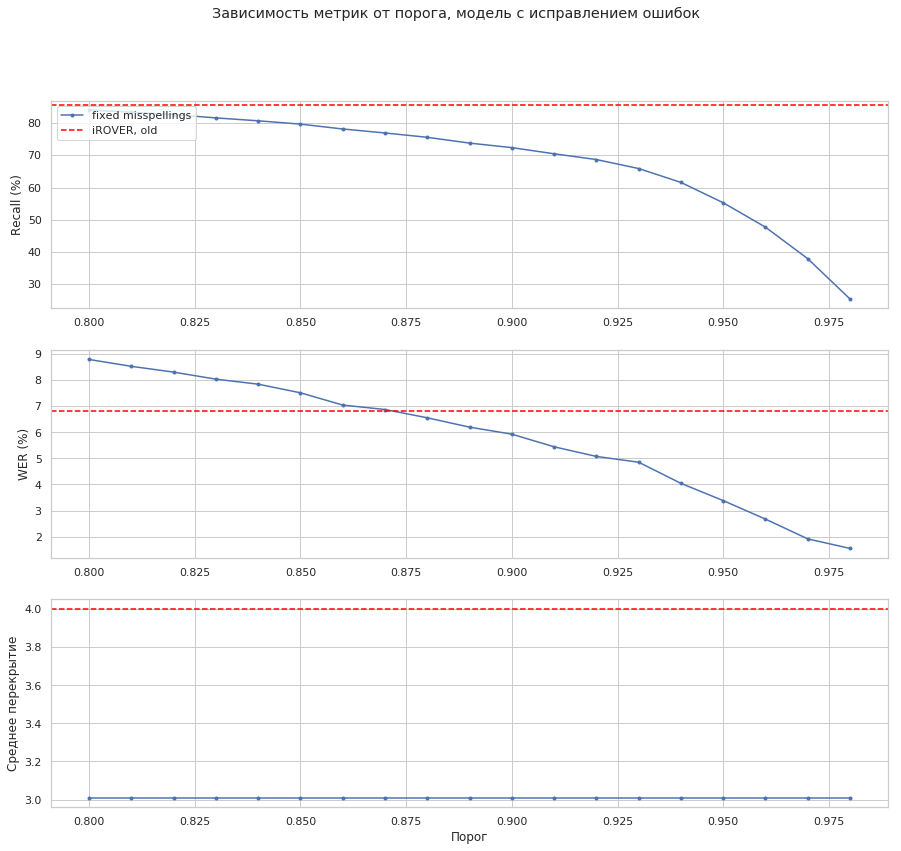

In [32]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от порога, модель с исправлением ошибок')
plt.subplot(311)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 1] * 100, 
         ".-", 
         label='fixed misspellings')
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, old")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 2] * 100, 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
plt.plot(scores_clf_test[:, 0], 
         scores_clf_test[:, 3], 
         ".-")
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
# plt.savefig('../notebooks/plots/aggregate_by_word_different_th_by_word.png')
plt.show()

In [33]:
aggregation_results = aggregate_rover_with_clf_(valid_rows, 
                                                test_features, 
                                                'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                                clf_q, 
                                                treshhold=0.948, 
                                                min_cost=3, 
                                                max_cost=10, 
                                                cluster_references=None,
                                                preaggregated=preaggregated)

In [34]:
aggregation_results

{'1014070/1928ae3a-6351-48cf-bed9-dcb5fa12df6e_f78684d2-2275-4e8b-8839-da3590f59cee_1.opus': AggregationResult(text='', confidence=0.9711312833995304, cost=4),
 '1014070/3244b5a9-4ab5-4331-a86a-acd731a6ac88_d003830f-8a2a-48de-afbd-bc9e0743484d_5.opus': AggregationResult(text='', confidence=0.9567512577263361, cost=4),
 '1014070/5e835b52-a4f8-443a-9344-8cc22a5a37ff_9b9118f4-60c1-4a46-bb7b-419746611adc_1.opus': AggregationResult(text='алиса что такое форма три справка', confidence=0.9926138004295931, cost=3),
 '1014070/cc93196b-54bc-4d7c-ab27-7f285e5d9a9a_757fc844-ed60-4797-9faa-181bcdbcb142_5.opus': AggregationResult(text='погода в ставрополе на завтра', confidence=0.9860392352955751, cost=3),
 '1014070/f71a8058-1d71-4d41-8a61-136959c06b9d_e8544c83-cb40-4a57-a7aa-a1284a3e3067_15.opus': AggregationResult(text='пока', confidence=0.9758392858938233, cost=3),
 '1017574/4869ff4b-e227-4204-8d24-a5de5c71763c_2c8cd1c0-2062-4a45-a7a5-000bc31c0e0d_73.opus': AggregationResult(text='ну тем не менее

In [39]:
field = 'toloka_assignments_repeat_11_selected_workers_with_pitch'
prod_aggregation_results = {row['mds_key']: aggregate_prod(sorted(row[field], 
                                                                  key=lambda x: x['submit_ts'])) for row in valid_rows}

In [41]:
true_text = {row['mds_key']: row['text'] for row in valid_rows}

In [50]:
final_results = {}
for mds_key, irover_results in aggregation_results.items():
    final_results[mds_key] = {
        'irover_text': irover_results.text,
        'mv_text': prod_aggregation_results[mds_key].text,
        'true_text': true_text[mds_key],
        'irover_conf': irover_results.confidence,
        'mv_conf': prod_aggregation_results[mds_key].confidence,
        'irover_cost': irover_results.cost,
        'mv_cost': prod_aggregation_results[mds_key].cost,
    }
final_results = pd.DataFrame(list(final_results.values()))

In [52]:
final_results[final_results.irover_text != final_results.mv_text].sample(30)

,irover_conf,irover_cost,irover_text,mv_conf,mv_cost,mv_text,true_text
3050,0.000000,10,None,0.40,5,,я тебе сказала вчера
2598,0.000000,10,None,0.00,5,None,самсунг galaxy а семь в две тысячи семнадцатом...
1518,0.000000,10,None,0.40,5,,
1603,0.954022,10,я просто хотел тебе рассказать кое о чем,0.00,5,None,я просто хотел тебе сказать кое о чем
2377,0.000000,10,None,0.40,5,свободные земли в псковской области,свободные изделия псковской области
2002,0.000000,10,None,0.40,5,в разгар смуты власти народа,разгар смуты и власти народа
2837,0.000000,10,None,0.40,5,а узбекистан,а узбекистана
2605,0.000000,10,None,0.60,5,сколько стоит текила в метро,сколько стоит текила в метро
2943,0.000000,10,None,0.40,5,а ты,окей
1521,0.000000,10,None,0.40,5,на новые серии,на новые серии


In [54]:
def aggregate_rover_with_clf_by_word(rows, features, field_name, clf, threshold_by_word=0.9, treshhold=0.94,
                                     min_cost=3, max_cost=10, cluster_references=None, preaggregated=None):
    """
       experiments with question sign exchange
    """
    clf_results = preaggregated
    if not clf_results:
        clf_results = preaggregate_with_clf(features, clf)
    results = dict()
    changed_signs_in_aggregated = 0
    for task_id, item0 in clf_results.items():
        for cost, item1 in sorted(item0.items()):
            if cost < min_cost or cost > max_cost:
                continue
            score = sum(score for value, score in item1) / len(item1)
            tokens = [value for value, score_ in item1 if value != ""]
            if score < treshhold:
                tokens = []
                prev_question = False
                for value, score_ in item1:
                    if score_ > threshold_by_word and value != "" and value != "?":
                        tokens.append(value)
                        prev_question = False
                    elif not prev_question and value != "":
                        tokens.append("?")
                        changed_signs_in_aggregated += 1
                        prev_question = True
            text = " ".join(tokens)
            if score >= treshhold or cost == max_cost: #MAX_NUM_ANSWERS:
                conf = score
                if text == '?' or (text == '' and score < treshhold):
                    text = None
                results[task_id] = AggregationResult(text, conf, cost)
                break
    return results

In [56]:
scores_clf_score_by_word_mean = collections.defaultdict(list)

for threshhold_common in np.linspace(0.85, 0.95, 11):
    print('\ncommon: {}'.format(threshhold_common))
    for threshhold_exchange in [threshhold_common + 0.035, threshhold_common + 0.04, threshhold_common + 0.045]:
        print('exchange: {}'.format(threshhold_exchange))
        for th_by_word in np.linspace(0.9, 1, 21):
            print('by word: {}'.format(th_by_word))
            metrics = evaluate_metrics_clf_(valid_rows, 
                                            {}, 
                                            'toloka_assignments_repeat_11_selected_workers_with_pitch', 
                                            None, 
                                            threshhold_common,
                                            threshhold_exchange,
                                            min_cost=3,
                                            max_cost=7,
                                            agg_method=partial(aggregate_rover_with_clf_by_word, 
                                                               threshold_by_word=th_by_word,
                                                               treshhold = threshhold_exchange,
                                                               preaggregated=preaggregated))
            scores_clf_score_by_word_mean[(threshhold_common, 
                                           threshhold_exchange)].append((th_by_word, *metrics))
    scores_clf_score_by_word_mean[(threshhold_common, 
                                   threshhold_exchange)] = np.array(scores_clf_score_by_word_mean[(threshhold_common, 
                                                                                                   threshhold_exchange)])



common: 0.85
exchange: 0.885
by word: 0.9
Recall: 89.9320%
WER: 9.0980%
Mean overlap: 3.617
by word: 0.905
Recall: 89.9183%
WER: 9.0626%
Mean overlap: 3.617
by word: 0.91
Recall: 89.9033%
WER: 9.0569%
Mean overlap: 3.617
by word: 0.915
Recall: 89.8976%
WER: 9.0583%
Mean overlap: 3.617
by word: 0.92
Recall: 89.8775%
WER: 9.0618%
Mean overlap: 3.617
by word: 0.925
Recall: 89.8457%
WER: 9.0590%
Mean overlap: 3.617
by word: 0.93
Recall: 89.8392%
WER: 9.0611%
Mean overlap: 3.617
by word: 0.935
Recall: 89.8371%
WER: 9.0618%
Mean overlap: 3.617
by word: 0.9400000000000001
Recall: 89.7947%
WER: 9.0277%
Mean overlap: 3.617
by word: 0.9450000000000001
Recall: 89.7786%
WER: 9.0149%
Mean overlap: 3.617
by word: 0.95
Recall: 89.7587%
WER: 9.0177%
Mean overlap: 3.617
by word: 0.9550000000000001
Recall: 89.7181%
WER: 8.9919%
Mean overlap: 3.617
by word: 0.96
Recall: 89.7023%
WER: 8.9734%
Mean overlap: 3.617
by word: 0.965
Recall: 89.6833%
WER: 8.9541%
Mean overlap: 3.617
by word: 0.97
Recall: 89.667

Recall: 87.4101%
WER: 7.7061%
Mean overlap: 3.734
by word: 0.99
Recall: 87.2630%
WER: 7.7113%
Mean overlap: 3.734
by word: 0.995
Recall: 87.2152%
WER: 7.7271%
Mean overlap: 3.734
by word: 1.0
Recall: 87.2120%
WER: 7.7284%
Mean overlap: 3.734

common: 0.87
exchange: 0.905
by word: 0.9
Recall: 87.9932%
WER: 7.9514%
Mean overlap: 3.734
by word: 0.905
Recall: 87.9827%
WER: 7.9070%
Mean overlap: 3.734
by word: 0.91
Recall: 87.9710%
WER: 7.9028%
Mean overlap: 3.734
by word: 0.915
Recall: 87.9366%
WER: 7.8966%
Mean overlap: 3.734
by word: 0.92
Recall: 87.9295%
WER: 7.8905%
Mean overlap: 3.734
by word: 0.925
Recall: 87.8879%
WER: 7.8856%
Mean overlap: 3.734
by word: 0.93
Recall: 87.8697%
WER: 7.8833%
Mean overlap: 3.734
by word: 0.935
Recall: 87.8563%
WER: 7.8871%
Mean overlap: 3.734
by word: 0.9400000000000001
Recall: 87.8238%
WER: 7.8624%
Mean overlap: 3.734
by word: 0.9450000000000001
Recall: 87.8075%
WER: 7.8359%
Mean overlap: 3.734
by word: 0.95
Recall: 87.7931%
WER: 7.8403%
Mean overlap:

Recall: 84.4184%
WER: 6.5217%
Mean overlap: 3.921
by word: 0.97
Recall: 84.3241%
WER: 6.4923%
Mean overlap: 3.921
by word: 0.975
Recall: 84.2461%
WER: 6.4684%
Mean overlap: 3.921
by word: 0.98
Recall: 84.1409%
WER: 6.4555%
Mean overlap: 3.921
by word: 0.985
Recall: 83.8959%
WER: 6.4631%
Mean overlap: 3.921
by word: 0.99
Recall: 83.6754%
WER: 6.4795%
Mean overlap: 3.921
by word: 0.995
Recall: 83.5066%
WER: 6.5150%
Mean overlap: 3.921
by word: 1.0
Recall: 83.4986%
WER: 6.5185%
Mean overlap: 3.921

common: 0.89
exchange: 0.925
by word: 0.9
Recall: 84.8557%
WER: 6.7829%
Mean overlap: 3.921
by word: 0.905
Recall: 84.8392%
WER: 6.7689%
Mean overlap: 3.921
by word: 0.91
Recall: 84.7841%
WER: 6.7651%
Mean overlap: 3.921
by word: 0.915
Recall: 84.7756%
WER: 6.7662%
Mean overlap: 3.921
by word: 0.92
Recall: 84.7245%
WER: 6.7365%
Mean overlap: 3.921
by word: 0.925
Recall: 84.6516%
WER: 6.7252%
Mean overlap: 3.921
by word: 0.93
Recall: 84.6242%
WER: 6.7061%
Mean overlap: 3.921
by word: 0.935
Recal

Recall: 80.7282%
WER: 5.5307%
Mean overlap: 4.199
by word: 0.95
Recall: 80.6540%
WER: 5.4601%
Mean overlap: 4.199
by word: 0.9550000000000001
Recall: 80.5287%
WER: 5.3989%
Mean overlap: 4.199
by word: 0.96
Recall: 80.4111%
WER: 5.3793%
Mean overlap: 4.199
by word: 0.965
Recall: 80.2701%
WER: 5.3050%
Mean overlap: 4.199
by word: 0.97
Recall: 80.1016%
WER: 5.2464%
Mean overlap: 4.199
by word: 0.975
Recall: 79.8950%
WER: 5.1939%
Mean overlap: 4.199
by word: 0.98
Recall: 79.6140%
WER: 5.1119%
Mean overlap: 4.199
by word: 0.985
Recall: 79.2881%
WER: 5.1102%
Mean overlap: 4.199
by word: 0.99
Recall: 78.8284%
WER: 5.1191%
Mean overlap: 4.199
by word: 0.995
Recall: 78.5490%
WER: 5.1424%
Mean overlap: 4.199
by word: 1.0
Recall: 78.5395%
WER: 5.1464%
Mean overlap: 4.199

common: 0.9099999999999999
exchange: 0.945
by word: 0.9
Recall: 81.1484%
WER: 5.7255%
Mean overlap: 4.199
by word: 0.905
Recall: 81.0777%
WER: 5.7138%
Mean overlap: 4.199
by word: 0.91
Recall: 81.0114%
WER: 5.6910%
Mean overlap:

Recall: 75.9461%
WER: 4.3366%
Mean overlap: 4.636
by word: 0.93
Recall: 75.6080%
WER: 4.2549%
Mean overlap: 4.636
by word: 0.935
Recall: 75.3861%
WER: 4.2003%
Mean overlap: 4.636
by word: 0.9400000000000001
Recall: 75.2619%
WER: 4.1518%
Mean overlap: 4.636
by word: 0.9450000000000001
Recall: 75.0387%
WER: 4.1063%
Mean overlap: 4.636
by word: 0.95
Recall: 74.8265%
WER: 4.0527%
Mean overlap: 4.636
by word: 0.9550000000000001
Recall: 74.5850%
WER: 3.9688%
Mean overlap: 4.636
by word: 0.96
Recall: 74.3512%
WER: 3.9177%
Mean overlap: 4.636
by word: 0.965
Recall: 74.1392%
WER: 3.8499%
Mean overlap: 4.636
by word: 0.97
Recall: 73.9300%
WER: 3.7775%
Mean overlap: 4.636
by word: 0.975
Recall: 73.6211%
WER: 3.7189%
Mean overlap: 4.636
by word: 0.98
Recall: 73.1799%
WER: 3.5940%
Mean overlap: 4.636
by word: 0.985
Recall: 72.7124%
WER: 3.5498%
Mean overlap: 4.636
by word: 0.99
Recall: 72.0166%
WER: 3.4677%
Mean overlap: 4.636
by word: 0.995
Recall: 71.4009%
WER: 3.5010%
Mean overlap: 4.636
by word

Recall: 66.2733%
WER: 3.1038%
Mean overlap: 5.71
by word: 0.91
Recall: 66.1563%
WER: 3.0756%
Mean overlap: 5.71
by word: 0.915
Recall: 66.0304%
WER: 3.0689%
Mean overlap: 5.71
by word: 0.92
Recall: 65.9062%
WER: 3.0503%
Mean overlap: 5.71
by word: 0.925
Recall: 65.6900%
WER: 2.9832%
Mean overlap: 5.71
by word: 0.93
Recall: 65.4353%
WER: 2.9484%
Mean overlap: 5.71
by word: 0.935
Recall: 65.2302%
WER: 2.9254%
Mean overlap: 5.71
by word: 0.9400000000000001
Recall: 64.9252%
WER: 2.8906%
Mean overlap: 5.71
by word: 0.9450000000000001
Recall: 64.6467%
WER: 2.8334%
Mean overlap: 5.71
by word: 0.95
Recall: 64.1740%
WER: 2.7519%
Mean overlap: 5.71
by word: 0.9550000000000001
Recall: 63.6975%
WER: 2.6830%
Mean overlap: 5.71
by word: 0.96
Recall: 63.0639%
WER: 2.6145%
Mean overlap: 5.71
by word: 0.965
Recall: 62.4562%
WER: 2.4961%
Mean overlap: 5.71
by word: 0.97
Recall: 61.7077%
WER: 2.3512%
Mean overlap: 5.71
by word: 0.975
Recall: 60.6020%
WER: 2.2438%
Mean overlap: 5.71
by word: 0.98
Recall: 

In [58]:
for key, value in scores_clf_score_by_word_mean.items():
    scores_clf_score_by_word_mean[key] = np.array(value)

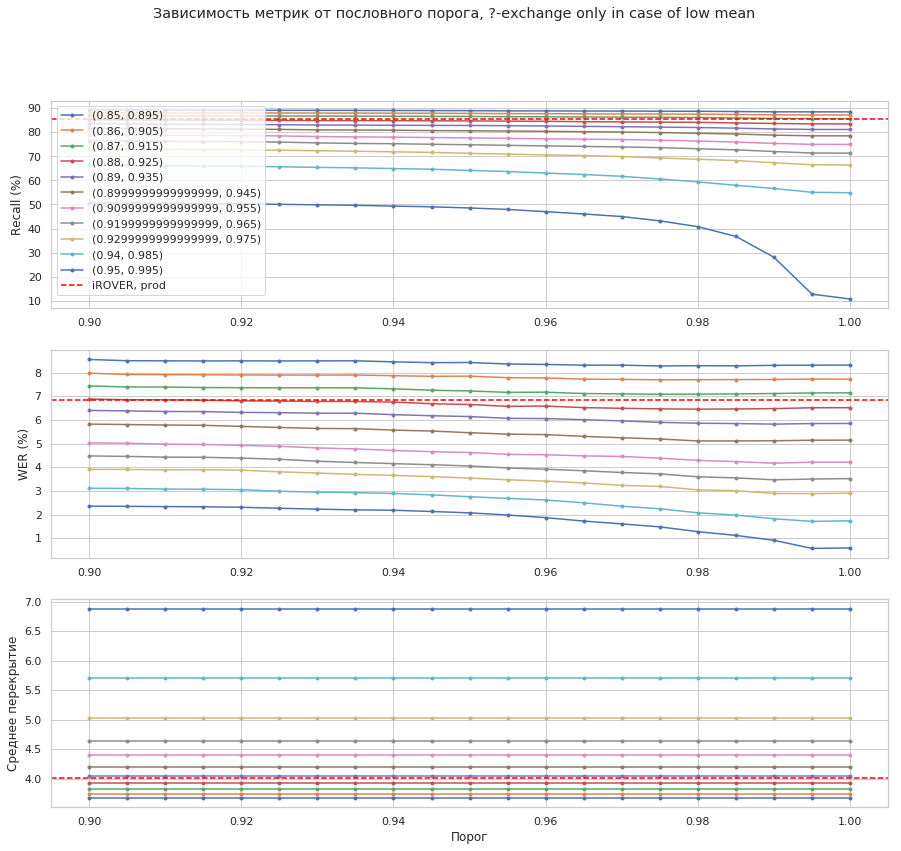

In [60]:
plt.figure(figsize=(15,13))
plt.suptitle('Зависимость метрик от пословного порога, ?-exchange only in case of low mean ')
plt.subplot(311)
dif = 0.045
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 1] * 100, 
                 ".-", 
                 label=str(key))
#plt.axhline(y=prod_agg_metrics[0] * 100, color=u'#1f77b4', linestyle='--', label="MV, prod")
plt.axhline(y=baseline_loaded_new_metrics[1] * 100, color='red', linestyle='--', label="iROVER, prod")
plt.legend(loc='upper left')
plt.ylabel('Recall (%)')

plt.subplot(312)
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 2] * 100, 
                 ".-")
#plt.axhline(y=prod_agg_metrics[1] * 100, color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[2] * 100, color='red', linestyle='--')
plt.ylabel('WER (%)')

plt.subplot(313)
for key, value in scores_clf_score_by_word_mean.items():
    if round(key[1] - key[0], 3) == dif:
        plt.plot(value[:, 0], 
                 value[:, 3], 
                 ".-")
#plt.axhline(y=prod_agg_metrics[2], color=u'#1f77b4', linestyle='--')
plt.axhline(y=baseline_loaded_new_metrics[3], color='red', linestyle='--')
plt.ylabel('Среднее перекрытие')

plt.xlabel('Порог')
plt.show()

In [61]:
needed_points2 = []
default = (None, 0, 1, 10)
for threshold, metrics in scores_clf_score_by_word_mean.items():
    prev = default
    for th_by_word, recall, wer, cost in metrics:
        if wer <= prev[2] and wer < baseline_loaded_new_metrics[2] \
            and recall > baseline_loaded_new_metrics[1] and recall > prev[1]:
            prev = ((*threshold, round(th_by_word, 3)), recall, wer, cost)
    if prev != default:
        needed_points2.append(prev)   
needed_points2.append(['baseline'] + list(baseline_loaded_new_metrics[1:]))
needed_points2.sort(key=lambda x: x[1], reverse=True)

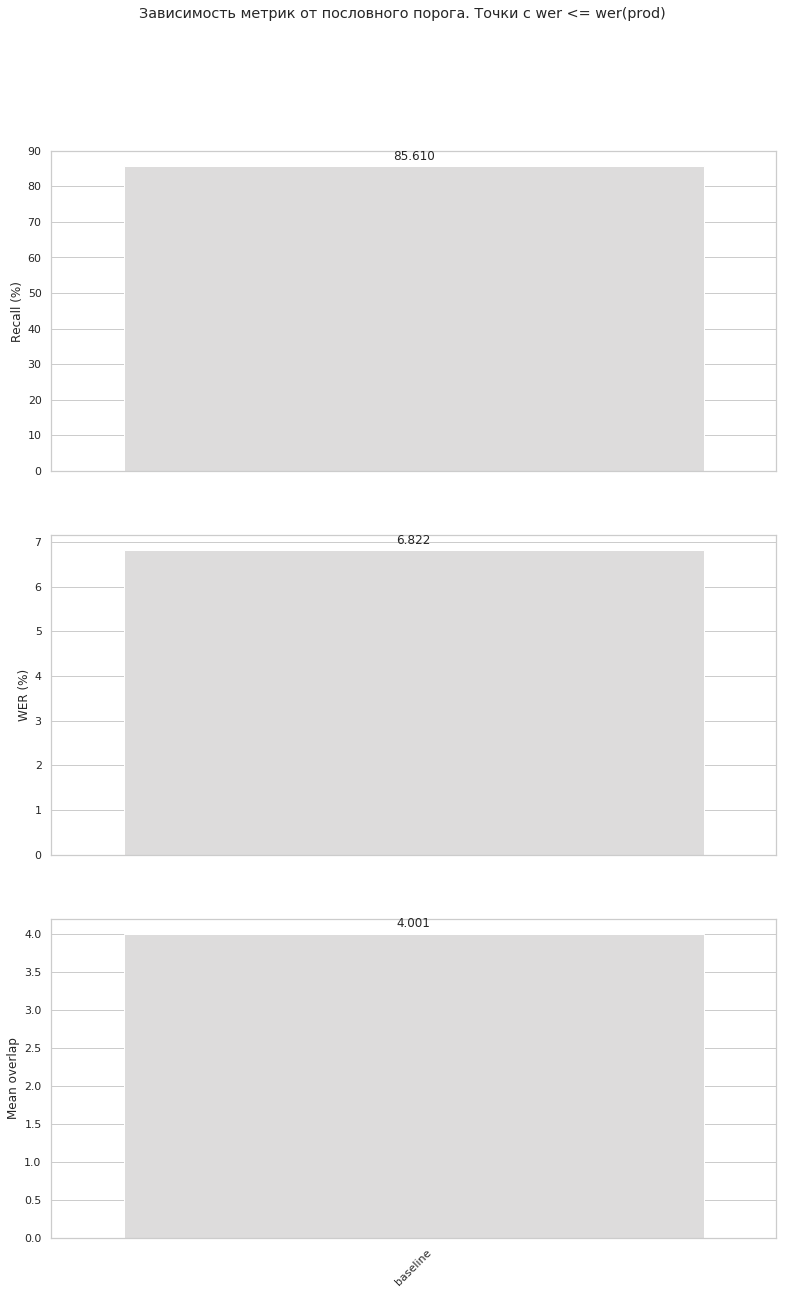

In [62]:
plt.figure(figsize=(13,20))
plt.suptitle('Зависимость метрик от пословного порога. Точки с wer <= wer(prod)')
plt.subplot(311)
plt.ylabel('Recall (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[1]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(312)
plt.ylabel('WER (%)')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[2]*100 for point in needed_points2],
                 palette="coolwarm")
plt.xticks([], [])
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')

plt.subplot(313)
plt.ylabel('Mean overlap')
ax = sns.barplot(x=list(map(str, [point[0] for point in needed_points2])), 
                 y=[point[3] for point in needed_points2],
                 palette="coolwarm")
for item in ax.get_xticklabels():
    item.set_rotation(45)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.3f'), 
                (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 10), 
                textcoords = 'offset points')
# plt.savefig('../notebooks/plots/aggregate_by_word_3_th_best_choice.png')
plt.show()